In [2]:
import numpy as np
from array import *
import csv

# using datetime module
import datetime;

# Binary Search
from bisect import bisect_left
from bisect import bisect_right

import matplotlib.pyplot as plt
import json
import os
import pandas as pd

import multiprocessing as mp
from multiprocessing import Process, Queue
from multiprocessing import current_process
import queue
import threading


import random
from tqdm import tqdm



import pickle

import powerlaw

print('----------------------')
#unique_payment_addresses_len = len(unique_payment_addresses)
unique_raw_addresses_len        = 40330345
unique_payment_addresses_len    = 40324960
unique_delegation_addresses_len = 3868049
print('unique_raw_addresses_len        = ', unique_raw_addresses_len)
print('unique_payment_addresses_len    = ', unique_payment_addresses_len)
print('unique_delegation_addresses_len = ', unique_delegation_addresses_len)

INITIAL_DATE_CARDANO      = datetime.datetime.strptime('2017-09-23 21:44:51', '%Y-%m-%d %H:%M:%S').date()
FINAL_DATE_CARDANO        = datetime.datetime.strptime('2023-01-21 17:39:30', '%Y-%m-%d %H:%M:%S').date()
total_time_length_CARDANO = int((FINAL_DATE_CARDANO - INITIAL_DATE_CARDANO).total_seconds()/86400) + 1


print('----------------------')
print('done!')



----------------------
unique_raw_addresses_len        =  40330345
unique_payment_addresses_len    =  40324960
unique_delegation_addresses_len =  3868049
----------------------
done!


In [3]:
#BASE_ADDRESS = '/local/scratch/exported/blockchain_parsed/cardano_mostafa'
BASE_ADDRESS = '/local/scratch/exported/Cardano_MCH_2023_1/'
TEMP_ADDRESS = BASE_ADDRESS + '/temp_files/'


from matplotlib import font_manager
font_dirs = ['/home/user/chegeni/fonts']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')


print('----------------------')
print('done!')


----------------------
done!


In [4]:
# Define required methods:


print('----------------------')

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)



##########################################################################################
def parent (id1, parents_array):
    return parents_array[id1];

##########################################################################################
def find_parent (id1, parents_array):
    while (id1 != parent(id1, parents_array)):
        new_parent = parent(parent(id1, parents_array), parents_array);
        id1        = new_parent;
    
    return id1

##########################################################################################
# Link two addresses based on "Union-Find" Algorithm:
def link_address (addr_position_1, addr_position_2, parents_array):
    id1 = find_parent(addr_position_1, parents_array)
    id2 = find_parent(addr_position_2, parents_array)

    if (id1 == id2):
        return

    # make sure always we have id1 > id2
    if id1 < id2:
        x = id1
        id1 = id2
        id2 = x

    parents_array[id1] = id2
    return

##########################################################################################
def resolveAll (parents_array):
    for id1 in tqdm(range(len(parents_array))):
        parents_array[id1] = find_parent(id1, parents_array);
    return

##########################################################################################
def remapClusterIds (parents_array, clustering_array):
    cluster_count = 0
    place_holder = 9999999999999
    new_cluster_ids = [place_holder] * len(parents_array)
    
    for i in range(len(clustering_array)):
        clustering_array[i] = parents_array[i]

    for i in tqdm(range(len(clustering_array))):
        parent_index = clustering_array[i]

        if (new_cluster_ids [parent_index] == place_holder):
            new_cluster_ids [parent_index] = cluster_count
            cluster_count = cluster_count + 1

        clustering_array[i] = new_cluster_ids [parent_index]

    return cluster_count;

##########################################################################################
def merge_parents(parents_array, parents_merged):
    if (len(parents_array) != len(parents_merged)):
        print('parents_merged Error: -1 (Length)')
        return -1
    
    for i in tqdm(range(len(parents_merged))):
        link_address (i, parents_array[i], parents_merged)


##########################################################################################
def BinarySearch(a, x, debug=True):
    i = bisect_left(a, x)
    if i < len(a) and a[i] == x:
        return i
    else:
        if(debug):
            print('BinarySearch Error: -1')
        return -1

##########################################################################################
def BinarySearch_Find_start_end(a, x):
    i = bisect_left(a, x)
    j = bisect_right(a, x) - 1
    if i < len(a) and a[i] == x and j < len(a) and a[j] == x:
        return [i, j]
    else:
        print('BinarySearch Error: -1')
        print('i = ', i)
        print('j = ', j)
        return -1


##########################################################################################
def store_array_to_file (input_array_name, file_name, index_=False, header_=None):
    ct = datetime.datetime.now()
    curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]
    print('start time (Store Array to ' + file_name + '): ', ct)

    df = pd.DataFrame(input_array_name)
    df.to_csv(file_name, index=index_, header=header_)

    '''
    with open(file_name, 'w') as filehandle:
        for element in input_array_name:
            filehandle.write(f'{element}\n')
    '''

    et = datetime.datetime.now() - ct
    print('elapsed time (Store Array to ' + file_name + '): ', et)

    return

##########################################################################################
def load_file_to_array (file_name, header_=None):
    ct = datetime.datetime.now()
    curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]
    #print('start time (Load ' + file_name  + ' to Array): ', ct)

    df = pd.read_csv(file_name, header=header_)
    output_array_name = df.to_numpy()
    
    '''
    output_array_name = []
    with open(file_name, 'r') as filehandle:
        for line in filehandle:
            # Remove linebreak which is the last character of the string
            curr_place = line[:-1]
            # Add item to the list
            output_array_name.append(curr_place)
    '''    

    '''
    for index, row in df.iterrows():
        new_line = df.loc[index , 0]
        output_array_name.append(new_line)
        if (index%1000000 == 0):
                print('One New Milion Records loaded: ', index)
    '''

    et = datetime.datetime.now() - ct
    #print('elapsed time (Load ' + file_name  + ' to Array): ', et)
    
    return output_array_name

##########################################################################################
def store_array_to_file_2D (input_array_name, file_name):
    ct = datetime.datetime.now()
    curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]
    print('start time (Store Array 2D to ' + file_name + '): ', ct)

    with open(file_name, "w") as filehandle:
        json.dump(input_array_name, filehandle)
    
    et = datetime.datetime.now() - ct
    print('elapsed time (Store Array 2D to ' + file_name + '): ', et)

    return

##########################################################################################
def load_file_to_array_2D (file_name):
    ct = datetime.datetime.now()
    curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]
    print('start time (Load ' + file_name  + ' to Array 2D): ', ct)

    with open(file_name) as filehandle:
        output_array_name = json.load(filehandle)

    et = datetime.datetime.now() - ct
    print('elapsed time (Load ' + file_name  + ' to Array 2D): ', et)
    
    return output_array_name


##########################################################################################
def store_dict_to_file_INT (input_dict_name, file_name):
    ct = datetime.datetime.now()
    curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]
    print('start time (Store Dictionary to ' + file_name + '): ', ct)

    filehandle = csv.writer(open(file_name, 'w'))
    for key, val in input_dict_name.items():
        filehandle.writerow([key, val])

    et = datetime.datetime.now() - ct
    print('elapsed time (Store Dictionary to ' + file_name + '): ', et)

    return

##########################################################################################
def load_file_to_dict_INT (file_name):
    ct = datetime.datetime.now()
    curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]
    print('start time (Load ' + file_name  + ' to Dictionary): ', ct)

    filehandle = csv.reader(open(file_name, 'r'))
    output_dict_name = {int(rows[0]):int(rows[1]) for rows in filehandle}

    et = datetime.datetime.now() - ct
    print('elapsed time (Load ' + file_name  + ' to Dictionary): ', et)
    
    return output_dict_name

##########################################################################################
def add_edge_info(node_1, node_2, edges_array, weight=1):
    if (node_1 == node_2):
        return

    # make sure always we have n1 > n2:
    if (node_1 < node_2):
        n1 = node_2
        n2 = node_1
    else:
        n1 = node_1
        n2 = node_2

    for i in range(weight):
        edges_array[n1].append(n2)

    return

##########################################################################################
def extract_payment_delegation_parts(address_raw, payment_cred, stake_address):
    if (address_raw == ''):
        #print(' - Error: address_raw is empty!')
        return ['', '']

    if (address_raw[2] == '8'): #Byron Address
        if (payment_cred != ''):
            print(' - Error: payment_cred in Byron Address is NOT empty!')
            return ['', '']
        if (stake_address != ''):
            print(' - Error: stake_address in Byron Address is NOT empty!')
            return ['', '']
        payment_part    = address_raw
        delegation_part = ''

    else: #Shelley Address
        if (payment_cred == ''):
            print(' - Error: payment_cred in Shelley Address is empty!')
            return ['', '']
        payment_part    = payment_cred
        delegation_part = stake_address

    return [payment_part, delegation_part]

##########################################################################################
# Function which calculates the Gini index
# Inputs: array with length equal to number of agents; each element in array represents the wealth of the agent
# Outputs: gini index of the system
def gini_index(inp_array):
    array = np.array(inp_array)
    array = array.astype(float)
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0] #number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

##########################################################################################
def Gini_rank(agent_reward):
    reward_values = np.sort(agent_reward)
    Mean = np.mean(reward_values)
    Amount_n = len(reward_values)
    sum_i = 0

    for i, xi in enumerate(reward_values):
        sum_i += (i+1) * (xi - Mean) 

    gini_index = (2 * sum_i) / (pow(Amount_n,2) * Mean)
    return gini_index

##########################################################################################



##########################################################################################



##########################################################################################



##########################################################################################
print('----------------------')
print('done!')



----------------------
current time:  2024-02-20 22:19:32.274690
----------------------
done!


In [9]:
# Read ("sorted" "unique" array_list) [raw_address_list/payment_address_list/delegation_address_list] from file:

print('----------------------')


file_name = BASE_ADDRESS + '/Unique_AddressesListRaw__Cardano_TXs_All__2023-02-28_143357.txt'
unique_raw_addresses = load_file_to_array (file_name)
print('Length of \"unique_raw_addresses\" = ' + str(len(unique_raw_addresses)))


file_name = BASE_ADDRESS + '/Unique_AddressesListPayment__Cardano_TXs_All__2023-02-28_143953.txt'
unique_payment_addresses = load_file_to_array (file_name)
print('Length of \"unique_payment_addresses\" = ' + str(len(unique_payment_addresses)))


file_name = BASE_ADDRESS + '/Unique_AddressesListDelegation__Cardano_TXs_All__2023-02-28_144415.txt'
unique_delegation_addresses = load_file_to_array (file_name)
print('Length of \"unique_delegation_addresses\" = ' + str(len(unique_delegation_addresses)))


##########################################################################################
print('----------------------')
print('done!')



----------------------
start time (Load /local/scratch/exported/Cardano_MCH_2023_1//Unique_AddressesListRaw__Cardano_TXs_All__2023-02-28_143357.txt to Array):  2023-12-16 22:45:13.846975
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//Unique_AddressesListRaw__Cardano_TXs_All__2023-02-28_143357.txt to Array):  0:00:51.621912
Length of "unique_raw_addresses" = 40330345
start time (Load /local/scratch/exported/Cardano_MCH_2023_1//Unique_AddressesListPayment__Cardano_TXs_All__2023-02-28_143953.txt to Array):  2023-12-16 22:46:05.469657
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//Unique_AddressesListPayment__Cardano_TXs_All__2023-02-28_143953.txt to Array):  0:00:37.562033
Length of "unique_payment_addresses" = 40324960
start time (Load /local/scratch/exported/Cardano_MCH_2023_1//Unique_AddressesListDelegation__Cardano_TXs_All__2023-02-28_144415.txt to Array):  2023-12-16 22:46:43.031948
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//Unique_

In [10]:
# Read clustering_array[] from file:

file_name = BASE_ADDRESS + '/clusteringArrayList_Heuristic1noSC__Cardano_TXs_All__2023-02-25_223957.txt'
clustering_array_heur1 = load_file_to_array (file_name)


file_name = BASE_ADDRESS + '/clusteringArrayList_Heuristic2__Cardano_TXs_All__2023-03-26_110150.txt'
clustering_array_heur2 = load_file_to_array (file_name)


file_name = BASE_ADDRESS + '/clusteringArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__2023-03-26_141212.txt'
clustering_array_heur1and2 = load_file_to_array (file_name)


##########################################################################################
print('----------------------')
print('done!')



start time (Load /local/scratch/exported/Cardano_MCH_2023_1//clusteringArrayList_Heuristic1noSC__Cardano_TXs_All__2023-02-25_223957.txt to Array):  2023-12-16 22:46:46.029144
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//clusteringArrayList_Heuristic1noSC__Cardano_TXs_All__2023-02-25_223957.txt to Array):  0:00:11.177047
start time (Load /local/scratch/exported/Cardano_MCH_2023_1//clusteringArrayList_Heuristic2__Cardano_TXs_All__2023-03-26_110150.txt to Array):  2023-12-16 22:46:57.206396
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//clusteringArrayList_Heuristic2__Cardano_TXs_All__2023-03-26_110150.txt to Array):  0:00:10.420041
start time (Load /local/scratch/exported/Cardano_MCH_2023_1//clusteringArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__2023-03-26_141212.txt to Array):  2023-12-16 22:47:07.626814
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//clusteringArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__2023-03

In [11]:
##########################################################################################
print('----------------------')
print('\"unique_raw_addresses_len\"             = ', unique_raw_addresses_len)
print('\"unique_payment_addresses_len\"         = ', unique_payment_addresses_len)
print('\"unique_delegation_addresses_len\"      = ', unique_delegation_addresses_len)

print('Length of \"clustering_array_heur1\"     = ', len(clustering_array_heur1))
print('number of clusters_heur1               = ', len(np.unique(clustering_array_heur1)))
print('Length of \"clustering_array_heur2\"     = ', len(clustering_array_heur2))
print('number of clusters_heur2               = ', len(np.unique(clustering_array_heur2)))
print('Length of \"clustering_array_heur1and2\" = ', len(clustering_array_heur1and2))
print('number of clusters_heur1and2           = ', len(np.unique(clustering_array_heur1and2)))


##########################################################################################
print('----------------------')
print('done!')


----------------------
"unique_raw_addresses_len"             =  40330345
"unique_payment_addresses_len"         =  40324960
"unique_delegation_addresses_len"      =  3868049
Length of "clustering_array_heur1"     =  40324960
number of clusters_heur1               =  19249106
Length of "clustering_array_heur2"     =  40324960
number of clusters_heur2               =  18529342
Length of "clustering_array_heur1and2" =  40324960
number of clusters_heur1and2           =  8805791
----------------------
done!


In [73]:
# Load  "raw_addresses_epoch_array",              from file:
#       "Byron_payment_addresses_epoch_array", 
#       "Shelley_payment_addresses_epoch_array", 
#       "delegation_addresses_epoch_array"

file_name = BASE_ADDRESS + '/epochArray_rawAddresses__Cardano_TXs_All__2023-03-27_085508.txt'
raw_addresses_epoch_array             = load_file_to_array(file_name)

file_name = BASE_ADDRESS + '/epochArray_ByronAddresses__Cardano_TXs_All__2023-03-27_085508.txt'
Byron_payment_addresses_epoch_array   = load_file_to_array(file_name)

file_name = BASE_ADDRESS + '/epochArray_ShelleyAddresses__Cardano_TXs_All__2023-03-27_085508.txt'
Shelley_payment_addresses_epoch_array = load_file_to_array(file_name)

file_name = BASE_ADDRESS + '/epochArray_delegationAddresses__Cardano_TXs_All__2023-03-27_085508.txt'
delegation_addresses_epoch_array      = load_file_to_array(file_name)

##########################################################################################

print('----------------------')
print('done!')



start time (Load /local/scratch/exported/Cardano_MCH_2023_1//epochArray_rawAddresses__Cardano_TXs_All__2023-03-27_085508.txt to Array):  2023-12-17 00:11:00.694766
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//epochArray_rawAddresses__Cardano_TXs_All__2023-03-27_085508.txt to Array):  0:00:05.079131
start time (Load /local/scratch/exported/Cardano_MCH_2023_1//epochArray_ByronAddresses__Cardano_TXs_All__2023-03-27_085508.txt to Array):  2023-12-17 00:11:05.774319
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//epochArray_ByronAddresses__Cardano_TXs_All__2023-03-27_085508.txt to Array):  0:00:05.518673
start time (Load /local/scratch/exported/Cardano_MCH_2023_1//epochArray_ShelleyAddresses__Cardano_TXs_All__2023-03-27_085508.txt to Array):  2023-12-17 00:11:11.293249
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//epochArray_ShelleyAddresses__Cardano_TXs_All__2023-03-27_085508.txt to Array):  0:00:04.944672
start time (Load /local/scratch/ex

In [75]:
# Load/Store "entity_of_stake_addresses" from/into file:


print('----------------------')
ct = datetime.datetime.now()
curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]


# Store "entity_of_stake_addresses" into file:
'''
output_filename = BASE_ADDRESS + '/Entities_related_to_Stake_Addresses__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file(entity_of_stake_addresses, output_filename)
'''



# Load  "entity_of_stake_addresses" from file:

file_name = BASE_ADDRESS + '/Entities_related_to_Stake_Addresses__Cardano_TXs_All__2023-12-12_190821.txt'
entity_of_stake_addresses = load_file_to_array(file_name)


##########################################################################################
print('----------------------')
print('done!')


----------------------
start time (Load /local/scratch/exported/Cardano_MCH_2023_1//Entities_related_to_Stake_Addresses__Cardano_TXs_All__2023-12-12_190821.txt to Array):  2023-12-17 00:11:59.804878
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//Entities_related_to_Stake_Addresses__Cardano_TXs_All__2023-12-12_190821.txt to Array):  0:00:00.276071
----------------------
done!


100%|██████████| 390/390 [02:24<00:00,  2.71it/s]


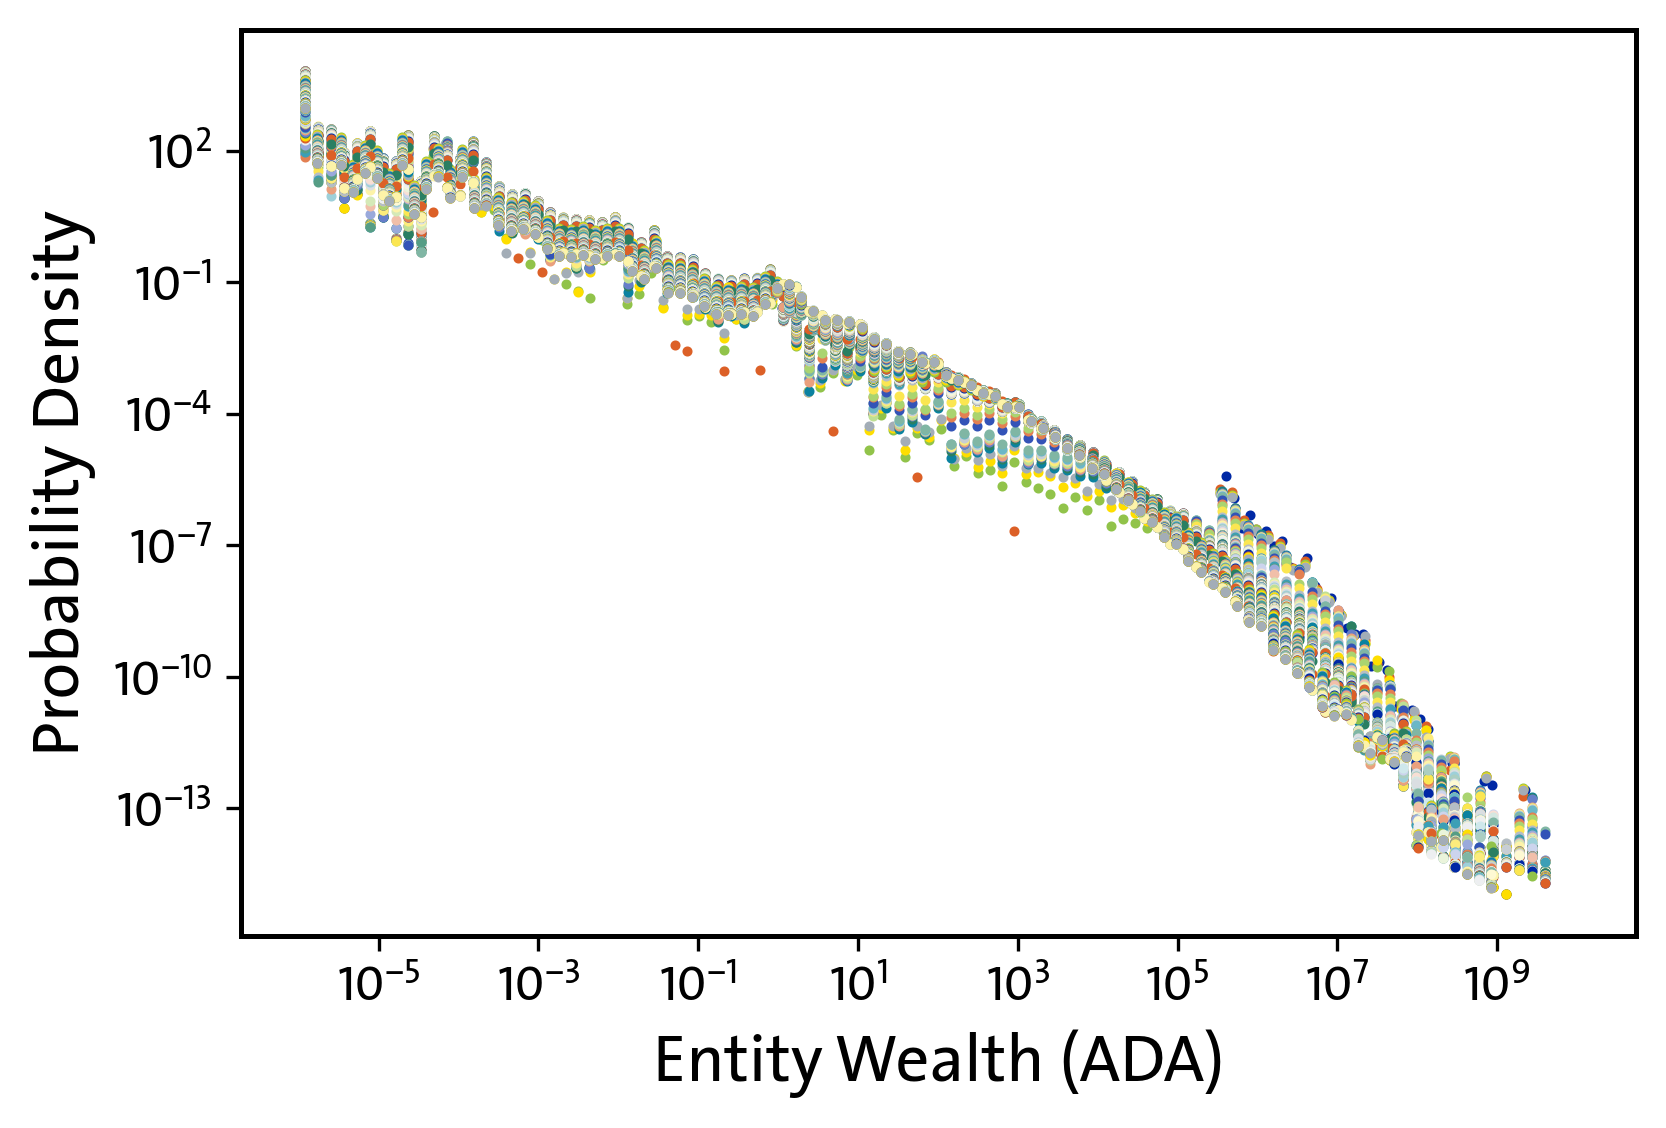

In [252]:
# Entities(Heur1 and Heur2) "Wealth" Distributions:

plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')


for i in tqdm(range(0, 1945+1, 5)):
    # Load  "entity_balances" from file:
    file_name = BASE_ADDRESS + '/YuZhang_Cardano_Balances_Entities/BalancesPerEntityDay_' + str(i).zfill(4) + '__Cardano_TXs_All.txt'
    entities_wealth_ADA = load_file_to_array(file_name)
    entities_wealth_ADA = entities_wealth_ADA[entities_wealth_ADA != 0]
    entities_wealth_ADA = np.array(entities_wealth_ADA, dtype=np.float64)
    entities_wealth_ADA = entities_wealth_ADA/(10**6)
    #entities_wealth_ADA = entities_wealth_ADA.ravel().tolist()


    # Generate logarithmic bin edges
    min_exp = np.floor(np.log10(entities_wealth_ADA.min()))
    max_exp = np.ceil(np.log10(entities_wealth_ADA.max()))
    bins_log = np.logspace(min_exp, max_exp, num=100)  # 100 bins
    #bins_log = np.logspace(entities_wealth_ADA.min(), entities_wealth_ADA.max(), num=100)  # 100 bins

    # Compute the normalized histogram with logarithmic bins
    hist, bins = np.histogram(entities_wealth_ADA, bins=bins_log, density=True)

    # Calculate the center of each bin
    bin_centers = np.sqrt(bins[1:] * bins[:-1])  # Geometric mean for log bins



    # Plotting using scatter plot
    plt.scatter(bin_centers, hist, marker='o', s=2)


plt.xlabel('Entity Wealth (ADA)')
plt.ylabel('Probability Density')

# Set the scale of x and y axes to logarithmic
plt.xscale('log')
plt.yscale('log')

#plt.xlim(left=10, right=10**10)
#plt.ylim(bottom=1e-14)


plt.savefig('fig_entities_wealth_distribution.pdf', bbox_inches='tight', facecolor='white')
plt.savefig('fig_entities_wealth_distribution.png', bbox_inches='tight', facecolor='white')
plt.show()



100%|██████████| 181/181 [01:11<00:00,  2.54it/s]


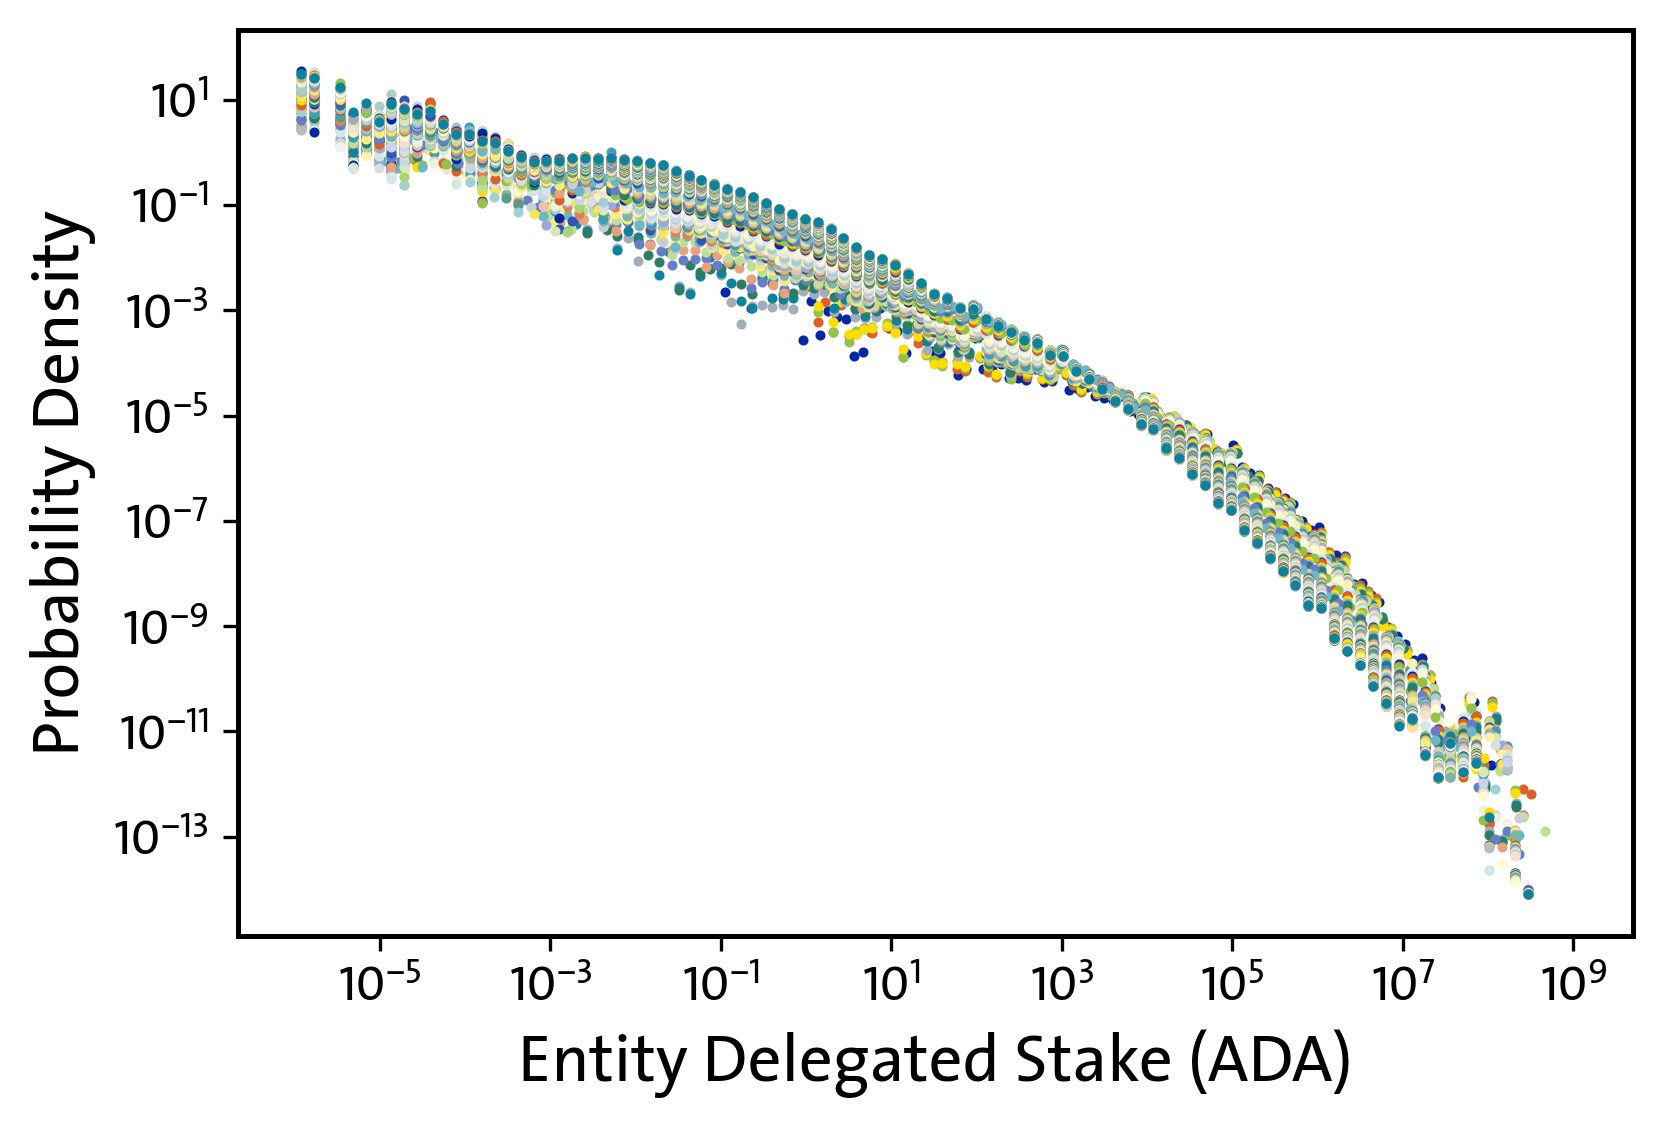

In [255]:
# Entities(Heur1 and Heur2) "Stake Delegation" Distributions:


plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')


for i in tqdm(range(210, 391)):
    file_name = BASE_ADDRESS + '/YuZhang_Cardano_StakeDelegation_Entities/StakeDelegPerEntityEpoch_' + str(i).zfill(4) + '__Cardano_TXs_All.txt'
    entities_stakeDelegation_ADA = load_file_to_array(file_name)
    entities_stakeDelegation_ADA = entities_stakeDelegation_ADA[entities_stakeDelegation_ADA != 0]
    entities_stakeDelegation_ADA = np.array(entities_stakeDelegation_ADA, dtype=np.float64)
    entities_stakeDelegation_ADA = entities_stakeDelegation_ADA/(10**6)
    #entities_stakeDelegation_ADA = entities_stakeDelegation_ADA.ravel().tolist()

    # Generate logarithmic bin edges
    min_exp = np.floor(np.log10(entities_stakeDelegation_ADA.min()))
    max_exp = np.ceil(np.log10(entities_stakeDelegation_ADA.max()))
    bins_log = np.logspace(min_exp, max_exp, num=100)  # 100 bins

    # Compute the normalized histogram with logarithmic bins
    hist, bins = np.histogram(entities_stakeDelegation_ADA, bins=bins_log, density=True)

    # Calculate the center of each bin
    bin_centers = np.sqrt(bins[1:] * bins[:-1])  # Geometric mean for log bins

    # Plotting using scatter plot
    plt.scatter(bin_centers, hist, marker='o', s=2)


plt.xlabel('Entity Delegated Stake (ADA)')
plt.ylabel('Probability Density')

# Set the scale of x and y axes to logarithmic
plt.xscale('log')
plt.yscale('log')

#plt.xlim(left=10, right=10**10)
#plt.ylim(bottom=1e-14)


plt.savefig('fig_entities_stakeDelegation_distribution.pdf', bbox_inches='tight', facecolor='white')
plt.savefig('fig_entities_stakeDelegation_distribution.png', bbox_inches='tight', facecolor='white')
plt.show()



5

100%|██████████| 181/181 [01:06<00:00,  2.70it/s]


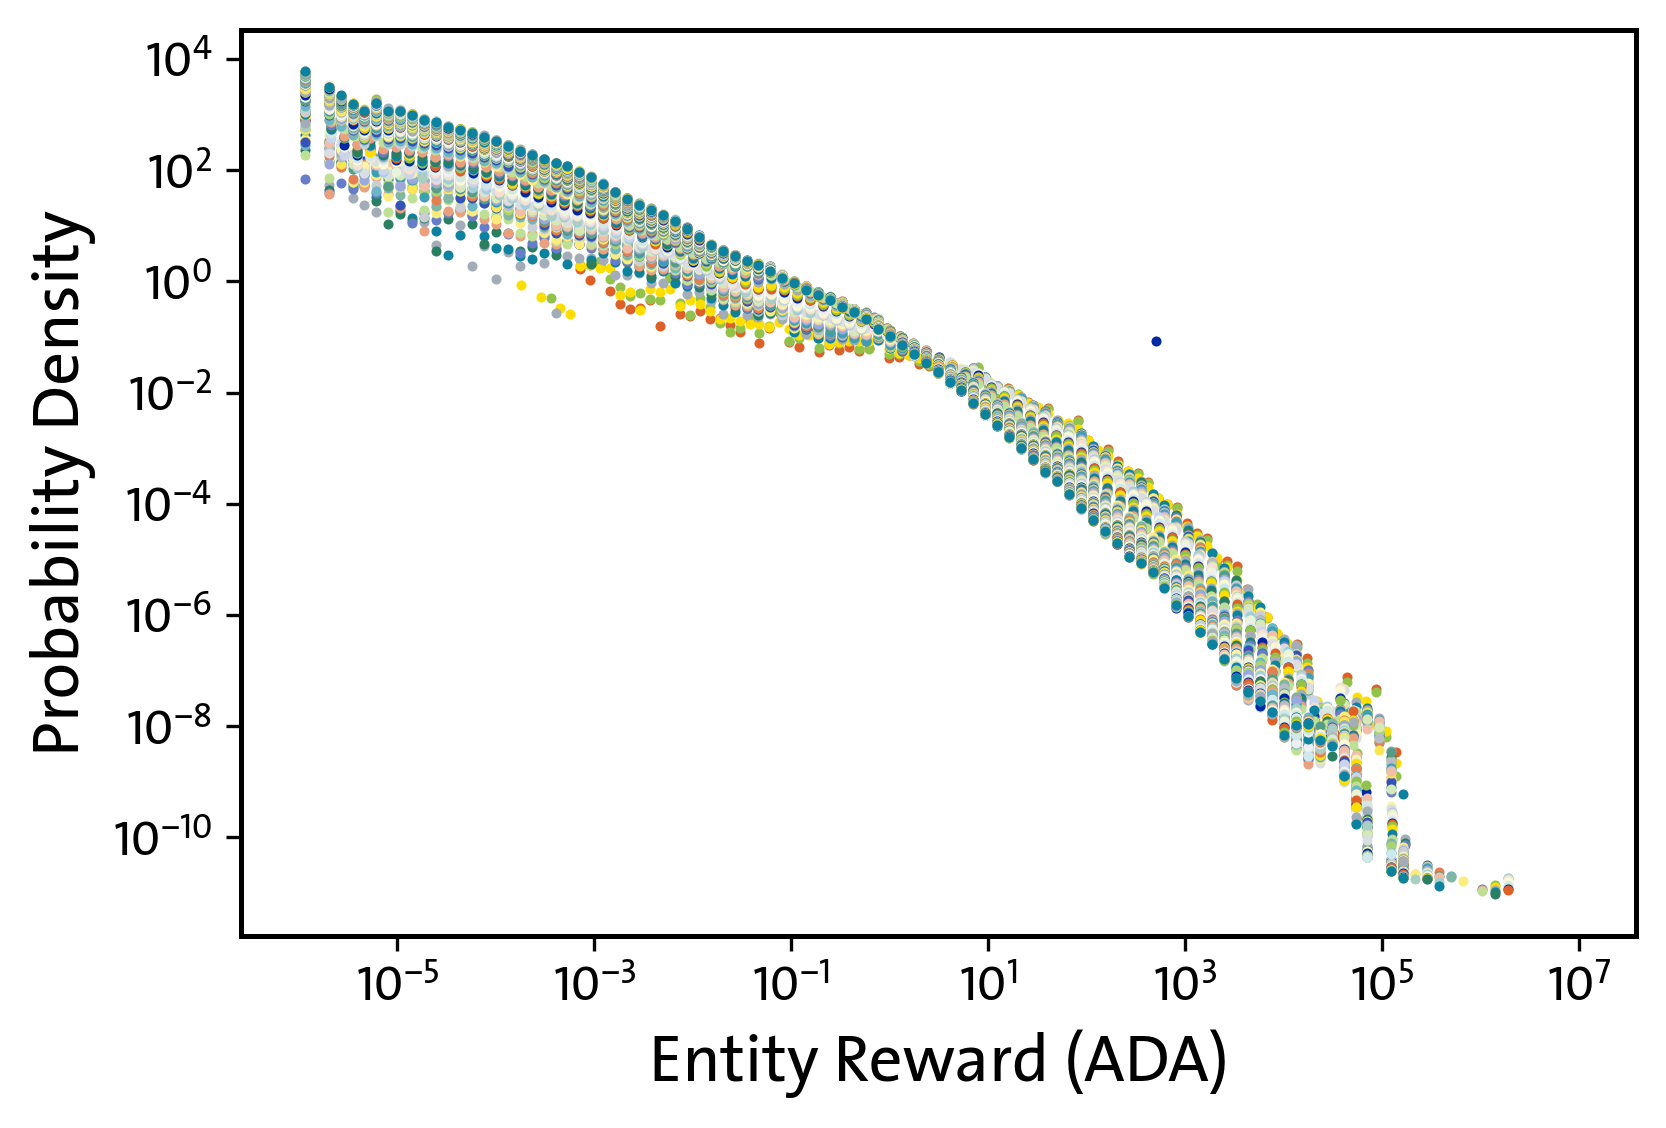

In [257]:
# Entities(Heur1 and Heur2) "Reward" Distributions:


plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')


for i in tqdm(range(210, 391)):
    file_name = BASE_ADDRESS + '/YuZhang_Cardano_Reward_Entities/RewardPerEntityEpoch_' + str(i).zfill(4) + '__Cardano_TXs_All.txt'
    entities_reward_ADA = load_file_to_array(file_name)
    entities_reward_ADA = entities_reward_ADA[entities_reward_ADA != 0]
    entities_reward_ADA = np.array(entities_reward_ADA, dtype=np.float64)
    entities_reward_ADA = entities_reward_ADA/(10**6)
    #entities_reward_ADA = entities_reward_ADA.ravel().tolist()


    # Generate logarithmic bin edges
    min_exp = np.floor(np.log10(entities_reward_ADA.min()))
    max_exp = np.ceil(np.log10(entities_reward_ADA.max()))
    bins_log = np.logspace(min_exp, max_exp, num=100)  # 100 bins


    # Compute the normalized histogram with logarithmic bins
    hist, bins = np.histogram(entities_reward_ADA, bins=bins_log, density=True)

    # Calculate the center of each bin
    bin_centers = np.sqrt(bins[1:] * bins[:-1])  # Geometric mean for log bins

    # Plotting using scatter plot
    plt.scatter(bin_centers, hist, marker='o', s=2)


plt.xlabel('Entity Reward (ADA)')
plt.ylabel('Probability Density')

# Set the scale of x and y axes to logarithmic
plt.xscale('log')
plt.yscale('log')

#plt.xlim(left=10, right=10**10)
#plt.ylim(bottom=1e-14)


plt.savefig('fig_entities_reward_distribution.pdf', bbox_inches='tight', facecolor='white')
plt.savefig('fig_entities_reward_distribution.png', bbox_inches='tight', facecolor='white')
plt.show()



In [5]:
# Calculate "Gini Index" of Entities (Balances):


print('----------------------')
ct = datetime.datetime.now()
curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]

first_epoch_no = 0
last_epoch_no  = 391
total_num_of_epochs = int(last_epoch_no - first_epoch_no + 1)


gini_index_entity_Balances   = [0]*total_num_of_epochs



for i in tqdm(range(0, 1945+1, 5)):
    # Load  "entity_balances" from file:
    file_name = BASE_ADDRESS + '/YuZhang_Cardano_Balances_Entities/BalancesPerEntityDay_' + str(i).zfill(4) + '__Cardano_TXs_All.txt'
    entity_balances = load_file_to_array(file_name)
    entity_balances = entity_balances[entity_balances != 0]
    entity_balances = np.array(entity_balances, dtype=np.float64)
    entity_balances = entity_balances/(10**6)

    epoch_no = int(i/5)
    if(epoch_no < len(gini_index_entity_Balances)):
        gini_index_entity_Balances [epoch_no] = Gini_rank(entity_balances)



##########################################################################################
print('----------------------')
print('done!')




----------------------


100%|██████████| 390/390 [05:17<00:00,  1.23it/s]

----------------------
done!


In [ ]:
# Store "gini_index_entity_Balances" into file:
'''
output_filename = BASE_ADDRESS + '/Entities_GiniIndex_Balances_perEpoch__' + curr_timestamp + '__Cardano_TXs_All.txt'
print('output_filename = ', output_filename)
store_array_to_file(gini_index_entity_Balances, output_filename)
'''


In [6]:
# Calculate "Gini Index" of Entities (Stake Delegation):


print('----------------------')
ct = datetime.datetime.now()
curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]

first_epoch_no = 210
last_epoch_no  = 391
total_num_of_epochs = int(last_epoch_no - 0 + 1)


gini_index_entity_StakeDeleg = [0]*total_num_of_epochs



for i in tqdm(range(first_epoch_no, last_epoch_no+1)):
    # Load  "entity_balances" from file:
    file_name = BASE_ADDRESS + '/YuZhang_Cardano_StakeDelegation_Entities/StakeDelegPerEntityEpoch_' + str(i).zfill(4) + '__Cardano_TXs_All.txt'
    entity_stakeDeleg = load_file_to_array(file_name)
    entity_stakeDeleg = entity_stakeDeleg[entity_stakeDeleg != 0]
    entity_stakeDeleg = np.array(entity_stakeDeleg, dtype=np.float64)
    entity_stakeDeleg = entity_stakeDeleg/(10**6)

    epoch_no = int(i)
    if(epoch_no < len(gini_index_entity_StakeDeleg)):
        gini_index_entity_StakeDeleg [epoch_no] = Gini_rank(entity_stakeDeleg)



##########################################################################################
print('----------------------')
print('done!')




----------------------


100%|██████████| 182/182 [02:32<00:00,  1.19it/s]

----------------------
done!


In [ ]:
# Store "gini_index_entity_StakeDeleg" into file:
'''
output_filename = BASE_ADDRESS + '/Entities_GiniIndex_StakeDelegation_perEpoch__' + curr_timestamp + '__Cardano_TXs_All.txt'
print('output_filename = ', output_filename)
store_array_to_file(gini_index_entity_StakeDeleg, output_filename)
'''



In [7]:
# Calculate "Gini Index" of Entities (Reward):


print('----------------------')
ct = datetime.datetime.now()
curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]

first_epoch_no = 210
last_epoch_no  = 391
total_num_of_epochs = int(last_epoch_no - 0 + 1)


gini_index_entity_Reward     = [0]*total_num_of_epochs



for i in tqdm(range(first_epoch_no, last_epoch_no+1)):
    # Load  "entity_balances" from file:
    file_name = BASE_ADDRESS + '/YuZhang_Cardano_Reward_Entities/RewardPerEntityEpoch_' + str(i).zfill(4) + '__Cardano_TXs_All.txt'
    entity_rewards = load_file_to_array(file_name)
    entity_rewards = entity_rewards[entity_rewards != 0]
    entity_rewards = np.array(entity_rewards, dtype=np.float64)
    entity_rewards = entity_rewards/(10**6)

    epoch_no = int(i)
    if(epoch_no < len(gini_index_entity_Reward)):
        gini_index_entity_Reward [epoch_no] = Gini_rank(entity_rewards)



##########################################################################################
print('----------------------')
print('done!')




----------------------


100%|██████████| 182/182 [02:17<00:00,  1.32it/s]

----------------------
done!


In [ ]:
# Store "gini_index_entity_Reward" into file:
'''
output_filename = BASE_ADDRESS + '/Entities_GiniIndex_Reward_perEpoch__' + curr_timestamp + '__Cardano_TXs_All.txt'
print('output_filename = ', output_filename)
store_array_to_file(gini_index_entity_Reward, output_filename)
'''


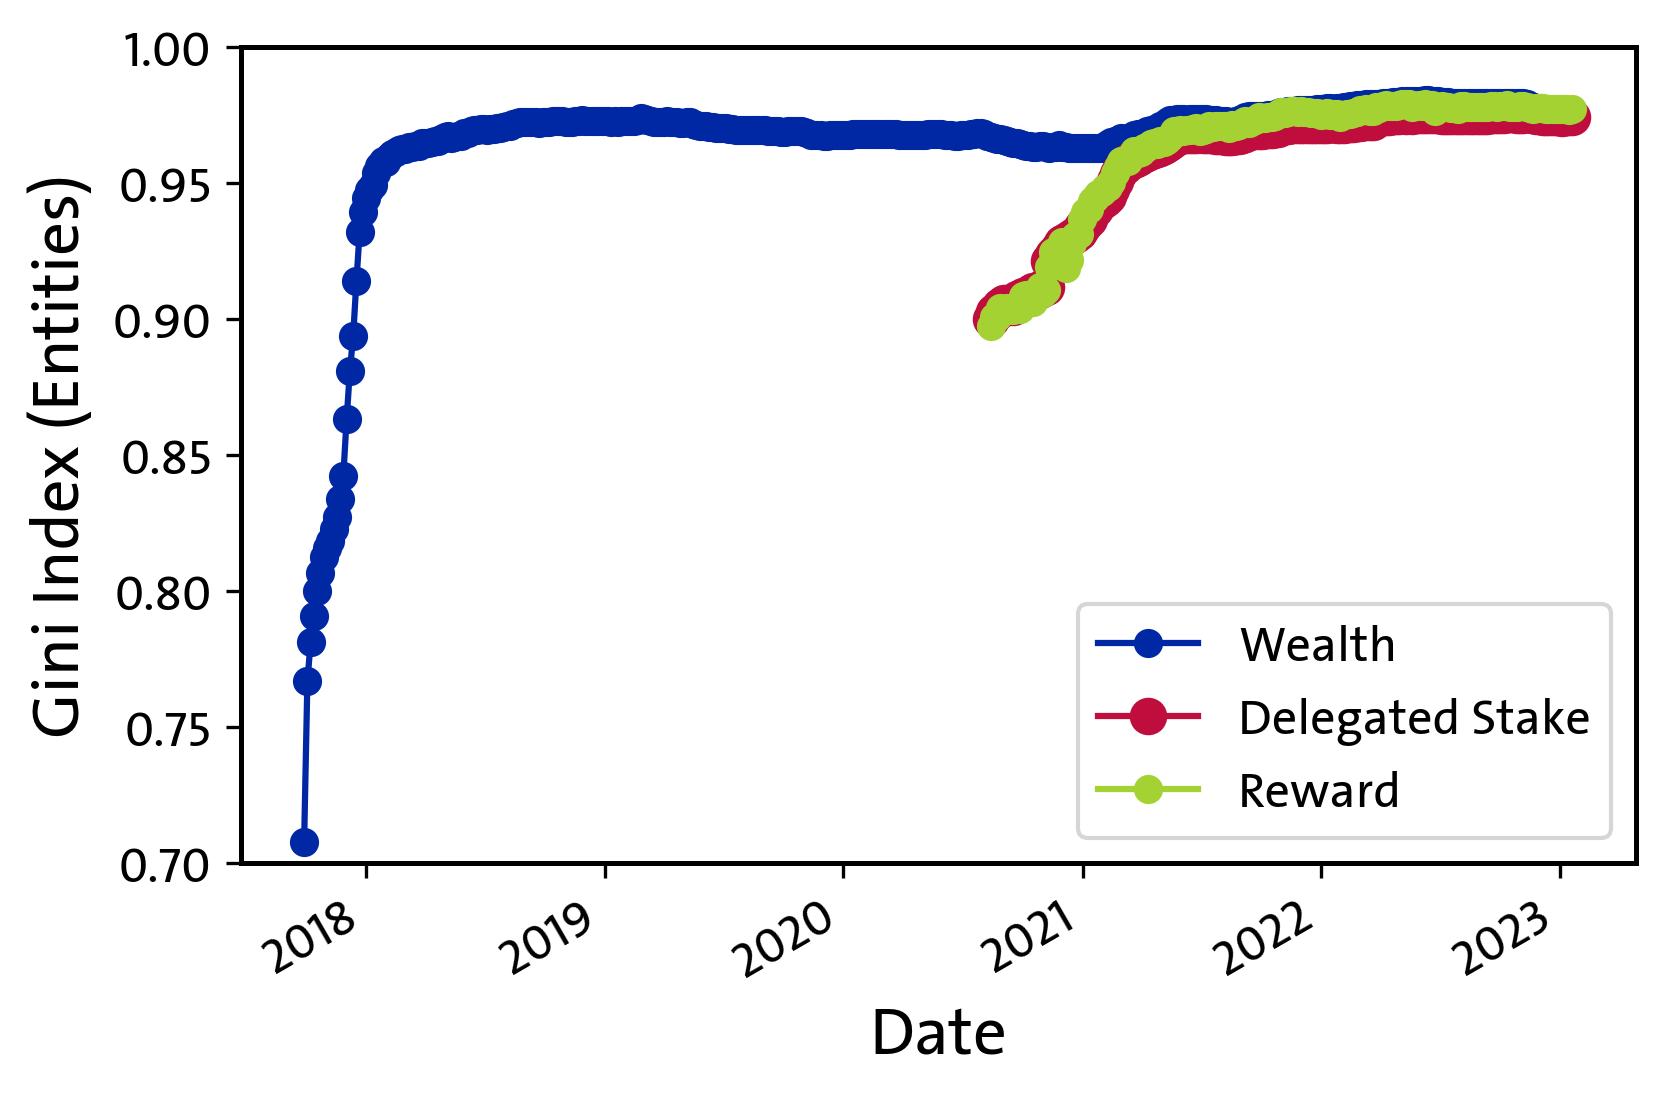

In [9]:
# Plot Gini Index of Entities (Wealth, Stake Delegation, Reward) in each epoch:

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')


#date_list = [str(INITIAL_DATE_CARDANO + datetime.timedelta(days=i)) for i in range(total_time_length_CARDANO)]
#date_list = pd.to_datetime(date_list)


first_epoch_no = 0
last_epoch_no  = 390
FIRST_DATE_CARDANO = datetime.datetime.strptime('2017-09-23 21:44:51', '%Y-%m-%d %H:%M:%S').date() # epoch_no = 0
LAST_DATE_CARDANO  = datetime.datetime.strptime('2023-01-30 21:46:16', '%Y-%m-%d %H:%M:%S').date() # epoch_no = 391


epochs_array      = list(range(first_epoch_no, last_epoch_no+1))
epochs_date_array = [0]*len(epochs_array)
for i in range(len(epochs_date_array)):
    epochs_date_array[i] = FIRST_DATE_CARDANO + datetime.timedelta(days=(i*5))


date_list = [str(epochs_date_array[i]) for i in range(1,len(epochs_date_array)-1)]
date_list = pd.to_datetime(date_list)

#date_list = epochs_date_array

DF = pd.DataFrame()
DF = pd.DataFrame(gini_index_entity_Balances [1:last_epoch_no], columns=['value1'])
DF['value2'] = pd.DataFrame(gini_index_entity_StakeDeleg [1:last_epoch_no])
DF['value3'] = pd.DataFrame(gini_index_entity_Reward     [1:last_epoch_no])


DF = DF.set_index(date_list)
plt.plot(DF['value1'], marker='o')
plt.plot(DF.loc[date_list[210]:date_list[388]].index, DF.loc[date_list[210]:date_list[388]]['value2'], marker='o', markersize=8)
plt.plot(DF.loc[date_list[210]:date_list[388]].index, DF.loc[date_list[210]:date_list[388]]['value3'], marker='o')
plt.gcf().autofmt_xdate()

# Function add a legend 
plt.legend(['Wealth', 'Delegated Stake', 'Reward'], loc ="lower right")


plt.xlabel('Date')
plt.ylabel('Gini Index (Entities)')

# linear", "log", "symlog", "logit
#plt.xscale("linear")
#plt.yscale("log")

#plt.xlim(0, 60)
plt.ylim(0.7, 1)


plt.savefig('fig_entities_giniIndex_wealth_deleg_reward.pdf', bbox_inches='tight', facecolor='white')
plt.show()



    

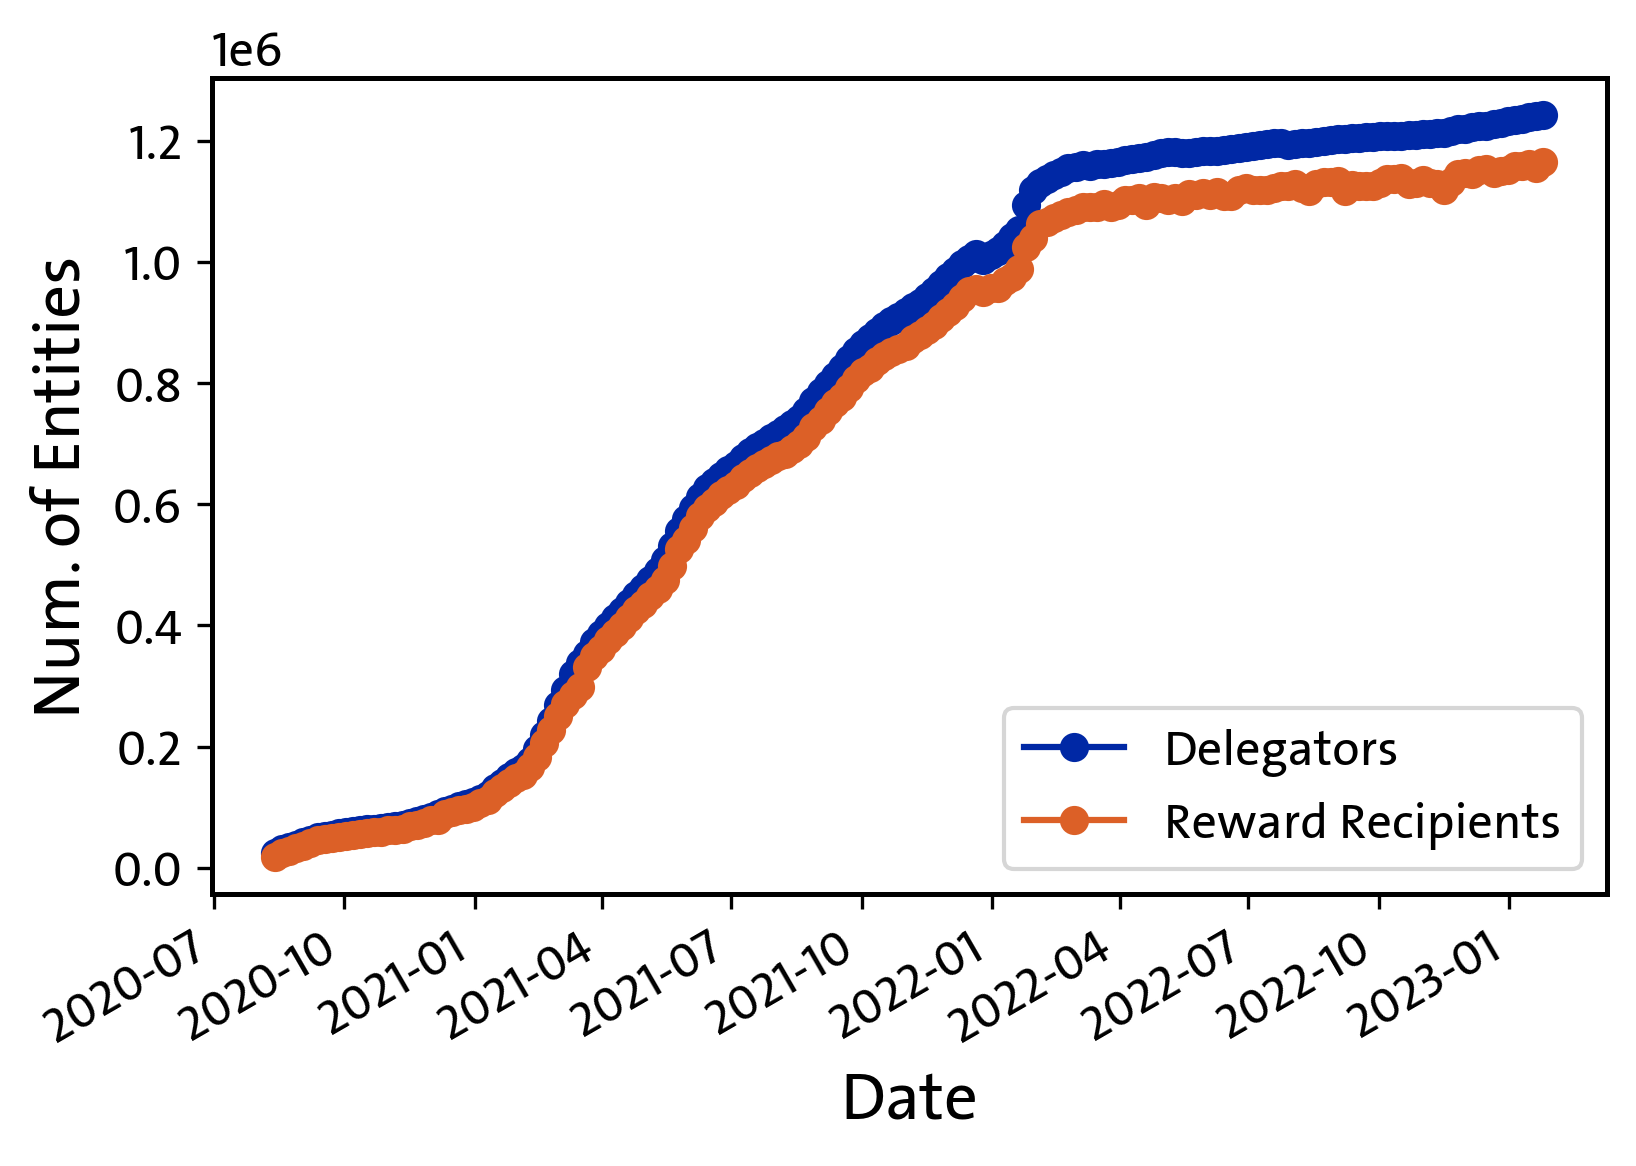

In [271]:
# Number of "Delegator/Rewardee" "Addresses/Entities" in each epoch:

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')


#date_list = [str(INITIAL_DATE_CARDANO + datetime.timedelta(days=i)) for i in range(total_time_length_CARDANO)]
#date_list = pd.to_datetime(date_list)


first_epoch_no = 210
last_epoch_no  = 391
#FIRST_DATE_CARDANO = datetime.datetime.strptime('2017-09-23 21:44:51', '%Y-%m-%d %H:%M:%S').date() # epoch_no = 0
FIRST_DATE_POOLS_STAKING = datetime.datetime.strptime('2020-08-08 21:44:51', '%Y-%m-%d %H:%M:%S').date() # epoch_no = 210
LAST_DATE_POOLS_STAKING  = datetime.datetime.strptime('2023-01-30 21:46:16', '%Y-%m-%d %H:%M:%S').date() # epoch_no = 391


epochs_array      = list(range(first_epoch_no, last_epoch_no+1))
epochs_date_array = [0]*len(epochs_array)
for i in range(len(epochs_date_array)):
    epochs_date_array[i] = FIRST_DATE_POOLS_STAKING + datetime.timedelta(days=(i*5))


date_list = [str(epochs_date_array[i]) for i in range(1,len(epochs_date_array)-1)]
date_list = pd.to_datetime(date_list)

#date_list = epochs_date_array



#file_name = BASE_ADDRESS + '/Num_Delegator_addresses_per_epoch__Cardano_TXs_All__2023-12-17_094541.txt'
#num_delegator_addresses_per_epoch = load_file_to_array(file_name)

file_name = BASE_ADDRESS + '/Num_Delegator_entities_per_epoch__Cardano_TXs_All__2023-12-17_094541.txt'
num_delegator_entities_per_epoch = load_file_to_array(file_name)

#file_name = BASE_ADDRESS + '/Num_Rewarder_addresses_per_epoch__Cardano_TXs_All__2023-12-17_132620.txt'
#num_rewarder_addresses_per_epoch = load_file_to_array(file_name)

file_name = BASE_ADDRESS + '/Num_Rewarder_entities_per_epoch__Cardano_TXs_All__2023-12-17_132620.txt'
num_rewarder_entities_per_epoch = load_file_to_array(file_name)



DF = pd.DataFrame()
DF = pd.DataFrame(num_delegator_entities_per_epoch [1:-1], columns=['value1'])
DF['value2'] = pd.DataFrame(num_rewarder_entities_per_epoch  [1:-1])


DF = DF.set_index(date_list)
plt.plot(DF['value1'], marker='o')
plt.plot(DF['value2'], marker='o')
#plt.plot(DF.loc[date_list[210]:date_list[388]].index, DF.loc[date_list[210]:date_list[388]]['value2'], marker='o', markersize=8)
#plt.plot(DF.loc[date_list[210]:date_list[388]].index, DF.loc[date_list[210]:date_list[388]]['value3'], marker='o')
plt.gcf().autofmt_xdate()

# Function add a legend 
plt.legend(['Delegators', 'Reward Recipients'], loc ="lower right")


plt.xlabel('Date')
plt.ylabel('Num. of Entities')

# linear", "log", "symlog", "logit
#plt.xscale("linear")
#plt.yscale("log")

#plt.xlim(0, 60)
#plt.ylim(0.7, 1)


plt.savefig('fig_entities_num_of_delegator_rewardee.pdf', bbox_inches='tight', facecolor='white')
plt.show()



    

  0%|          | 0/99 [00:00<?, ?it/s]/home/user/chegeni/miniconda3/envs/python_3_8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/user/chegeni/miniconda3/envs/python_3_8/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 99/99 [00:00<00:00, 2388.28it/s]


slope =  1.0566565865412065
intercept =  -3.6361683299025973
r_value =  0.9991510899771615
p_value =  9.207455722901197e-35
std_err =  0.008893049645928117


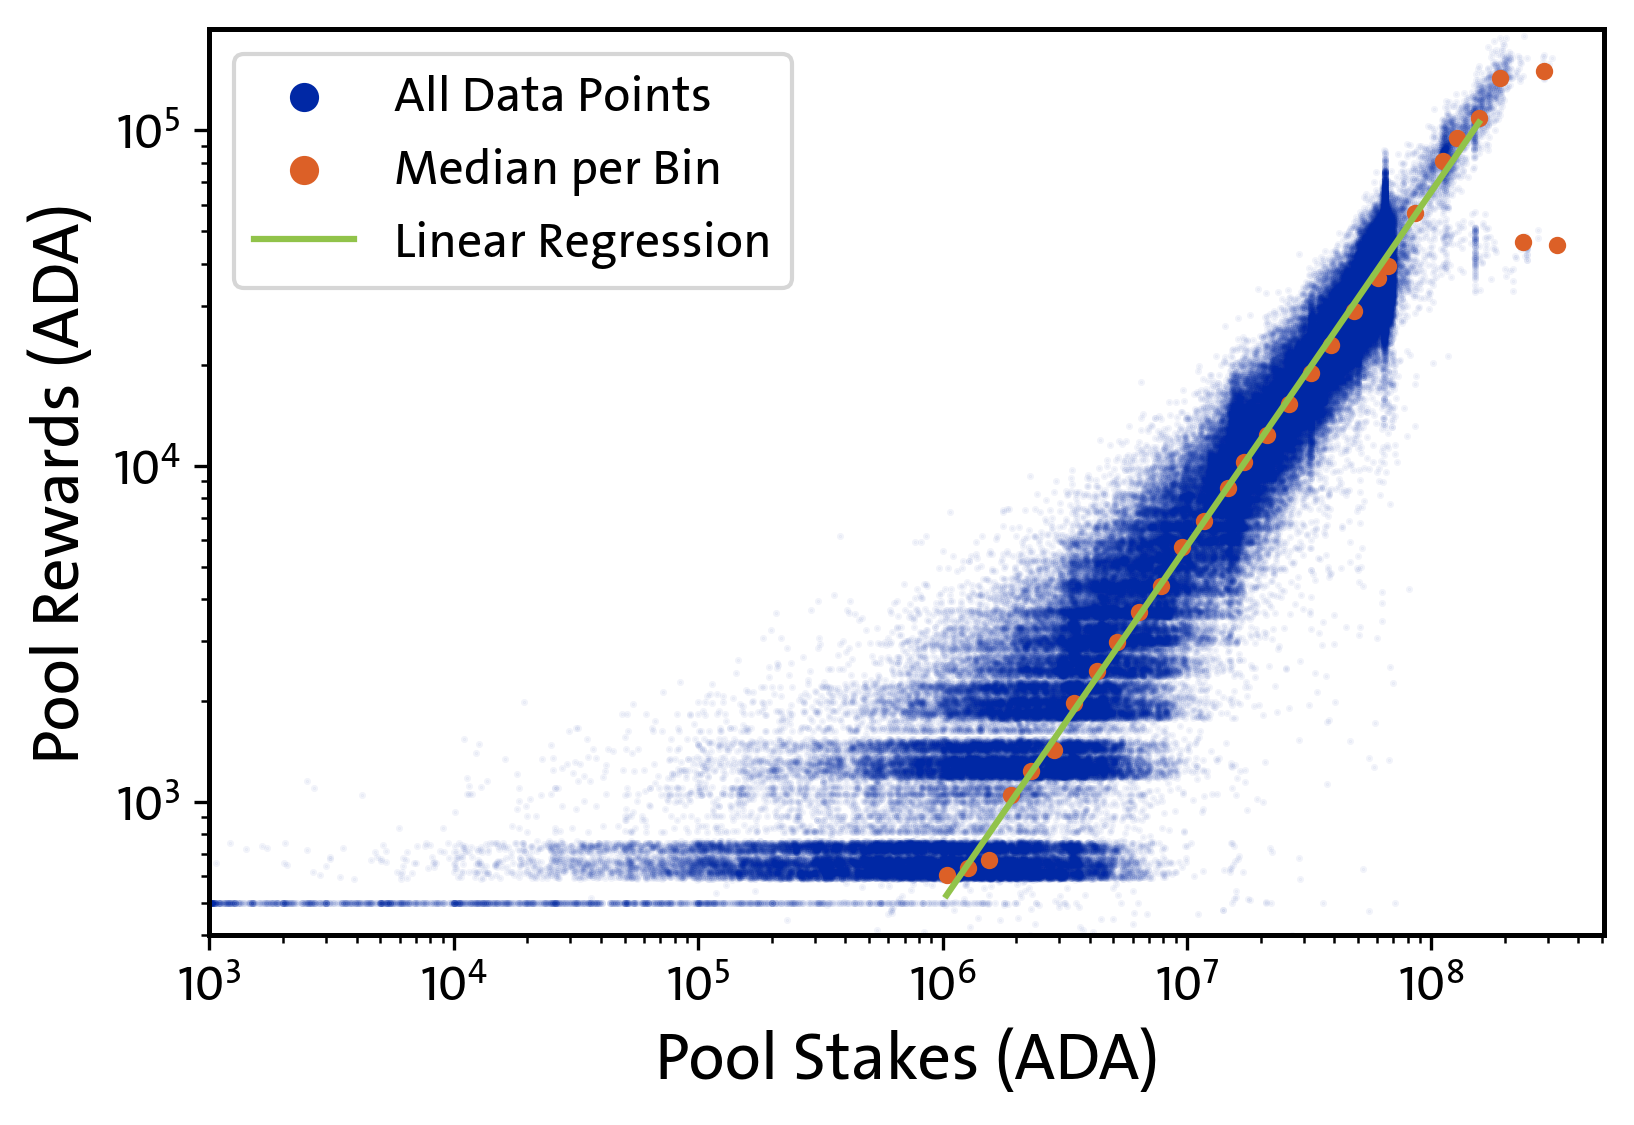

In [336]:
# Scatter Plot "Pool Rewards" vs "Pool Delegations" for all delegation events in all epochs:

from scipy.stats import linregress


import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')



file_name = BASE_ADDRESS + '/cardano_pools_4.csv'
df = pd.read_csv(file_name, delimiter='|')

x = df['POOL_STAKES']
y = df['POOL_REWARDS']


x = np.array(x, dtype=np.float64)
x = x/(10**6)  # convert lovelace to ADA
y = np.array(y, dtype=np.float64)
y = y/(10**6) # convert lovelace to ADA



# Replace zeros in y with a very small number
small_number = 1e-6
x[x == 0] = small_number
y[y == 0] = small_number


# Transforming data to log space
log_x = np.log10(x)
log_y = np.log10(y)

# Define bin edges in log space
bin_edges_x = np.logspace(0.01, np.max(log_x), 100)
#bin_edges_y = np.logspace(np.min(log_y), np.max(log_y), 100)

# Digitize/assign each point to a bin
bin_indices_x = np.digitize(log_x, bins=np.log10(bin_edges_x))
#bin_indices_y = np.digitize(log_y, bins=np.log10(bin_edges_y))


# Calculate mean/median in each bin
binned_data = []
for i in tqdm(range(1, len(bin_edges_x))):
    #for j in range(1, len(bin_edges_y)):
        # Find indices for each bin separately
        indices_x = np.where(bin_indices_x == i)
        #indices_y = np.where(bin_indices_y == j)
        
        # Find common indices
        #common_indices = np.intersect1d(indices_x, indices_y)

        if len(indices_x) > 0:
            median_x = np.median(x[indices_x])
            median_y = np.median(y[indices_x])
            binned_data.append((median_x, median_y))



# Extract binned data for plotting
binned_x, binned_y = zip(*binned_data)

# Perform linear regression
log_reg_x = np.log10(binned_x[68:94])
log_reg_y = np.log10(binned_y[68:94])
slope, intercept, r_value, p_value, std_err = linregress(log_reg_x, log_reg_y)
print('slope = ',     slope)
print('intercept = ', intercept)
print('r_value = ',   r_value)
print('p_value = ',   p_value)
print('std_err = ',   std_err)


# Create a figure and axis
fig, ax = plt.subplots()


# Create a scatter plot
scatter_plot1  = plt.scatter(x, y,               label='Scatter Plot', marker='o', s=0.5, alpha=0.05)
scatter_plot2  = plt.scatter(binned_x, binned_y, label='Scatter Plot', marker='o', s=10,  alpha=1)
plt.plot([], [])
plt.plot([], [])
plot3,         = plt.plot(10**log_reg_x, (10**intercept) * ((10**log_reg_x)**slope), label='Fitted Line')


#plt.legend(['All Data Points', 'Median per Bin'], handles=[legend_scatter], fontsize=8, loc ="lower right")
legend_scatter1 = plt.scatter([], [], alpha=1, color=scatter_plot1.get_facecolor()[0], label='All Data Points')
legend_scatter2 = plt.scatter([], [], alpha=1, color=scatter_plot2.get_facecolor()[0], label='Median per Bin')
legend_plot3    = plt.Line2D([], [], color=plot3.get_color(), label='Linear Regression')
plt.legend(handles=[legend_scatter1, legend_scatter2, legend_plot3], loc ="upper left")
legend_scatter1.remove()
legend_scatter2.remove()
#plt.legend(['Active Pools', 'Rewarded Pools'], loc ="lower right")




plt.xlabel('Pool Stakes (ADA)')
plt.ylabel('Pool Rewards (ADA)')


plt.xlim(left=1000)   #, int(10 * 10**6))
plt.ylim(bottom=400) #, int(10 * 10**6))

plt.xscale('log')
plt.yscale('log')


# Show the plot
plt.savefig('fig_entities_poolsReward_vs_poolsDelegation.png', bbox_inches='tight', facecolor='white')
plt.show()




In [223]:
# Calculate "Pool Delegation"                                              vs "Entity Wealth" for all delegation events in all epochs:
# Calculate "Number of Pools received Delegation from an Entity per epoch" vs "Entity Wealth" for all delegation events in all epochs:


from collections import defaultdict

print('----------------------')

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)
print('----------------------')



first_epoch_no = 210
last_epoch_no  = 391
FIRST_DATE_POOLS_STAKING = datetime.datetime.strptime('2020-08-08 21:44:51', '%Y-%m-%d %H:%M:%S').date() # epoch_no = 210
LAST_DATE_POOLS_STAKING  = datetime.datetime.strptime('2023-01-30 21:46:16', '%Y-%m-%d %H:%M:%S').date() # epoch_no = 391



#total_num_of_epochs = int(int((LAST_DATE_POOLS_STAKING - FIRST_DATE_POOLS_STAKING).total_seconds()/86400)/5) + 1
total_num_of_epochs = int(last_epoch_no - first_epoch_no + 1)

epochs_array      = list(range(first_epoch_no, last_epoch_no+1))
epochs_date_array = [0]*len(epochs_array)
for i in range(len(epochs_date_array)):
    epochs_date_array[i] = FIRST_DATE_POOLS_STAKING + datetime.timedelta(days=(i*5))




file_name = BASE_ADDRESS + '/cardano_pools_4.csv'
df = pd.read_csv(file_name, delimiter='|')


clustering_array = clustering_array_heur1and2
current_epoch    = first_epoch_no

current_day      = current_epoch * 5
file_name = BASE_ADDRESS + '/YuZhang_Cardano_Balances_Entities/BalancesPerEntityDay_' + str(current_day).zfill(4) + '__Cardano_TXs_All.txt'
entities_wealth_per_epoch = load_file_to_array(file_name)



entityWealth_to_poolStake_delegationEvents_ALL      = []
entityWealth_to_poolStake_delegationEvents_perEpoch = []

entity_to_numOf_pool_deleg_AllEvents = []
entity_to_pool_deleg_perEpoch        = []

rewarded_entities_perEpoch  = []
rewarded_entities_AllEvents = []



for index, row in tqdm(df.iterrows()):
    ##########################################################################################
    EPOCH             = int(  df.loc[index ,  'EPOCH']             )
    POOL_ID           = int(  df.loc[index ,  'POOL_ID']           )
    POOL_HASH_BECH32  =       df.loc[index ,  'POOL_HASH_BECH32']
    POOL_STAKES       = int(  df.loc[index ,  'POOL_STAKES']       )
    POOL_REWARDS      = int(  df.loc[index ,  'POOL_REWARDS']      )
    NUM_OF_DELEGATORS = int(  df.loc[index ,  'NUM_OF_DELEGATORS'] )
    NUM_OF_REWARDERS  = int(  df.loc[index ,  'NUM_OF_REWARDERS']  )
    DELEGATORs        = list( df.loc[index , 'DELEGATORs'].split(';') )
    if(not pd.isna(df.loc[index, 'REWARDERs'])):
        REWARDERs     = list( df.loc[index , 'REWARDERs'].split(';') )
    else:
        REWARDERs     = list()

    ##########################################################################################
    if(EPOCH < first_epoch_no):
        continue;
    ##########################################################################################
    if(EPOCH > current_epoch):
        entityWealth_to_poolStake_delegationEvents_ALL.extend(entityWealth_to_poolStake_delegationEvents_perEpoch)
        entityWealth_to_poolStake_delegationEvents_perEpoch = []
        
        entity_pools = defaultdict(set)
        for entity_indx, pool_id in entity_to_pool_deleg_perEpoch:
            entity_pools[entity_indx].add(pool_id)
        entity_to_numOf_pool_deleg_AllEvents.extend([(entities_wealth_per_epoch[entity_indx][0], len(pools)) for entity_indx, pools in entity_pools.items()])
        entity_to_pool_deleg_perEpoch = []

        entity_rewards = defaultdict(set)
        for entity_indx, reward_amount in rewarded_entities_perEpoch:
            entity_rewards[entity_indx].add(reward_amount)
        rewarded_entities_AllEvents.extend([(entities_wealth_per_epoch[entity_indx][0], sum(reward_amounts)) for entity_indx, reward_amounts in entity_rewards.items()])
        rewarded_entities_perEpoch = []

        current_epoch      = EPOCH
        
        current_day        = current_epoch * 5
        if(current_day <= 1945):
            file_name = BASE_ADDRESS + '/YuZhang_Cardano_Balances_Entities/BalancesPerEntityDay_' + str(current_day).zfill(4) + '__Cardano_TXs_All.txt'
            entities_wealth_per_epoch = load_file_to_array(file_name)


    ##########################################################################################
    if(EPOCH > last_epoch_no):
        break;

    ##########################################################################################
    delegator_entities_to_this_pool_per_epoch_SET  = set()
    
    for delegator in DELEGATORs:
        #temp_str          = delegator.split(',')
        deleg_addr_id     =      delegator.split(',')[0]
        deleg_amount      = int( delegator.split(',')[1] )
        deleg_stake_addr  =      delegator.split(',')[2]
        
        deleg_addr_indx   = BinarySearch(unique_delegation_addresses, deleg_stake_addr, debug=False)
        if(deleg_addr_indx != -1):
            deleg_entity_indx = entity_of_stake_addresses[deleg_addr_indx][0]        
            delegator_entities_to_this_pool_per_epoch_SET.add(deleg_entity_indx)

    for entity_indx in delegator_entities_to_this_pool_per_epoch_SET:
        if (entity_indx < len(entities_wealth_per_epoch)):
            entityWealth_to_poolStake_delegationEvents_perEpoch.append((entities_wealth_per_epoch[entity_indx][0], POOL_STAKES))
            entity_to_pool_deleg_perEpoch.append((entity_indx, POOL_ID))
            


    
    for rewarder in REWARDERs:
        #temp_str          = rewarder.split(',')
        reward_addr_id    =      rewarder.split(',')[0]
        reward_amount     = int( rewarder.split(',')[1] )
        reward_stake_addr =      rewarder.split(',')[2]
     
        reward_addr_indx   = BinarySearch(unique_delegation_addresses, reward_stake_addr, debug=False)
        if(reward_addr_indx != -1):
            reward_entity_indx = entity_of_stake_addresses[reward_addr_indx][0]
            if (reward_entity_indx < len(entities_wealth_per_epoch)):
                rewarded_entities_perEpoch.append((reward_entity_indx, reward_amount))

    ##########################################################################################
    #active_delegator_addresses_per_epoch[EPOCH - first_epoch_no] = active_delegator_addresses_per_epoch[EPOCH - first_epoch_no] + NUM_OF_DELEGATORS

    ##########################################################################################




et = datetime.datetime.now() - ct
print("Total elapsed time: ", et)
print('----------------------')
print('done!')




----------------------
current time:  2023-12-18 11:12:27.700476
----------------------


471282it [2:46:53, 47.07it/s]  

Total elapsed time:  2:46:53.503799
----------------------
done!


In [226]:
# Store/Load "entityWealth_to_poolStake_delegationEvents_ALL" and "entity_to_numOf_pool_deleg_AllEvents":


import pickle
print('----------------------')
ct = datetime.datetime.now()
curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]



# Store file:
'''
output_filename = BASE_ADDRESS + '/DelegEvents__entityWealth_poolStakes_pairs__AllEpochs__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
with open(output_filename, 'wb') as file:
    pickle.dump(entityWealth_to_poolStake_delegationEvents_ALL, file)


output_filename = BASE_ADDRESS + '/DelegEvents__entityWealth_numOfPools_pairs__AllEpochs__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
with open(output_filename, 'wb') as file:
    pickle.dump(entity_to_numOf_pool_deleg_AllEvents, file)


output_filename = BASE_ADDRESS + '/DelegEvents__entityWealth_rewardAmount_pairs__AllEpochs__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
with open(output_filename, 'wb') as file:
    pickle.dump(rewarded_entities_AllEvents, file)
'''




# Load file:

filename = BASE_ADDRESS + '/DelegEvents__entityWealth_poolStakes_pairs__AllEpochs__2023-12-18_043529.txt'
with open(filename, 'rb') as file:
    entityWealth_to_poolStake_delegationEvents_ALL = pickle.load(file)


filename = BASE_ADDRESS + '/DelegEvents__entityWealth_numOfPools_pairs__AllEpochs__2023-12-18_043529.txt'
with open(filename, 'rb') as file:
    entity_to_numOf_pool_deleg_AllEvents = pickle.load(file)


filename = BASE_ADDRESS + '/DelegEvents__entityWealth_rewardAmount_pairs__AllEpochs__2023-12-18_142414.txt'
with open(filename, 'rb') as file:
    rewarded_entities_AllEvents = pickle.load(file)



##########################################################################################
print('----------------------')
print('done!')



----------------------
output_filename =  /local/scratch/exported/Cardano_MCH_2023_1//DelegEvents__entityWealth_rewardAmount_pairs__AllEpochs__2023-12-18_142414.txt
----------------------
done!


----------------------
----------------------


100%|██████████| 99/99 [00:15<00:00,  6.40it/s]


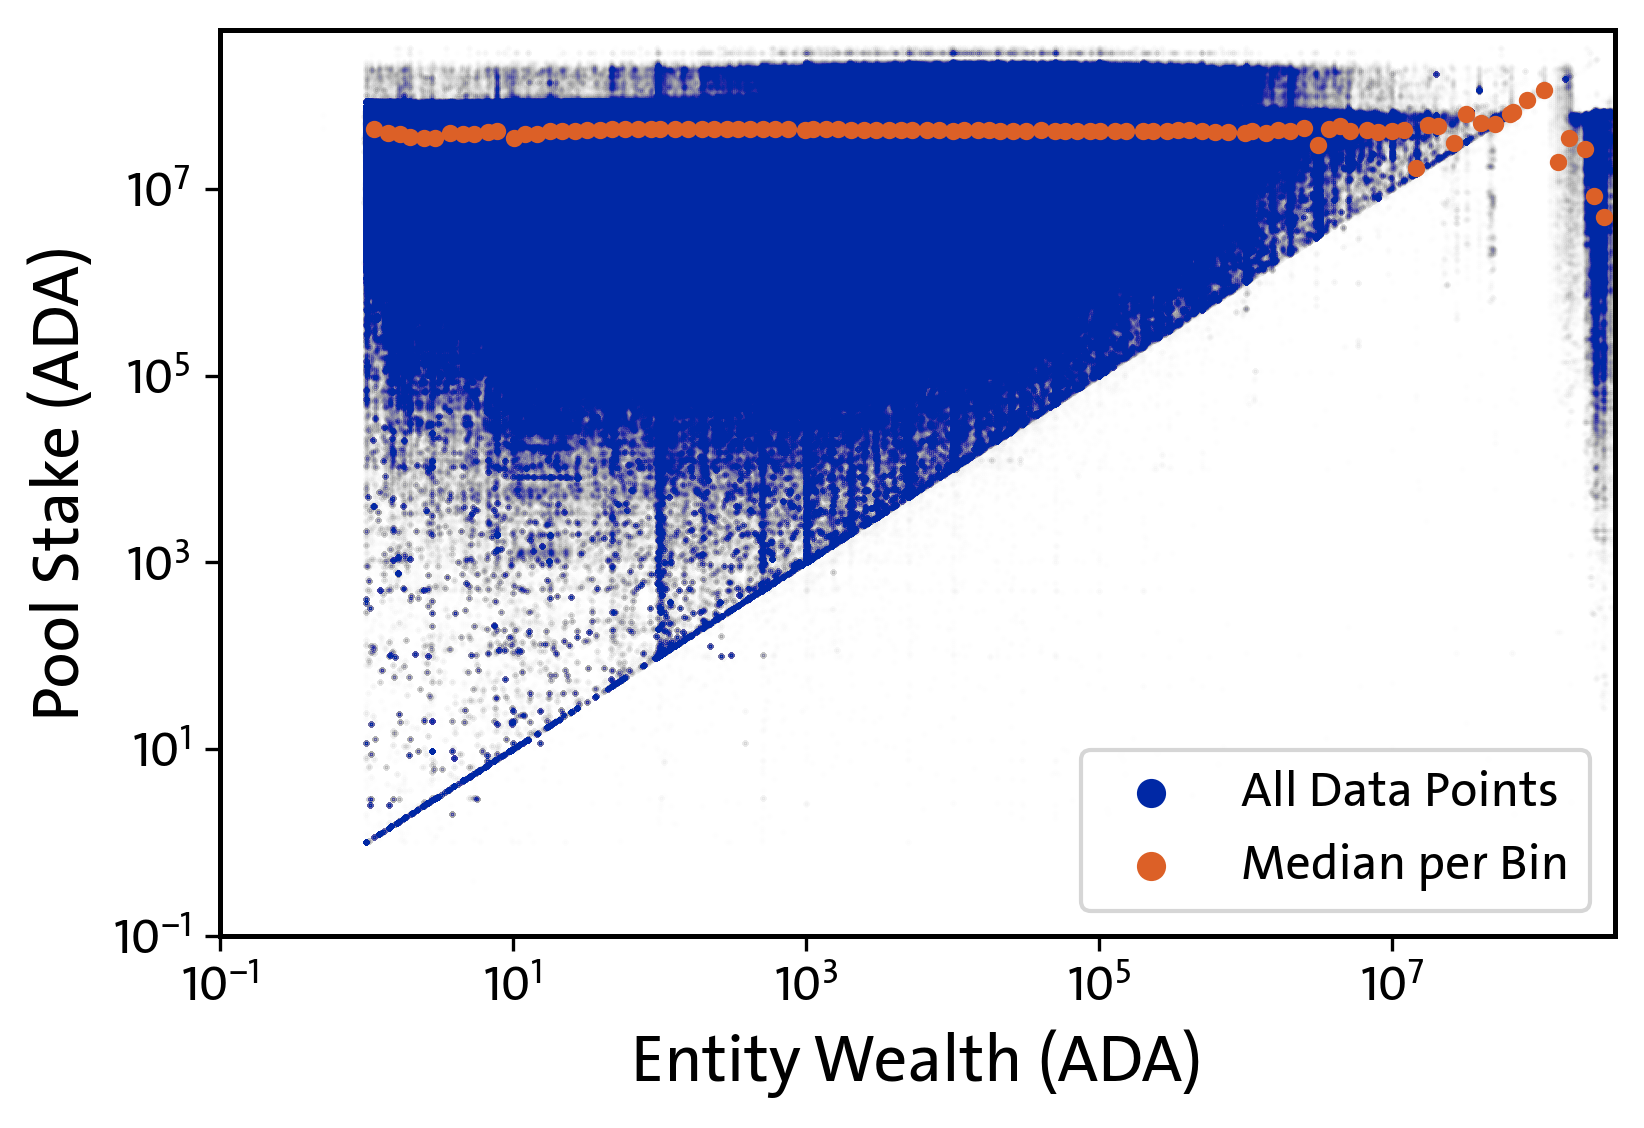

In [246]:
# Scatter Plot "Pool Delegation" vs "Entity Wealth" for all delegation events in all epochs:

import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')


##########################################################################################
print('----------------------')
print('----------------------')

# Unzip the list of pairs into two lists with the zip function
x, y = zip(*entityWealth_to_poolStake_delegationEvents_ALL)

x = np.array(x, dtype=np.float64)
x = x/(10**6)  # convert lovelace to ADA
y = np.array(y, dtype=np.float64)
y = y/(10**6) # convert lovelace to ADA



# Replace zeros in y with a very small number
small_number = 1e-6
x[x == 0] = small_number
y[y == 0] = small_number


# Transforming data to log space
log_x = np.log10(x)
log_y = np.log10(y)

# Define bin edges in log space
bin_edges_x = np.logspace(0.01, np.max(log_x), 100)
#bin_edges_y = np.logspace(np.min(log_y), np.max(log_y), 100)

# Digitize/assign each point to a bin
bin_indices_x = np.digitize(log_x, bins=np.log10(bin_edges_x))
#bin_indices_y = np.digitize(log_y, bins=np.log10(bin_edges_y))


# Calculate mean/median in each bin
binned_data = []
for i in tqdm(range(1, len(bin_edges_x))):
    #for j in range(1, len(bin_edges_y)):
        # Find indices for each bin separately
        indices_x = np.where(bin_indices_x == i)
        #indices_y = np.where(bin_indices_y == j)
        
        # Find common indices
        #common_indices = np.intersect1d(indices_x, indices_y)

        if len(indices_x) > 0:
            median_x = np.median(x[indices_x])
            median_y = np.median(y[indices_x])
            binned_data.append((median_x, median_y))



# Extract binned data for plotting
binned_x, binned_y = zip(*binned_data)




# Create a figure and axis
fig, ax = plt.subplots()


# Create a scatter plot
scatter_plot1 = plt.scatter(x, y,               label='Scatter Plot', marker='o', s=0.5, alpha=0.002)
scatter_plot2 = plt.scatter(binned_x, binned_y, label='Scatter Plot', marker='o', s=10,  alpha=1)


#plt.legend(['All Data Points', 'Median per Bin'], handles=[legend_scatter], fontsize=8, loc ="lower right")
legend_scatter1 = plt.scatter([], [], alpha=1, color=scatter_plot1.get_facecolor()[0], label='All Data Points')
legend_scatter2 = plt.scatter([], [], alpha=1, color=scatter_plot2.get_facecolor()[0], label='Median per Bin')
plt.legend(handles=[legend_scatter1, legend_scatter2], loc ="lower right")
legend_scatter1.remove()
legend_scatter2.remove()
#plt.legend(['Active Pools', 'Rewarded Pools'], loc ="lower right")




plt.xlabel('Entity Wealth (ADA)')
plt.ylabel('Pool Stake (ADA)')


plt.xlim(left=0.1)   #, int(10 * 10**6))
plt.ylim(bottom=0.1) #, int(10 * 10**6))

plt.xscale('log')
plt.yscale('log')


# Show the plot
plt.savefig('fig_entities_poolsDeleg_vs_entityWealth.png', bbox_inches='tight', facecolor='white')
plt.show()




----------------------
----------------------


100%|██████████| 99/99 [00:14<00:00,  6.60it/s]


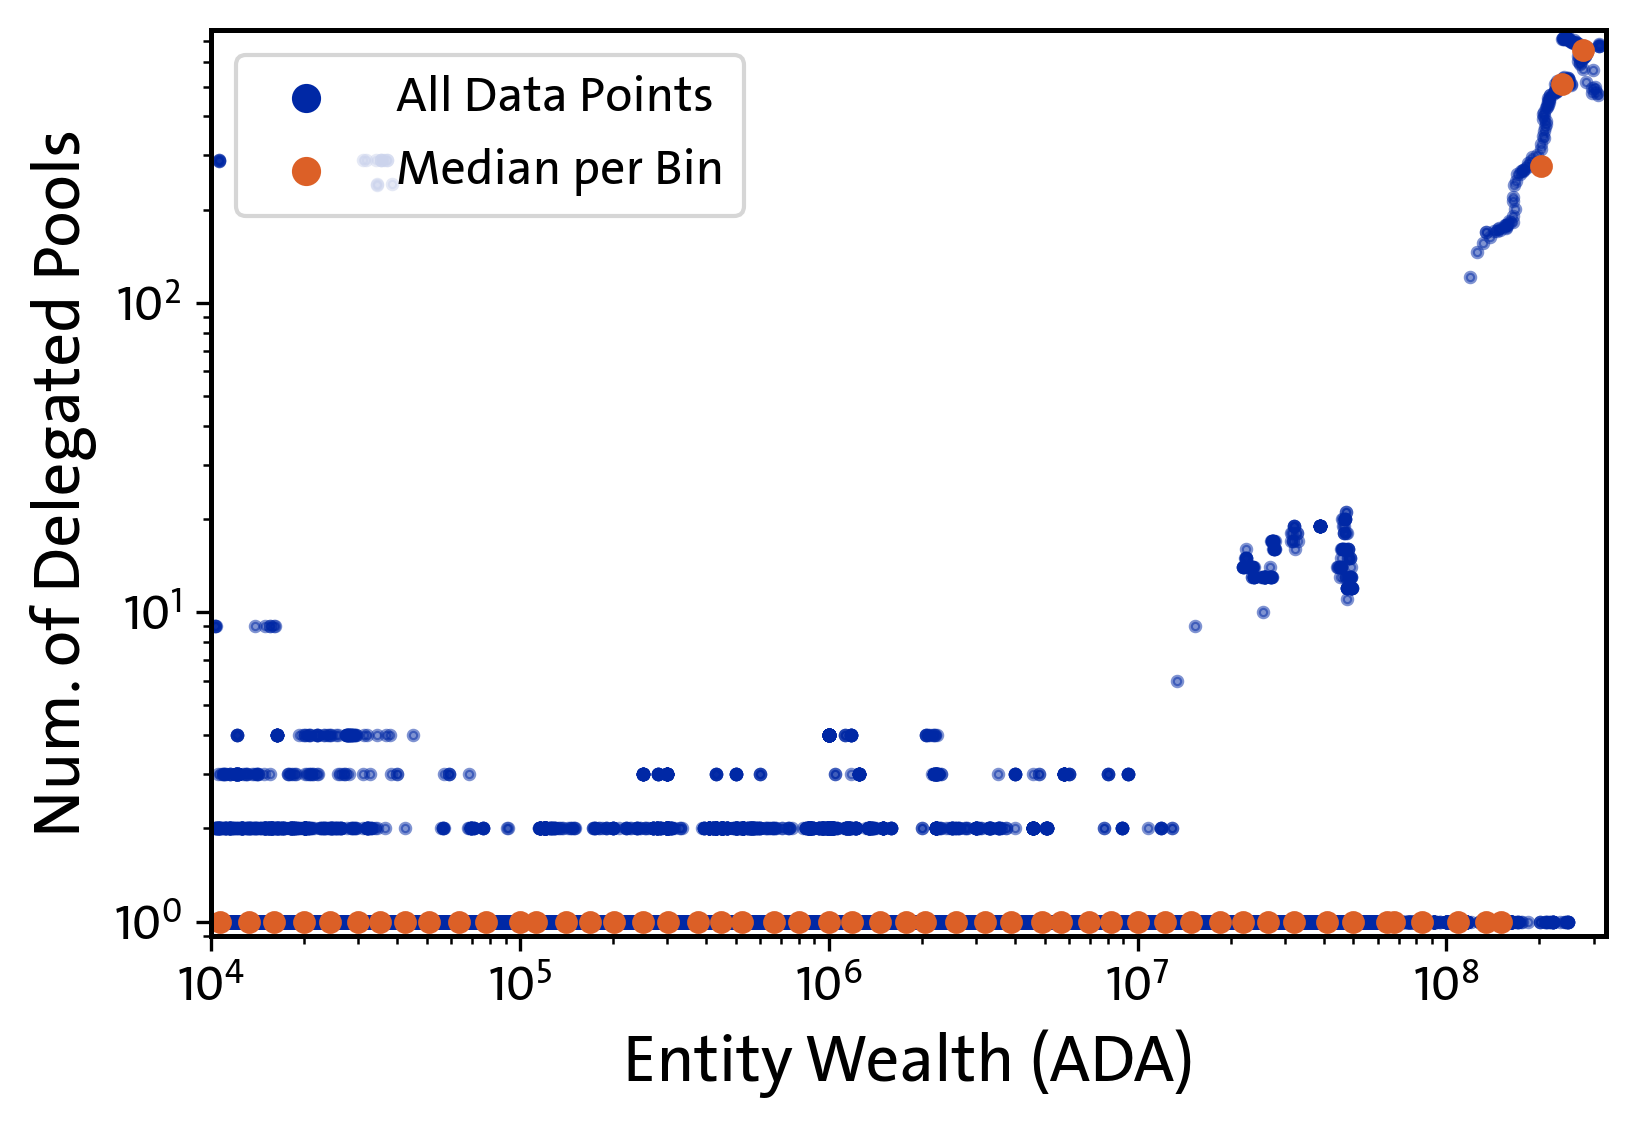

In [280]:
# Scatter Plot "Number of Pools received Delegation from an Entity per epoch" vs "Entity Wealth" for all delegation events in all epochs:

import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')


##########################################################################################
print('----------------------')
print('----------------------')

# Unzip the list of pairs into two lists with the zip function
x, y = zip(*entity_to_numOf_pool_deleg_AllEvents)

x = np.array(x, dtype=np.float64)
x = x/(10**6)  # convert lovelace to ADA
y = np.array(y, dtype=np.float64)
#y = y/(10**6) # convert lovelace to ADA



# Replace zeros in y with a very small number
small_number = 1e-6
x[x == 0] = small_number
y[y == 0] = small_number


# Transforming data to log space
log_x = np.log10(x)
log_y = np.log10(y)

# Define bin edges in log space
bin_edges_x = np.logspace(0.1, np.max(log_x), 100)
#bin_edges_y = np.logspace(np.min(log_y), np.max(log_y), 100)

# Digitize/assign each point to a bin
bin_indices_x = np.digitize(log_x, bins=np.log10(bin_edges_x))
#bin_indices_y = np.digitize(log_y, bins=np.log10(bin_edges_y))


# Calculate mean/median in each bin
binned_data = []
for i in tqdm(range(1, len(bin_edges_x))):
    #for j in range(1, len(bin_edges_y)):
        # Find indices for each bin separately
        indices_x = np.where(bin_indices_x == i)
        #indices_y = np.where(bin_indices_y == j)
        
        # Find common indices
        #common_indices = np.intersect1d(indices_x, indices_y)

        if len(indices_x) > 0:
            median_x = np.median(x[indices_x])
            median_y = np.median(y[indices_x])
            binned_data.append((median_x, median_y))



# Extract binned data for plotting
binned_x, binned_y = zip(*binned_data)




# Create a figure and axis
fig, ax = plt.subplots()


# Create a scatter plot
scatter_plot1 = plt.scatter(x, y,               label='Scatter Plot', marker='o', s=5, alpha=0.5)
scatter_plot2 = plt.scatter(binned_x, binned_y, label='Scatter Plot', marker='o', s=20,  alpha=1)


#plt.legend(['All Data Points', 'Median per Bin'], handles=[legend_scatter], fontsize=8, loc ="lower right")
legend_scatter1 = plt.scatter([], [], alpha=1, color=scatter_plot1.get_facecolor()[0], label='All Data Points')
legend_scatter2 = plt.scatter([], [], alpha=1, color=scatter_plot2.get_facecolor()[0], label='Median per Bin')
plt.legend(handles=[legend_scatter1, legend_scatter2], loc ="upper left")
legend_scatter1.remove()
legend_scatter2.remove()
#plt.legend(['Active Pools', 'Rewarded Pools'], loc ="lower right")




plt.xlabel('Entity Wealth (ADA)')
plt.ylabel('Num. of Delegated Pools')


plt.xlim(left=10**4) #, int(10 * 10**6))
plt.ylim(bottom=0.9) #, int(10 * 10**6))

plt.xscale('log')
plt.yscale('log')


# Show the plot
plt.savefig('fig_entities_poolsNumber_vs_entityWealth.png', bbox_inches='tight', facecolor='white')
plt.show()




----------------------
----------------------


100%|██████████| 99/99 [00:14<00:00,  6.76it/s]


slope =  1.0019868731854313
intercept =  -3.2417994804877823
r_value =  0.9998889556952519
p_value =  3.4819694709014325e-177
std_err =  0.0015241430488111818


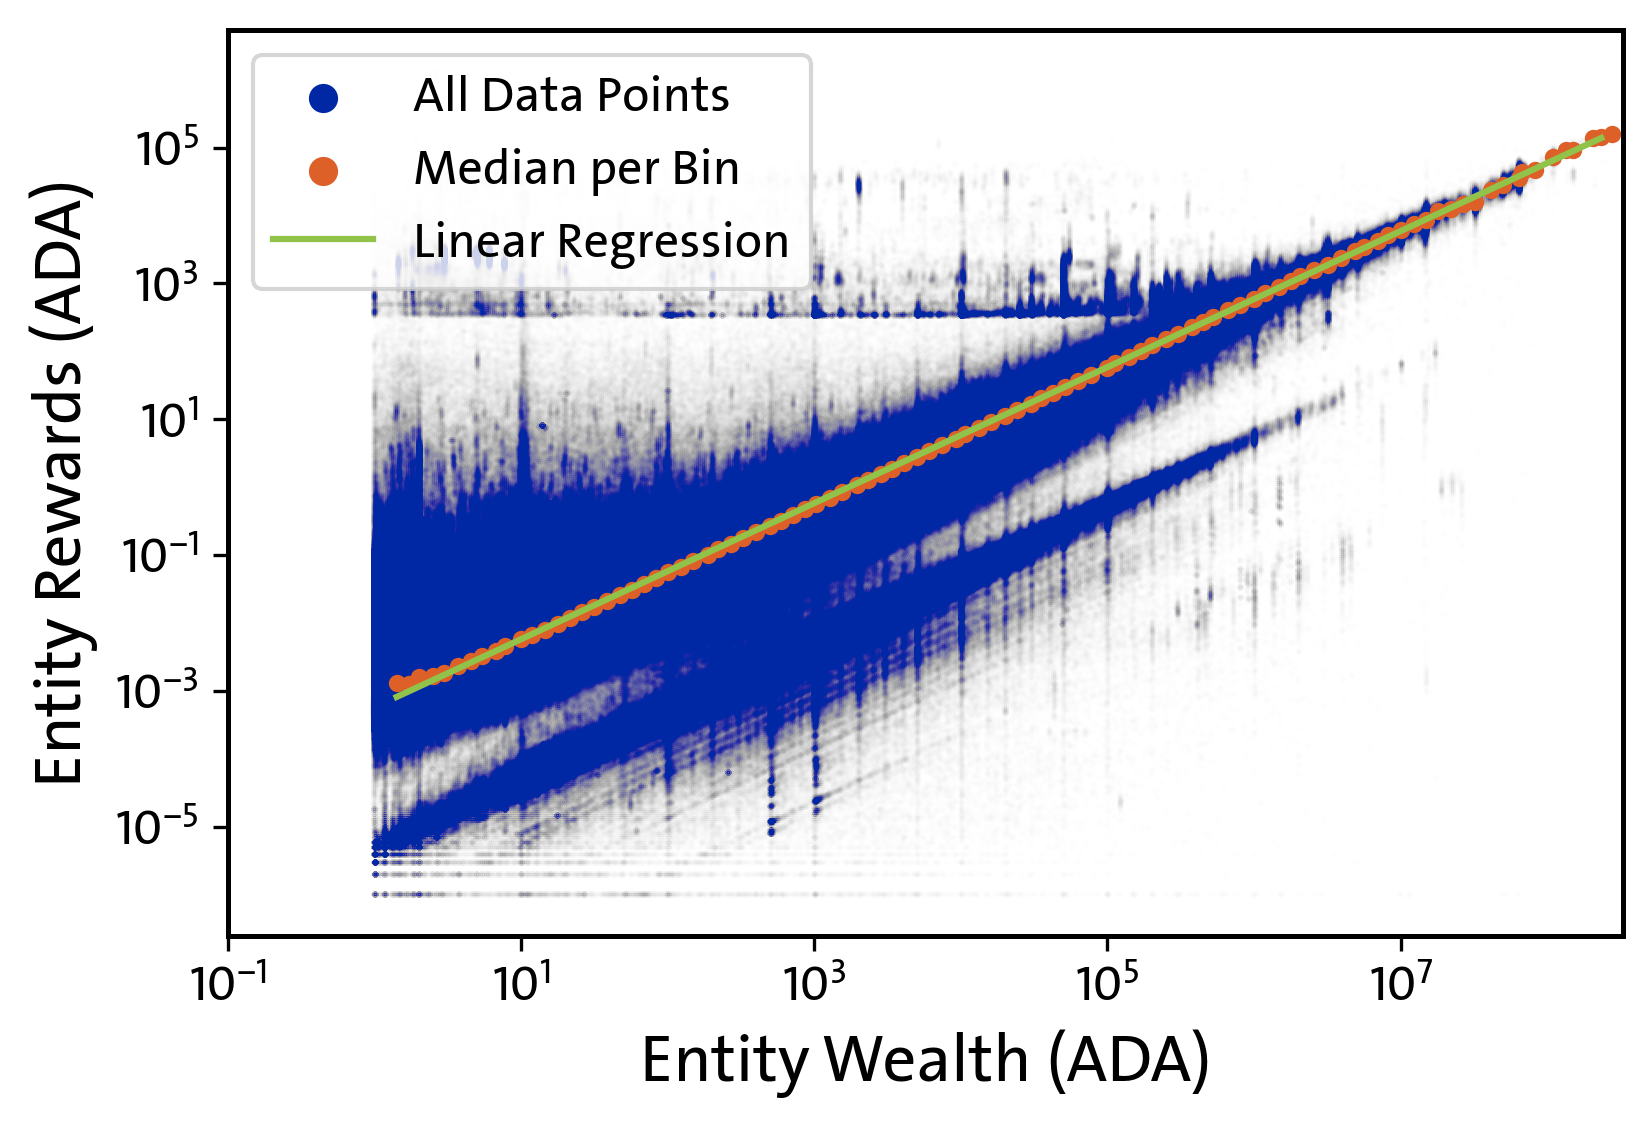

In [341]:
# Scatter Plot "Reward per epoch" vs "Entity Wealth" for all delegation events in all epochs:

import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')


##########################################################################################
print('----------------------')
print('----------------------')


# Unzip the list of pairs into two lists with the zip function
x, y = zip(*rewarded_entities_AllEvents)

x = np.array(x, dtype=np.float64)
x = x/(10**6)  # convert lovelace to ADA
y = np.array(y, dtype=np.float64)
y = y/(10**6)  # convert lovelace to ADA



# Replace zeros in y with a very small number
small_number = 1e-6
x[x == 0] = small_number
y[y == 0] = small_number


# Transforming data to log space
log_x = np.log10(x)
log_y = np.log10(y)

# Define bin edges in log space
bin_edges_x = np.logspace(0.1, np.max(log_x), 100)
#bin_edges_y = np.logspace(np.min(log_y), np.max(log_y), 100)

# Digitize/assign each point to a bin
bin_indices_x = np.digitize(log_x, bins=np.log10(bin_edges_x))
#bin_indices_y = np.digitize(log_y, bins=np.log10(bin_edges_y))


# Calculate mean/median in each bin
binned_data = []
for i in tqdm(range(1, len(bin_edges_x))):
    #for j in range(1, len(bin_edges_y)):
        # Find indices for each bin separately
        indices_x = np.where(bin_indices_x == i)
        #indices_y = np.where(bin_indices_y == j)
        
        # Find common indices
        #common_indices = np.intersect1d(indices_x, indices_y)

        if len(indices_x) > 0:
            median_x = np.median(x[indices_x])
            median_y = np.median(y[indices_x])
            binned_data.append((median_x, median_y))



# Extract binned data for plotting
binned_x, binned_y = zip(*binned_data)



# Perform linear regression
log_reg_x = np.log10(binned_x[0:-1])
log_reg_y = np.log10(binned_y[0:-1])
slope, intercept, r_value, p_value, std_err = linregress(log_reg_x, log_reg_y)
print('slope = ',     slope)
print('intercept = ', intercept)
print('r_value = ',   r_value)
print('p_value = ',   p_value)
print('std_err = ',   std_err)


# Create a figure and axis
fig, ax = plt.subplots()


# Create a scatter plot
scatter_plot1 = plt.scatter(x, y,               label='Scatter Plot', marker='o', s=0.5, alpha=0.002)
scatter_plot2 = plt.scatter(binned_x, binned_y, label='Scatter Plot', marker='o', s=10,  alpha=1)
plt.plot([], [])
plt.plot([], [])
plot3,         = plt.plot(10**log_reg_x, (10**intercept) * ((10**log_reg_x)**slope), label='Fitted Line')


#plt.legend(['All Data Points', 'Median per Bin'], handles=[legend_scatter], fontsize=8, loc ="lower right")
legend_scatter1 = plt.scatter([], [], alpha=1, color=scatter_plot1.get_facecolor()[0], label='All Data Points')
legend_scatter2 = plt.scatter([], [], alpha=1, color=scatter_plot2.get_facecolor()[0], label='Median per Bin')
legend_plot3    = plt.Line2D([], [], color=plot3.get_color(), label='Linear Regression')
plt.legend(handles=[legend_scatter1, legend_scatter2, legend_plot3], loc ="upper left")
legend_scatter1.remove()
legend_scatter2.remove()
#plt.legend(['Active Pools', 'Rewarded Pools'], loc ="lower right")





plt.xlabel('Entity Wealth (ADA)')
plt.ylabel('Entity Rewards (ADA)')


plt.xlim(left=0.1) #, int(10 * 10**6))
#plt.ylim(bottom=0.1) #, int(10 * 10**6))

plt.xscale('log')
plt.yscale('log')


# Show the plot
plt.savefig('fig_entities_rewards_vs_entityWealth.png', bbox_inches='tight', facecolor='white')
plt.show()





In [9]:
# "Active Delegators (Stake Addresses)" per epoch:


print('----------------------')

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)
print('----------------------')



first_epoch_no = 210
last_epoch_no  = 391
FIRST_DATE_POOLS_STAKING = datetime.datetime.strptime('2020-08-08 21:44:51', '%Y-%m-%d %H:%M:%S').date() # epoch_no = 210
LAST_DATE_POOLS_STAKING  = datetime.datetime.strptime('2023-01-30 21:46:16', '%Y-%m-%d %H:%M:%S').date() # epoch_no = 391



#total_num_of_epochs = int(int((LAST_DATE_POOLS_STAKING - FIRST_DATE_POOLS_STAKING).total_seconds()/86400)/5) + 1
total_num_of_epochs = int(last_epoch_no - first_epoch_no + 1)

epochs_array      = list(range(first_epoch_no, last_epoch_no+1))
epochs_date_array = [0]*len(epochs_array)
for i in range(len(epochs_date_array)):
    epochs_date_array[i] = FIRST_DATE_POOLS_STAKING + datetime.timedelta(days=(i*5))


active_delegator_addresses_per_epoch              = [0 for _ in range(total_num_of_epochs)]
#cumulative_delegator_addresses_per_epoch   = [set() for _ in range(total_num_of_epochs)]
#active_delegator_entities_per_epoch            = [set() for _ in range(total_num_of_epochs)]
#cumulative_delegator_entities_per_epoch = [set() for _ in range(total_num_of_epochs)]


#gini_index_stakeOverActivePools_per_epoch   = [0]*total_num_of_epochs
#gini_index_rewardOverRewardedPools_per_epoch = [0]*total_num_of_epochs
#gini_stakes_array  = []
#gini_rewards_array = []



current_epoch = first_epoch_no


file_name = BASE_ADDRESS + '/cardano_pools_3.csv'
df = pd.read_csv(file_name, delimiter=',')
#file_name = BASE_ADDRESS + '/cardano_pools_4.csv'
#df = pd.read_csv(file_name, delimiter='|')


for index, row in tqdm(df.iterrows()):
    ##########################################################################################
    EPOCH             = int( df.loc[index , 'EPOCH']             )
    POOL_HASH_BECH32  = df.loc[index , 'POOL_HASH_BECH32']
    POOL_STAKES       = int( df.loc[index , 'POOL_STAKES']       )
    POOL_REWARDS      = int( df.loc[index , 'POOL_REWARDS']      )
    NUM_OF_DELEGATORS = int( df.loc[index , 'NUM_OF_DELEGATORS'] )
    NUM_OF_REWARDERS  = int( df.loc[index , 'NUM_OF_REWARDERS']  )


    ##########################################################################################
    if(EPOCH < first_epoch_no):
        continue;
    ##########################################################################################
    #if(EPOCH > current_epoch):
    #    gini_index_stakeOverActivePools_per_epoch    [current_epoch - first_epoch_no] = Gini_rank(gini_stakes_array)
    #    gini_index_rewardOverRewardedPools_per_epoch [current_epoch - first_epoch_no] = Gini_rank(gini_rewards_array)
    #    gini_stakes_array  = []
    #    gini_rewards_array = []
    #    current_epoch      = EPOCH
    ##########################################################################################
    if(EPOCH > last_epoch_no):
        break;
    ##########################################################################################
    #if(POOL_STAKES > 0):
    #    gini_stakes_array.append(POOL_STAKES)
    #
    #if(POOL_STAKES > 0 and POOL_REWARDS >= 0):
    #    gini_rewards_array.append(POOL_REWARDS)
    
    ##########################################################################################
    #if(POOL_STAKES > 0):
    #    active_pools_per_epoch[EPOCH - first_epoch_no].add(POOL_ID)

    ##########################################################################################
    #if(POOL_REWARDS > 0):
    #    rewarded_pools_per_epoch[EPOCH - first_epoch_no].add(POOL_ID)

    ##########################################################################################
    active_delegator_addresses_per_epoch[EPOCH - first_epoch_no] = active_delegator_addresses_per_epoch[EPOCH - first_epoch_no] + NUM_OF_DELEGATORS


#cumulative_active_pools_per_epoch[0] = active_pools_per_epoch[0]
#for i in tqdm(range(1, total_num_of_epochs)):
#    cumulative_active_pools_per_epoch[i] = cumulative_active_pools_per_epoch[i-1].union(active_pools_per_epoch[i])

#cumulative_rewarded_pools_per_epoch[0] = rewarded_pools_per_epoch[0]
#for i in tqdm(range(1, total_num_of_epochs)):
#    cumulative_rewarded_pools_per_epoch[i] = cumulative_rewarded_pools_per_epoch[i-1].union(rewarded_pools_per_epoch[i])

    
#count_active_pools_per_epoch              = [0]*len(active_pools_per_epoch)
#count_cumulative_active_pools_per_epoch   = [0]*len(cumulative_active_pools_per_epoch)
#count_rewarded_pools_per_epoch            = [0]*len(rewarded_pools_per_epoch)
#count_cumulative_rewarded_pools_per_epoch = [0]*len(cumulative_rewarded_pools_per_epoch)
#for i in tqdm(range(total_num_of_epochs)):
#    count_active_pools_per_epoch[i]              = len(active_pools_per_epoch[i])
#    count_cumulative_active_pools_per_epoch[i]   = len(cumulative_active_pools_per_epoch[i])
#    count_rewarded_pools_per_epoch[i]            = len(rewarded_pools_per_epoch[i])
#    count_cumulative_rewarded_pools_per_epoch[i] = len(cumulative_rewarded_pools_per_epoch[i])



et = datetime.datetime.now() - ct
print("Total elapsed time: ", et)
print('----------------------')
print('done!')




----------------------
current time:  2023-12-14 08:04:03.231923
----------------------


471282it [00:41, 11481.56it/s]

Total elapsed time:  0:00:41.282890
----------------------
done!


In [ ]:
# "Active Delegators (Entities)" per epoch:


print('----------------------')

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)
print('----------------------')



first_epoch_no = 210
last_epoch_no  = 391
FIRST_DATE_POOLS_STAKING = datetime.datetime.strptime('2020-08-08 21:44:51', '%Y-%m-%d %H:%M:%S').date() # epoch_no = 210
LAST_DATE_POOLS_STAKING  = datetime.datetime.strptime('2023-01-30 21:46:16', '%Y-%m-%d %H:%M:%S').date() # epoch_no = 391



#total_num_of_epochs = int(int((LAST_DATE_POOLS_STAKING - FIRST_DATE_POOLS_STAKING).total_seconds()/86400)/5) + 1
total_num_of_epochs = int(last_epoch_no - first_epoch_no + 1)

epochs_array      = list(range(first_epoch_no, last_epoch_no+1))
epochs_date_array = [0]*len(epochs_array)
for i in range(len(epochs_date_array)):
    epochs_date_array[i] = FIRST_DATE_POOLS_STAKING + datetime.timedelta(days=(i*5))


num_delegator_addresses_per_epoch  = [0 for _ in range(total_num_of_epochs)]
num_delegator_entities_per_epoch   = [0 for _ in range(total_num_of_epochs)]
num_rewarder_addresses_per_epoch   = [0 for _ in range(total_num_of_epochs)]
num_rewarder_entities_per_epoch    = [0 for _ in range(total_num_of_epochs)]


#active_delegator_addresses_per_epoch              = [0 for _ in range(total_num_of_epochs)]
#cumulative_delegator_addresses_per_epoch   = [set() for _ in range(total_num_of_epochs)]
#active_delegator_entities_per_epoch            = [set() for _ in range(total_num_of_epochs)]
#cumulative_delegator_entities_per_epoch = [set() for _ in range(total_num_of_epochs)]


#gini_index_stakeOverActivePools_per_epoch   = [0]*total_num_of_epochs
#gini_index_rewardOverRewardedPools_per_epoch = [0]*total_num_of_epochs
#gini_stakes_array  = []
#gini_rewards_array = []



current_epoch = first_epoch_no


file_name = BASE_ADDRESS + '/cardano_pools_4.csv'
df = pd.read_csv(file_name, delimiter='|')


# entity_size_array_heur1and2
# entity_of_stake_addresses
delegator_addresses_per_epoch_SET = set()
delegator_entities_per_epoch_SET  = set()
reward_addresses_per_epoch_SET    = set()
reward_entities_per_epoch_SET     = set()


clustering_array = clustering_array_heur1and2
stake_deleg_by_entities = [0] * ( np.amax(clustering_array)+1 )
#reward_by_entities      = [0] * ( np.amax(clustering_array)+1 )



for index, row in tqdm(df.iterrows()):
    ##########################################################################################
    EPOCH             = int( df.loc[index ,  'EPOCH']             )
    POOL_ID           = int( df.loc[index ,  'POOL_ID']           )
    POOL_HASH_BECH32  =      df.loc[index ,  'POOL_HASH_BECH32']
    POOL_STAKES       = int( df.loc[index ,  'POOL_STAKES']       )
    POOL_REWARDS      = int( df.loc[index ,  'POOL_REWARDS']      )
    NUM_OF_DELEGATORS = int( df.loc[index ,  'NUM_OF_DELEGATORS'] )
    NUM_OF_REWARDERS  = int( df.loc[index ,  'NUM_OF_REWARDERS']  )
    DELEGATORs        = list( df.loc[index , 'DELEGATORs'].split(';') )
    if(not pd.isna(df.loc[i, 'REWARDERs'])):
        REWARDERs     = list( df.loc[index , 'REWARDERs'].split(';') )
    else:
        REWARDERs     = list()

    ##########################################################################################
    if(EPOCH < first_epoch_no):
        continue;
    ##########################################################################################
    if(EPOCH > current_epoch):
        num_delegator_addresses_per_epoch [current_epoch - first_epoch_no] = len(delegator_addresses_per_epoch_SET)
        num_delegator_entities_per_epoch  [current_epoch - first_epoch_no] = len(delegator_entities_per_epoch_SET)

        #num_rewarder_addresses_per_epoch  [current_epoch - first_epoch_no] = len(reward_addresses_per_epoch_SET)
        #num_rewarder_entities_per_epoch   [current_epoch - first_epoch_no] = len(reward_entities_per_epoch_SET)

        delegator_addresses_per_epoch_SET.clear()
        delegator_entities_per_epoch_SET.clear()

        #reward_addresses_per_epoch_SET.clear()
        #reward_entities_per_epoch_SET.clear()
        
        output_filename = BASE_ADDRESS + '/YuZhang_Cardano_StakeDelegation_Entities/StakeDelegPerEntityEpoch_' + str(current_epoch).zfill(4) + '__Cardano_TXs_All.txt'
        store_array_to_file(stake_deleg_by_entities, output_filename)
        stake_deleg_by_entities = [0] * ( np.amax(clustering_array)+1 )
        
        #output_filename = BASE_ADDRESS + '/YuZhang_Cardano_Reward_Entities/RewardPerEntityEpoch_' + str(current_epoch).zfill(4) + '__Cardano_TXs_All.txt'
        #store_array_to_file(reward_by_entities, output_filename)
        #reward_by_entities      = [0] * ( np.amax(clustering_array)+1 )

        current_epoch      = EPOCH
    ##########################################################################################
    if(EPOCH > last_epoch_no):
        break;

    ##########################################################################################
    for delegator in DELEGATORs:
        #temp_str          = delegator.split(',')
        deleg_addr_id     =      delegator.split(',')[0]
        deleg_amount      = int( delegator.split(',')[1] )
        deleg_stake_addr  =      delegator.split(',')[2]
        
        deleg_addr_indx   = BinarySearch(unique_delegation_addresses, deleg_stake_addr, debug=False)
        if(deleg_addr_indx != -1):
            deleg_entity_indx = entity_of_stake_addresses[deleg_addr_indx]        

            if (deleg_entity_indx < len(stake_deleg_by_entities)):
                stake_deleg_by_entities[deleg_entity_indx] = stake_deleg_by_entities[deleg_entity_indx] + deleg_amount

            delegator_addresses_per_epoch_SET.add(deleg_addr_indx)
            delegator_entities_per_epoch_SET.add(deleg_entity_indx)
        else:
            delegator_addresses_per_epoch_SET.add(deleg_stake_addr)
            delegator_entities_per_epoch_SET.add(deleg_stake_addr)  # consider it as a separate entity


    #for rewarder in REWARDERs:
    #    #temp_str          = rewarder.split(',')
    #    reward_addr_id    =      rewarder.split(',')[0]
    #    reward_amount     = int( rewarder.split(',')[1] )
    #    reward_stake_addr =      rewarder.split(',')[2]
    # 
    #    reward_addr_indx   = BinarySearch(unique_delegation_addresses, reward_stake_addr, debug=False)
    #    if(reward_addr_indx != -1):
    #        reward_entity_indx = entity_of_stake_addresses[reward_addr_indx]
    #
    #        reward_by_entities[reward_entity_indx] = reward_by_entities[reward_entity_indx] + reward_amount
    #
    #        reward_addresses_per_epoch_SET.add(reward_addr_indx)
    #        reward_entities_per_epoch_SET.add(reward_entity_indx)
    #    else:
    #        reward_addresses_per_epoch_SET.add(reward_stake_addr)
    #        reward_entities_per_epoch_SET.add(reward_stake_addr) # consider it as a separate entity

    ##########################################################################################
    #if(POOL_STAKES > 0):
    #    gini_stakes_array.append(POOL_STAKES)
    #
    #if(POOL_STAKES > 0 and POOL_REWARDS >= 0):
    #    gini_rewards_array.append(POOL_REWARDS)
    
    ##########################################################################################
    #if(POOL_STAKES > 0):
    #    active_pools_per_epoch[EPOCH - first_epoch_no].add(POOL_ID)

    ##########################################################################################
    #if(POOL_REWARDS > 0):
    #    rewarded_pools_per_epoch[EPOCH - first_epoch_no].add(POOL_ID)

    ##########################################################################################
    #active_delegator_addresses_per_epoch[EPOCH - first_epoch_no] = active_delegator_addresses_per_epoch[EPOCH - first_epoch_no] + NUM_OF_DELEGATORS


#cumulative_active_pools_per_epoch[0] = active_pools_per_epoch[0]
#for i in tqdm(range(1, total_num_of_epochs)):
#    cumulative_active_pools_per_epoch[i] = cumulative_active_pools_per_epoch[i-1].union(active_pools_per_epoch[i])

#cumulative_rewarded_pools_per_epoch[0] = rewarded_pools_per_epoch[0]
#for i in tqdm(range(1, total_num_of_epochs)):
#    cumulative_rewarded_pools_per_epoch[i] = cumulative_rewarded_pools_per_epoch[i-1].union(rewarded_pools_per_epoch[i])

    
#count_active_pools_per_epoch              = [0]*len(active_pools_per_epoch)
#count_cumulative_active_pools_per_epoch   = [0]*len(cumulative_active_pools_per_epoch)
#count_rewarded_pools_per_epoch            = [0]*len(rewarded_pools_per_epoch)
#count_cumulative_rewarded_pools_per_epoch = [0]*len(cumulative_rewarded_pools_per_epoch)
#for i in tqdm(range(total_num_of_epochs)):
#    count_active_pools_per_epoch[i]              = len(active_pools_per_epoch[i])
#    count_cumulative_active_pools_per_epoch[i]   = len(cumulative_active_pools_per_epoch[i])
#    count_rewarded_pools_per_epoch[i]            = len(rewarded_pools_per_epoch[i])
#    count_cumulative_rewarded_pools_per_epoch[i] = len(cumulative_rewarded_pools_per_epoch[i])



et = datetime.datetime.now() - ct
print("Total elapsed time: ", et)
print('----------------------')
print('done!')




In [ ]:
# Load/Store "num_delegator_addresses_per_epoch",
#            "num_delegator_entities_per_epoch",
#            "num_rewarder_addresses_per_epoch",
#            "num_rewarder_entities_per_epoch"      from/into file:


print('----------------------')
ct = datetime.datetime.now()
curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]


# Store "num_delegator_addresses_per_epoch",
#       "num_delegator_entities_per_epoch",
#       "num_rewarder_addresses_per_epoch",
#       "num_rewarder_entities_per_epoch"      into file:
'''
output_filename = BASE_ADDRESS + '/Num_Delegator_addresses_per_epoch__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file(num_delegator_addresses_per_epoch, output_filename)


output_filename = BASE_ADDRESS + '/Num_Delegator_entities_per_epoch__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file(num_delegator_entities_per_epoch, output_filename)


#output_filename = BASE_ADDRESS + '/Num_Rewarder_addresses_per_epoch__Cardano_TXs_All__' + curr_timestamp + '.txt'
#print('output_filename = ', output_filename)
#store_array_to_file(num_rewarder_addresses_per_epoch, output_filename)


#output_filename = BASE_ADDRESS + '/Num_Rewarder_entities_per_epoch__Cardano_TXs_All__' + curr_timestamp + '.txt'
#print('output_filename = ', output_filename)
#store_array_to_file(num_rewarder_entities_per_epoch, output_filename)
'''



# Load "num_delegator_addresses_per_epoch",
#      "num_delegator_entities_per_epoch",
#      "num_rewarder_addresses_per_epoch",
#      "num_rewarder_entities_per_epoch"      from file:

file_name = BASE_ADDRESS + '/Num_Delegator_addresses_per_epoch__Cardano_TXs_All__2023-12-14_111820.txt'
num_delegator_addresses_per_epoch = load_file_to_array(file_name)

file_name = BASE_ADDRESS + '/Num_Delegator_entities_per_epoch__Cardano_TXs_All__2023-12-14_111820.txt'
num_delegator_entities_per_epoch = load_file_to_array(file_name)

#file_name = BASE_ADDRESS + '/Num_Rewarder_addresses_per_epoch__Cardano_TXs_All__??????????????.txt'
#num_rewarder_addresses_per_epoch = load_file_to_array(file_name)

#file_name = BASE_ADDRESS + '/Num_Rewarder_entities_per_epoch__Cardano_TXs_All__??????????????.txt'
#num_rewarder_entities_per_epoch = load_file_to_array(file_name)




##########################################################################################
print('----------------------')
print('done!')


start time (Load /local/scratch/exported/Cardano_MCH_2023_1//YuZhang_Cardano_Balances_Entities/YuZhang__BalancesPerEntityDay_1945__Cardano_TXs_All.txt to Array):  2023-12-14 20:27:07.516676
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//YuZhang_Cardano_Balances_Entities/YuZhang__BalancesPerEntityDay_1945__Cardano_TXs_All.txt to Array):  0:00:00.850006


  1%|          | 1/99 [00:01<01:41,  1.04s/it]/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 99/99 [00:01<00:00, 54.74it/s] 


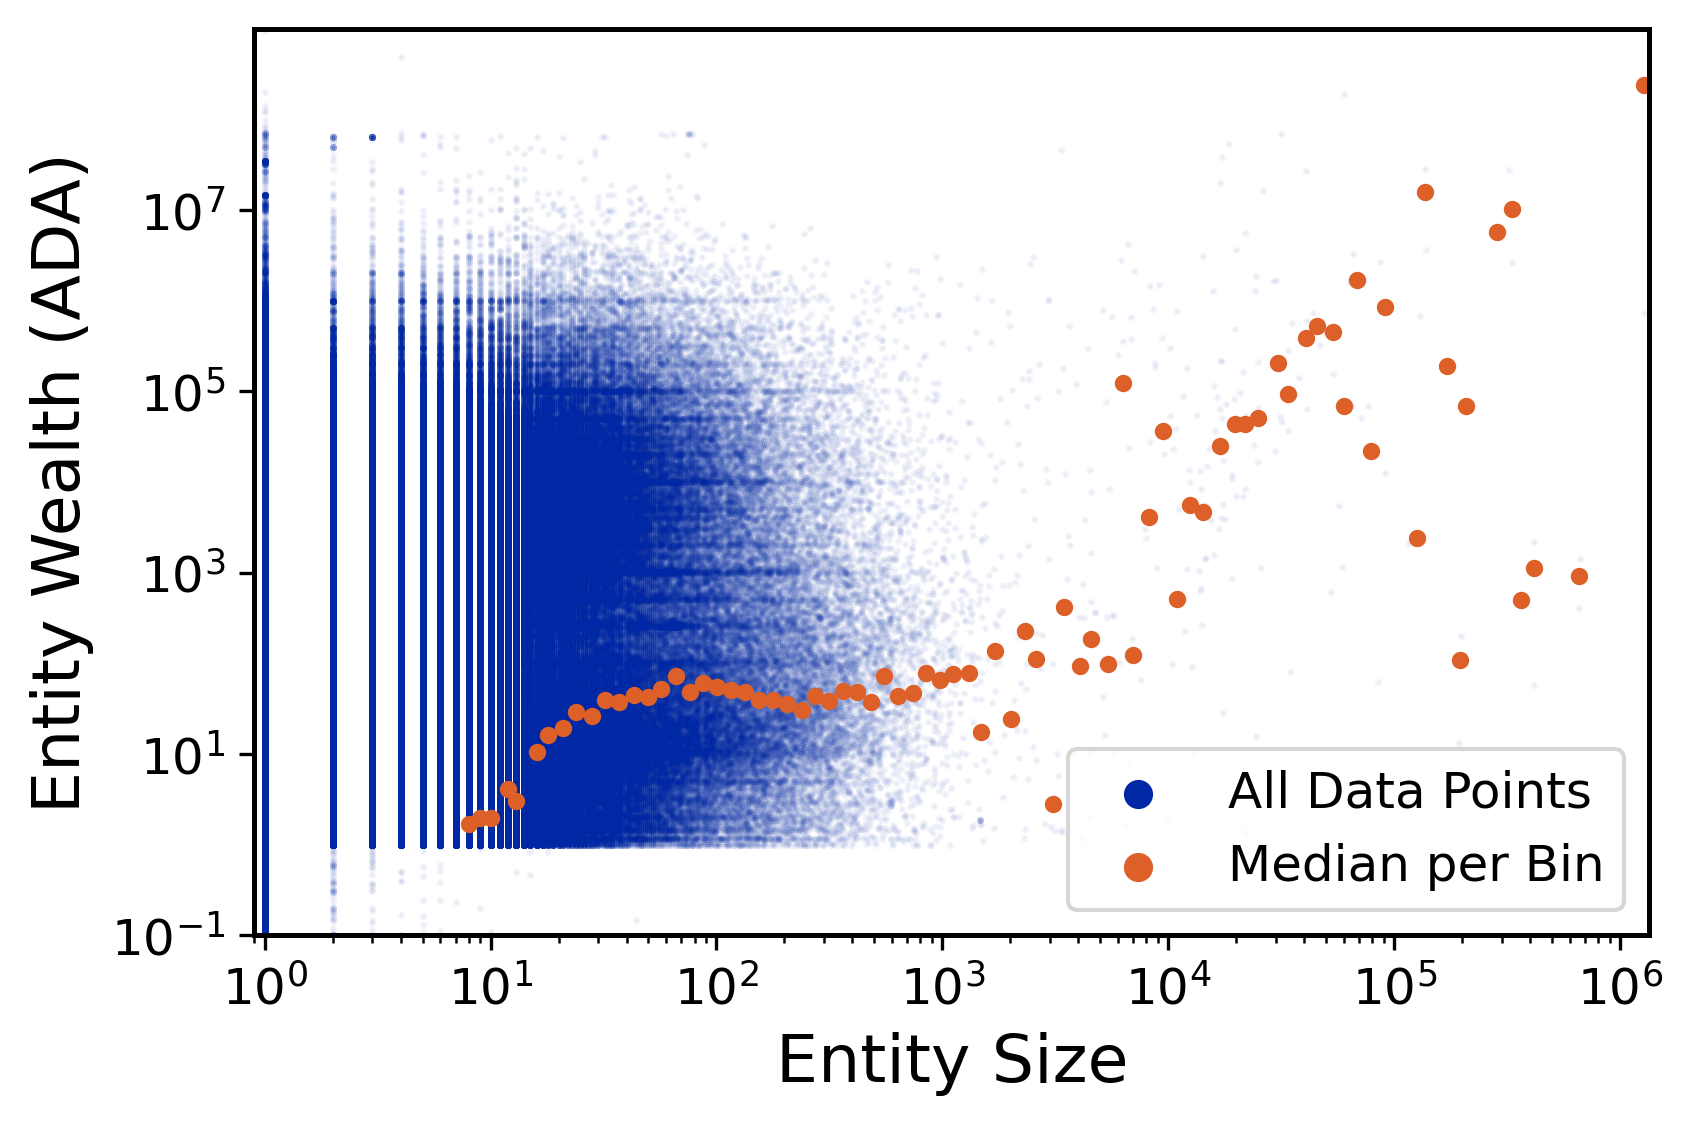

In [116]:
# Plot "Entity Wealth (ADA)" vs. "Entity Size":

import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')

x = entity_size_array_heur1and2

file_name = BASE_ADDRESS + '/YuZhang_Cardano_Balances_Entities/YuZhang__BalancesPerEntityDay_1945__Cardano_TXs_All.txt'
y = load_file_to_array(file_name)


#x4 = num_of_entities_per_epoch_cumulative__LATEST
#y4 = count_cumulative_rewarded_pools_per_epoch

x = np.array(x, dtype=np.float64)
y = np.array(y, dtype=np.float64)
y = y/(10**6)  # convert lovelace to ADA


#x4 = np.array(x4)
#y4 = np.array(y4)


# Replace zeros in y with a very small number
small_number = 1e-4
x[x == 0] = small_number
y[y == 0] = small_number


# Transforming data to log space
log_x = np.log10(x)
log_y = np.log10(y)

# Define bin edges in log space
bin_edges_x = np.logspace(np.min(log_x), np.max(log_x), 100)
#bin_edges_y = np.logspace(np.min(log_y), np.max(log_y), 100)

# Digitize/assign each point to a bin
bin_indices_x = np.digitize(log_x, bins=np.log10(bin_edges_x))
#bin_indices_y = np.digitize(log_y, bins=np.log10(bin_edges_y))


# Calculate mean/median in each bin
binned_data = []
for i in tqdm(range(1, len(bin_edges_x))):
    #for j in range(1, len(bin_edges_y)):
        # Find indices for each bin separately
        indices_x = np.where(bin_indices_x == i)
        #indices_y = np.where(bin_indices_y == j)
        
        # Find common indices
        #common_indices = np.intersect1d(indices_x, indices_y)

        if len(indices_x) > 0:
            median_x = np.median(x[indices_x])
            median_y = np.median(y[indices_x])
            binned_data.append((median_x, median_y))



# Extract binned data for plotting
binned_x, binned_y = zip(*binned_data)



# Create a figure and axis
fig, ax = plt.subplots()


# Create a scatter plot
scatter_plot1 = plt.scatter(x, y,               label='Scatter Plot', marker='o', s=0.5, alpha=0.05)
scatter_plot2 = plt.scatter(binned_x, binned_y, label='Scatter Plot', marker='o', s=10,   alpha=1)

#plt.legend(['All Data Points', 'Median per Bin'], handles=[legend_scatter], fontsize=8, loc ="lower right")
legend_scatter1 = plt.scatter([], [], alpha=1, color=scatter_plot1.get_facecolor()[0], label='All Data Points')
legend_scatter2 = plt.scatter([], [], alpha=1, color=scatter_plot2.get_facecolor()[0], label='Median per Bin')
plt.legend(handles=[legend_scatter1, legend_scatter2], loc ="lower right")
legend_scatter1.remove()
legend_scatter2.remove()



plt.xlabel('Entity Size')
plt.ylabel('Entity Wealth (ADA)')

plt.xlim(left=0.9)   #, right=int(10 * 10**9))
plt.ylim(bottom=0.1) #, top=int(10 * 10**9))

plt.xscale('log')
plt.yscale('log')


# Show the plot
plt.savefig('fig_EntityWealth_vs_EntitySize.png', bbox_inches='tight', facecolor='white')
plt.show()



start time (Load /local/scratch/exported/Cardano_MCH_2023_1//YuZhang_Cardano_StakeDelegation_Entities/StakeDelegPerEntityEpoch_0390__Cardano_TXs_All.txt to Array):  2023-12-14 20:27:40.673508
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//YuZhang_Cardano_StakeDelegation_Entities/StakeDelegPerEntityEpoch_0390__Cardano_TXs_All.txt to Array):  0:00:00.626182


  1%|          | 1/99 [00:00<01:03,  1.55it/s]/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 99/99 [00:01<00:00, 70.81it/s] 


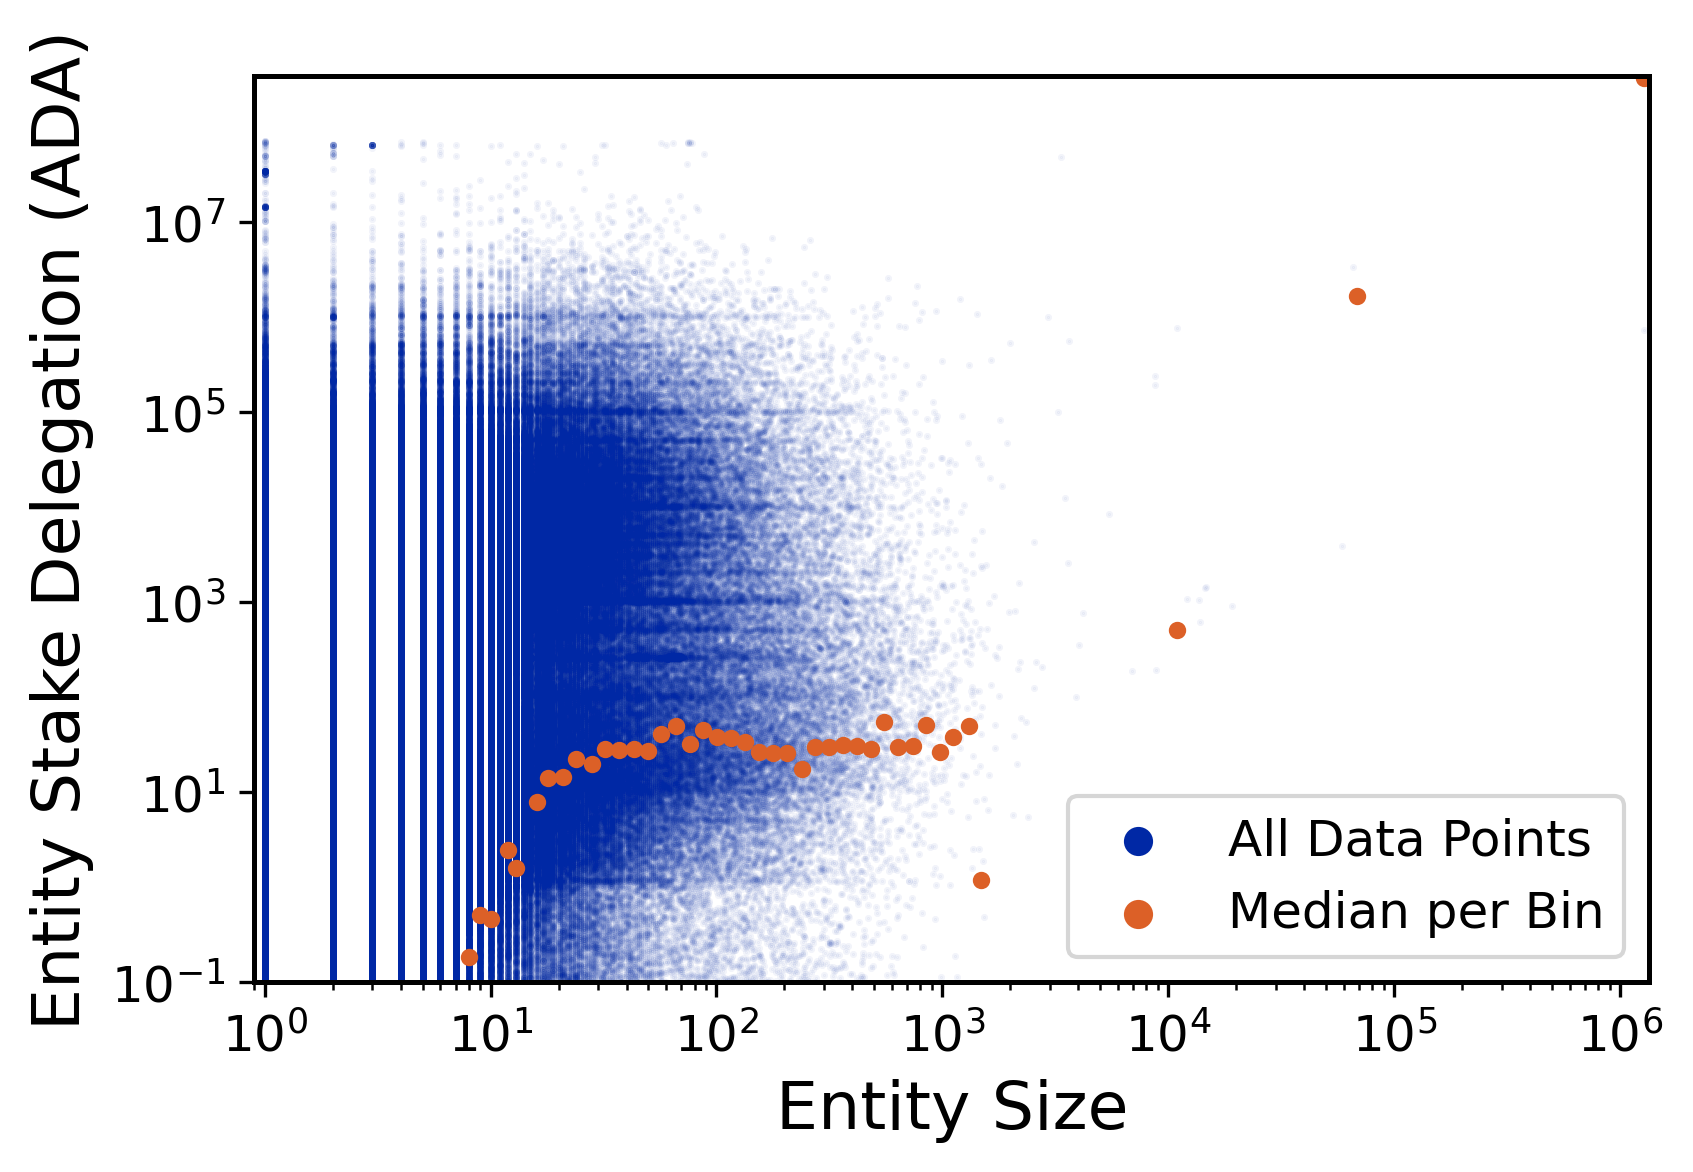

In [117]:
# Plot "Entity Stake Delegation (ADA)" vs. "Entity Size":


import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')


x = entity_size_array_heur1and2

file_name = BASE_ADDRESS + '/YuZhang_Cardano_StakeDelegation_Entities/StakeDelegPerEntityEpoch_0390__Cardano_TXs_All.txt'
y = load_file_to_array(file_name)


#x4 = num_of_entities_per_epoch_cumulative__LATEST
#y4 = count_cumulative_rewarded_pools_per_epoch



x = np.array(x, dtype=np.float64)
y = np.array(y, dtype=np.float64)
y = y/(10**6) # convert lovelace to ADA

#x4 = np.array(x4)
#y4 = np.array(y4)



# Replace zeros in y with a very small number
small_number = 1e-6
x[x == 0] = small_number
y[y == 0] = small_number


# Transforming data to log space
log_x = np.log10(x)
log_y = np.log10(y)

# Define bin edges in log space
bin_edges_x = np.logspace(np.min(log_x), np.max(log_x), 100)
#bin_edges_y = np.logspace(np.min(log_y), np.max(log_y), 100)

# Digitize/assign each point to a bin
bin_indices_x = np.digitize(log_x, bins=np.log10(bin_edges_x))
#bin_indices_y = np.digitize(log_y, bins=np.log10(bin_edges_y))


# Calculate mean/median in each bin
binned_data = []
for i in tqdm(range(1, len(bin_edges_x))):
    #for j in range(1, len(bin_edges_y)):
        # Find indices for each bin separately
        indices_x = np.where(bin_indices_x == i)
        #indices_y = np.where(bin_indices_y == j)
        
        # Find common indices
        #common_indices = np.intersect1d(indices_x, indices_y)

        if len(indices_x) > 0:
            median_x = np.median(x[indices_x])
            median_y = np.median(y[indices_x])
            binned_data.append((median_x, median_y))



# Extract binned data for plotting
binned_x, binned_y = zip(*binned_data)



# Create a figure and axis
fig, ax = plt.subplots()


# Create a scatter plot
scatter_plot1 = plt.scatter(x, y,               label='Scatter Plot', marker='o', s=0.5, alpha=0.05)
scatter_plot2 = plt.scatter(binned_x, binned_y, label='Scatter Plot', marker='o', s=10, alpha=1)


#plt.legend(['All Data Points', 'Median per Bin'], handles=[legend_scatter], fontsize=8, loc ="lower right")
legend_scatter1 = plt.scatter([], [], alpha=1, color=scatter_plot1.get_facecolor()[0], label='All Data Points')
legend_scatter2 = plt.scatter([], [], alpha=1, color=scatter_plot2.get_facecolor()[0], label='Median per Bin')
plt.legend(handles=[legend_scatter1, legend_scatter2], loc ="lower right")
legend_scatter1.remove()
legend_scatter2.remove()


plt.xlabel('Entity Size')
plt.ylabel('Entity Stake Delegation (ADA)')

plt.xlim(left=0.9)   #, int(10 * 10**6))
plt.ylim(bottom=0.1) #, int(10 * 10**6))

plt.xscale('log')
plt.yscale('log')


# Show the plot
plt.savefig('fig_EntityStakeDelegation_vs_EntitySize.png', bbox_inches='tight', facecolor='white')
plt.show()



start time (Load /local/scratch/exported/Cardano_MCH_2023_1//YuZhang_Cardano_Balances_Entities/YuZhang__BalancesPerEntityDay_1945__Cardano_TXs_All.txt to Array):  2023-12-14 21:14:44.883262
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//YuZhang_Cardano_Balances_Entities/YuZhang__BalancesPerEntityDay_1945__Cardano_TXs_All.txt to Array):  0:00:00.820417
start time (Load /local/scratch/exported/Cardano_MCH_2023_1//YuZhang_Cardano_StakeDelegation_Entities/StakeDelegPerEntityEpoch_0391__Cardano_TXs_All.txt to Array):  2023-12-14 21:14:45.704110
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//YuZhang_Cardano_StakeDelegation_Entities/StakeDelegPerEntityEpoch_0391__Cardano_TXs_All.txt to Array):  0:00:00.605147


 91%|█████████ | 90/99 [00:03<00:00, 27.58it/s]/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 99/99 [00:03<00:00, 26.59it/s]


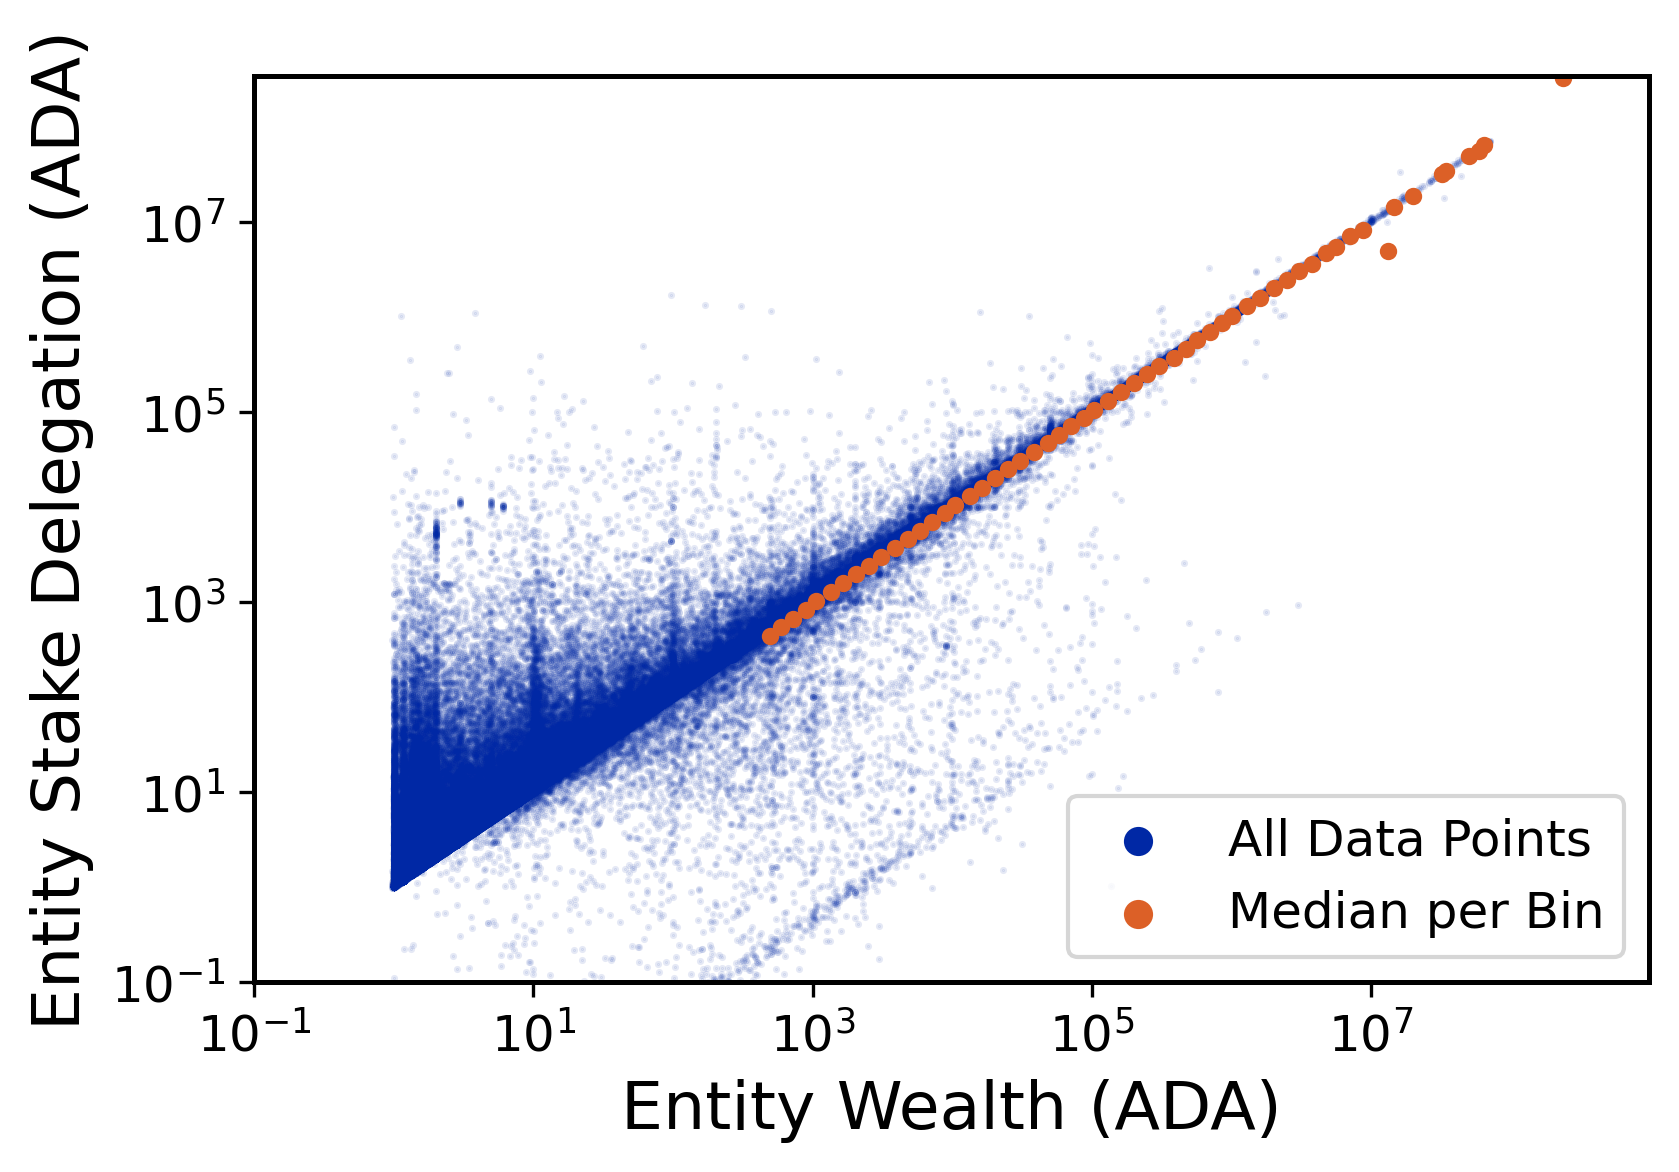

In [119]:
# Plot "Entity Stake Delegation (ADA)" vs. "Entity Wealth (ADA)":


import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')

file_name = BASE_ADDRESS + '/YuZhang_Cardano_Balances_Entities/YuZhang__BalancesPerEntityDay_1945__Cardano_TXs_All.txt'
x = load_file_to_array(file_name)


file_name = BASE_ADDRESS + '/YuZhang_Cardano_StakeDelegation_Entities/StakeDelegPerEntityEpoch_0391__Cardano_TXs_All.txt'
y = load_file_to_array(file_name)


#x4 = num_of_entities_per_epoch_cumulative__LATEST
#y4 = count_cumulative_rewarded_pools_per_epoch



x = np.array(x, dtype=np.float64)
x = x/(10**6)  # convert lovelace to ADA
y = np.array(y, dtype=np.float64)
y = y/(10**6) # convert lovelace to ADA

#x4 = np.array(x4)
#y4 = np.array(y4)



# Replace zeros in y with a very small number
small_number = 1e-6
x[x == 0] = small_number
y[y == 0] = small_number


# Transforming data to log space
log_x = np.log10(x)
log_y = np.log10(y)

# Define bin edges in log space
bin_edges_x = np.logspace(0.01, np.max(log_x), 100)
#bin_edges_y = np.logspace(np.min(log_y), np.max(log_y), 100)

# Digitize/assign each point to a bin
bin_indices_x = np.digitize(log_x, bins=np.log10(bin_edges_x))
#bin_indices_y = np.digitize(log_y, bins=np.log10(bin_edges_y))


# Calculate mean/median in each bin
binned_data = []
for i in tqdm(range(1, len(bin_edges_x))):
    #for j in range(1, len(bin_edges_y)):
        # Find indices for each bin separately
        indices_x = np.where(bin_indices_x == i)
        #indices_y = np.where(bin_indices_y == j)
        
        # Find common indices
        #common_indices = np.intersect1d(indices_x, indices_y)

        if len(indices_x) > 0:
            median_x = np.median(x[indices_x])
            median_y = np.median(y[indices_x])
            binned_data.append((median_x, median_y))



# Extract binned data for plotting
binned_x, binned_y = zip(*binned_data)




# Create a figure and axis
fig, ax = plt.subplots()


# Create a scatter plot
scatter_plot1 = plt.scatter(x, y,               label='Scatter Plot', marker='o', s=0.5, alpha=0.1)
scatter_plot2 = plt.scatter(binned_x, binned_y, label='Scatter Plot', marker='o', s=10,  alpha=1)


#plt.legend(['All Data Points', 'Median per Bin'], handles=[legend_scatter], fontsize=8, loc ="lower right")
legend_scatter1 = plt.scatter([], [], alpha=1, color=scatter_plot1.get_facecolor()[0], label='All Data Points')
legend_scatter2 = plt.scatter([], [], alpha=1, color=scatter_plot2.get_facecolor()[0], label='Median per Bin')
plt.legend(handles=[legend_scatter1, legend_scatter2], loc ="lower right")
legend_scatter1.remove()
legend_scatter2.remove()
#plt.legend(['Active Pools', 'Rewarded Pools'], loc ="lower right")





plt.xlabel('Entity Wealth (ADA)')
plt.ylabel('Entity Stake Delegation (ADA)')

plt.xlim(left=0.1)   #, int(10 * 10**6))
plt.ylim(bottom=0.1) #, int(10 * 10**6))

plt.xscale('log')
plt.yscale('log')


# Show the plot
plt.savefig('fig_EntityWealth_vs_EntityStakeDelegation.png', bbox_inches='tight', facecolor='white')
plt.show()



In [139]:
# For each entity, compute how much wealth it has W_i, and how much it delegates D_i. Then, make r_i = D_i / W_i:
#   1. aggregate the wealth of all entities i if 0.95 > r_i > 1.05.
#   2. count how many entities i are in this range.


file_name = BASE_ADDRESS + '/YuZhang_Cardano_Balances_Entities/YuZhang__BalancesPerEntityDay_1945__Cardano_TXs_All.txt'
entity_wealth = load_file_to_array(file_name)


file_name = BASE_ADDRESS + '/YuZhang_Cardano_StakeDelegation_Entities/StakeDelegPerEntityEpoch_0391__Cardano_TXs_All.txt'
entity_deleg = load_file_to_array(file_name)


entity_wealth = np.array(entity_wealth, dtype=np.float64)
entity_wealth = entity_wealth/(10**6)
entity_deleg = np.array(entity_deleg, dtype=np.float64)
entity_deleg = entity_deleg/(10**6)

entity_deleg_to_wealth_rate = entity_deleg / entity_wealth

# Find indexes where the condition is met
indexes = np.where((entity_deleg_to_wealth_rate > 0.95) & (entity_deleg_to_wealth_rate < 1.05))

# Sum the elements of entity_wealth at these indexes
sum_wealth = np.sum(entity_wealth[indexes])

# Count the number of elements in the range
count_in_range = len(indexes[0])

sum_wealth, count_in_range, len(entity_wealth)
#print(sum_wealth)




start time (Load /local/scratch/exported/Cardano_MCH_2023_1//YuZhang_Cardano_Balances_Entities/YuZhang__BalancesPerEntityDay_1945__Cardano_TXs_All.txt to Array):  2023-12-14 21:51:09.065036
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//YuZhang_Cardano_Balances_Entities/YuZhang__BalancesPerEntityDay_1945__Cardano_TXs_All.txt to Array):  0:00:00.794379
start time (Load /local/scratch/exported/Cardano_MCH_2023_1//YuZhang_Cardano_StakeDelegation_Entities/StakeDelegPerEntityEpoch_0391__Cardano_TXs_All.txt to Array):  2023-12-14 21:51:09.862307
elapsed time (Load /local/scratch/exported/Cardano_MCH_2023_1//YuZhang_Cardano_StakeDelegation_Entities/StakeDelegPerEntityEpoch_0391__Cardano_TXs_All.txt to Array):  0:00:00.592456


/tmp/ipykernel_1604562/3377292407.py:19: RuntimeWarning: divide by zero encountered in true_divide
  entity_deleg_to_wealth_rate = entity_deleg / entity_wealth
/tmp/ipykernel_1604562/3377292407.py:19: RuntimeWarning: invalid value encountered in true_divide
  entity_deleg_to_wealth_rate = entity_deleg / entity_wealth


(20157087138.774826, 544002, 8805791)

In [ ]:
# NFTs and FTs Minted by each entity:


print('----------------------')

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)
print('----------------------')


# = "clustering_array_heur1"  OR  "clustering_array_heur2"  OR  "clustering_array_heur1and2"
clustering_array = clustering_array_heur1and2    #************************?????????????????????????????????????************************



# Initialize "NFTs_minted_per_entity_array" and "FTs_minted_per_entity_array" (For every "payment_address", this array shows which "MA_ID"s are minted by that address):
NFTs_minted_per_entity_array = [[] for _ in range( np.amax(clustering_array)+1 )]
FTs_minted_per_entity_array  = [[] for _ in range( np.amax(clustering_array)+1 )]

NFTs_minted_by_smart_contract = 0
FTs_minted_by_smart_contract  = 0




CSV_FILES_NAME_FORMAT = BASE_ADDRESS + '/cardano_TXs_'
NUMBER_OF_CSV_FILES = 6
CSV_FILES_SUFFIX = '.csv'


for i in range(1, NUMBER_OF_CSV_FILES + 1):

    ct_temp = datetime.datetime.now()

    file_name = CSV_FILES_NAME_FORMAT + str(i) + CSV_FILES_SUFFIX
    df = pd.read_csv(file_name, delimiter='|')

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Load CSV File " + file_name + "): ", et_temp)

    ct_temp = datetime.datetime.now()

    for index, row in tqdm(df.iterrows()):
        ##########################################################################################
        TX_ID      = df.loc[index , 'TX_ID']
        BLOCK_TIME = str(datetime.datetime.strptime(str(df.loc[index , 'BLOCK_TIME']), '%Y-%m-%d %H:%M:%S').date())
        EPOCH_NO   = str(  df.loc[index , 'EPOCH_NO'] )
        ##########################################################################################
        inputs_list = list( df.loc[index , 'INPUTs'].split(';') )
        #for tx_input in inputs_list:
        #    tx_input_UTXO_address = tx_input.split(',')[4]
        #    payment_address_list.append(tx_input_UTXO_address)
        ##########################################################################################
        #outputs_list = list( df.loc[index , 'OUTPUTs'].split(';') )
        #for tx_output in outputs_list:
        #    address_raw        = tx_output.split(',')[1]
        #    address_has_script = tx_output.split(',')[4]
        #    payment_cred       = tx_output.split(',')[5]
        #    stake_address      = tx_output.split(',')[6]
        #    [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
        #    if (address_payment_part != '' and address_delegation_part != ''):
        #        indx1 = BinarySearch(unique_delegation_addresses, address_delegation_part)
        #        indx2 = BinarySearch(unique_payment_addresses, address_payment_part)
        #        stake_delegation_array[indx1].append(indx2)
        ##########################################################################################
        NFTs_list  = list( df.loc[index , 'MINT_NFTs'].split(';') )
        for NFT in NFTs_list:
            MA_ID = NFT.split(',')[0]
            if(MA_ID != ''):
                flag = 0
                for tx_input in inputs_list:
                    address_raw           = tx_input.split(',')[4]
                    address_has_script    = tx_input.split(',')[7]
                    payment_cred          = tx_input.split(',')[8]
                    stake_address         = tx_input.split(',')[9]
                    if(address_has_script == 'f'):  # non-Smart Contract Address 
                        [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                        if (address_payment_part != ''):
                            addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                            entity_indx = clustering_array[addr_indx][0]
                            NFTs_minted_per_entity_array[entity_indx].append(MA_ID)
                            flag = flag + 1
                            break; # we need to find only one payment address, so break after finding it
                if(flag == 0):
                    NFTs_minted_by_smart_contract = NFTs_minted_by_smart_contract + 1
                    if(NFTs_minted_by_smart_contract < 100):
                        print("NFT: no non-smart contract input address was found for MA_ID = ", MA_ID, '|TX_ID = ', TX_ID)
        ##########################################################################################
        FTs_list   = list( df.loc[index , 'MINT_FTs'].split(';') )
        for FT in FTs_list:
            MA_ID = FT.split(',')[0]
            if(MA_ID != ''):
                flag = 0
                for tx_input in inputs_list:
                    address_raw           = tx_input.split(',')[4]
                    address_has_script    = tx_input.split(',')[7]
                    payment_cred          = tx_input.split(',')[8]
                    stake_address         = tx_input.split(',')[9]
                    if(address_has_script == 'f'):  # non-Smart Contract Address 
                        [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                        if (address_payment_part != ''):
                            addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                            entity_indx = clustering_array[addr_indx][0]
                            FTs_minted_per_entity_array[entity_indx].append(MA_ID)
                            flag = flag + 1
                            break; # we need to find only one payment address, so break after finding it
                if(flag == 0):
                    FTs_minted_by_smart_contract = FTs_minted_by_smart_contract + 1
                    if(FTs_minted_by_smart_contract < 100):
                        print(" FT: no non-smart contract input address was found for MA_ID = ", MA_ID, '|TX_ID = ', TX_ID)
        ##########################################################################################

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Extract stake delegations from CSV File " + file_name + "): ", et_temp)



print('----------------------')
et = datetime.datetime.now() - ct
print("Total elapsed time (Heuristic2: find \"Shelley Addresses\" with the same \"address_delegation_part\"): ", et)


print('----------------------')
print('done!')



In [ ]:
# Statistics of NFTs/FTs:

print('FTs_minted_by_smart_contract  = ', FTs_minted_by_smart_contract)
print('NFTs_minted_by_smart_contract = ', NFTs_minted_by_smart_contract)



In [ ]:
# Store/Load "NFTs_minted_per_entity_array" and "FTs_minted_per_entity_array" into file:


print('----------------------')

ct = datetime.datetime.now()
curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]

# Store to file:
'''
output_filename = BASE_ADDRESS + '/EntityNFTsArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file_2D (NFTs_minted_per_entity_array, output_filename)


output_filename = BASE_ADDRESS + '/EntityFTsArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file_2D (FTs_minted_per_entity_array, output_filename)
'''



# Load from file:

file_name = BASE_ADDRESS + '/EntityNFTsArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__2023-04-08_075547.txt'
NFTs_minted_per_entity_array = load_file_to_array_2D (file_name)

file_name = BASE_ADDRESS + '/EntityFTsArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__2023-04-08_075547.txt'
FTs_minted_per_entity_array  = load_file_to_array_2D (file_name)



##########################################################################################
print('----------------------')
print('done!')



In [ ]:
# Plot Distribution of minted NFTs per Entity (Heur1 and Heur2):

plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')



# count number of NFTs minted by each entity:
count_NFTs_minted_per_entity = [0]*len(NFTs_minted_per_entity_array)
for i in tqdm(range(len(NFTs_minted_per_entity_array))):
    count_NFTs_minted_per_entity[i] = len(NFTs_minted_per_entity_array[i])

plt.hist(count_NFTs_minted_per_entity, density=True, bins = np.logspace(np.log10(1), np.log10(max(count_NFTs_minted_per_entity)),40))



plt.xlabel('Number of NFTs per Entity (Cluster)')
plt.ylabel('Probability')

#plt.legend(['Active Addresses', 'Active Entities'], loc ="upper left")
plt.xscale("log" )
plt.yscale("log" )

plt.savefig('fig_NFTs_per_entity_dist.pdf', bbox_inches='tight', facecolor='white')
plt.show()




In [ ]:
# power-law distributions (minted NFT per Entity):

#find non-zeros:
count_NFTs_minted_per_entity_no_zeros = [i for i in count_NFTs_minted_per_entity if i != 0]

fit = powerlaw.Fit(count_NFTs_minted_per_entity_no_zeros)

print('fit.power_law.alpha = ', fit.power_law.alpha)
print('fit.power_law.sigma = ', fit.power_law.sigma)
print('fit.power_law.xmin = ',  fit.power_law.xmin)
print('fit.power_law.xmax = ',  fit.power_law.xmax)
print('fit.distribution_compare(\'power_law\', \'exponential\') = ', fit.distribution_compare('power_law', 'exponential'))


plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')

plt.xlabel('Number of Minted NFTs per Entity (Cluster)')
plt.ylabel('Probability Density')


#plt.xlim(left=10)
plt.ylim(bottom=1e-12)
markersize = 3

fig = fit.plot_pdf(linestyle = '', marker='o', original_data=True)
#fit.power_law.plot_pdf(linestyle = 'dashed', ax = fig)


def abline(plt, slope, intercept, x0, x1):
    """Plot a line from slope and intercept"""
    x_vals = np.logspace(x0, x1, num=100)
    y_vals = 10**(intercept) * (x_vals**slope)
    plt.plot(x_vals, y_vals, '--')


#abline(plt, -fit.power_law.alpha, -0.8, 0.2, 5.5)

plt.savefig('fig_NFTs_per_entity_dist.pdf', bbox_inches='tight', facecolor='white')
plt.show()



In [ ]:
# Plot Distribution of minted FTs per Entity (Heur1 and Heur2):

plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')



# count number of FTs minted by each entity:
count_FTs_minted_per_entity  = [0]*len(FTs_minted_per_entity_array)
for i in tqdm(range(len(FTs_minted_per_entity_array))):
    count_FTs_minted_per_entity[i] = len(FTs_minted_per_entity_array[i])

plt.hist(count_FTs_minted_per_entity, density=True, bins = np.logspace(np.log10(1), np.log10(max(count_FTs_minted_per_entity)),40))



plt.xlabel('Number of Minted FTs per Entity (Cluster)')
plt.ylabel('Probability')

#plt.legend(['Active Addresses', 'Active Entities'], loc ="upper left")
plt.xscale("log" )
plt.yscale("log" )

plt.savefig('fig_FTs_per_entity_dist.pdf', bbox_inches='tight', facecolor='white')
plt.show()




In [ ]:
# power-law distributions (minted FT per Entity):

#find non-zeros:
count_FTs_minted_per_entity_no_zeros = [i for i in count_FTs_minted_per_entity if i != 0]

fit = powerlaw.Fit(count_FTs_minted_per_entity_no_zeros)

print('fit.power_law.alpha = ', fit.power_law.alpha)
print('fit.power_law.sigma = ', fit.power_law.sigma)
print('fit.power_law.xmin = ',  fit.power_law.xmin)
print('fit.power_law.xmax = ',  fit.power_law.xmax)
print('fit.distribution_compare(\'power_law\', \'exponential\') = ', fit.distribution_compare('power_law', 'exponential'))


plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')

plt.xlabel('Number of Minted FTs per Entity (Cluster)')
plt.ylabel('Probability Density')


#plt.xlim(left=10)
plt.ylim(bottom=1e-12)
markersize = 3

fig = fit.plot_pdf(linestyle = '', marker='o', original_data=True)
#fit.power_law.plot_pdf(linestyle = 'dashed', ax = fig)


def abline(plt, slope, intercept, x0, x1):
    """Plot a line from slope and intercept"""
    x_vals = np.logspace(x0, x1, num=100)
    y_vals = 10**(intercept) * (x_vals**slope)
    plt.plot(x_vals, y_vals, '--')


#abline(plt, -fit.power_law.alpha, 1.1, 0.5, 4.5)


plt.savefig('fig_FTs_per_entity_dist.pdf', bbox_inches='tight', facecolor='white')
plt.show()



In [ ]:
# "NFTs" Owned by each entity + "Balances" of entities:


print('----------------------')

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)
print('----------------------')


# = "clustering_array_heur1"  OR  "clustering_array_heur2"  OR  "clustering_array_heur1and2"
clustering_array = clustering_array_heur1and2


# Initialize "NFTs_owned_per_entity_array" and "FTs_owned_per_entity_array" (For every "payment_address", this array shows which "OUTPUT_MULTIASSET_TXOUT_IDENT"s are owned by that address):
NFTs_owned_per_entity_array = [[] for _ in range( np.amax(clustering_array)+1 )]
FTs_owned_per_entity_array  = [[] for _ in range( np.amax(clustering_array)+1 )]
count_NFTs_per_entity = [0]*len(NFTs_owned_per_entity_array)



# Initialize "balances_per_entity_array":
balances_per_entity_array = np.array([0] * ( np.amax(clustering_array)+1 ))



CSV_FILES_NAME_FORMAT = BASE_ADDRESS + '/cardano_TXs_NFTs_'
NUMBER_OF_CSV_FILES = 6
CSV_FILES_SUFFIX = '.csv'


for i in range(1, NUMBER_OF_CSV_FILES + 1):

    ct_temp = datetime.datetime.now()

    file_name = CSV_FILES_NAME_FORMAT + str(i) + CSV_FILES_SUFFIX
    df = pd.read_csv(file_name, delimiter='|')

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Load CSV File " + file_name + "): ", et_temp)

    ct_temp = datetime.datetime.now()

    for index, row in tqdm(df.iterrows()):
        ##########################################################################################
        TX_ID      = df.loc[index , 'TX_ID']
        ##########################################################################################
        #BLOCK_TIME  = str(datetime.datetime.strptime(str(df.loc[index , 'BLOCK_TIME']), '%Y-%m-%d %H:%M:%S').date())
        BLOCK_TIME   = datetime.datetime.strptime(str(df.loc[index , 'BLOCK_TIME']), '%Y-%m-%d %H:%M:%S').date()
        tx_delta_day = int((BLOCK_TIME - INITIAL_DATE_CARDANO).total_seconds()/86400)
        ##########################################################################################
        EPOCH_NO   = str(  df.loc[index , 'EPOCH_NO'] )
        ##########################################################################################
        inputs_list = list( df.loc[index , 'INPUTs'].split(';') )
        #for tx_input in inputs_list:
        #    tx_input_UTXO_address = tx_input.split(',')[4]
        #    payment_address_list.append(tx_input_UTXO_address)
        ##########################################################################################
        outputs_list = list( df.loc[index , 'OUTPUTs'].split(';') )
        #for tx_output in outputs_list:
        #    address_raw        = tx_output.split(',')[1]
        #    address_has_script = tx_output.split(',')[4]
        #    payment_cred       = tx_output.split(',')[5]
        #    stake_address      = tx_output.split(',')[6]
        #    [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
        #    if (address_payment_part != '' and address_delegation_part != ''):
        #        indx1 = BinarySearch(unique_delegation_addresses, address_delegation_part)
        #        indx2 = BinarySearch(unique_payment_addresses, address_payment_part)
        #        stake_delegation_array[indx1].append(indx2)
        ##########################################################################################
        ##########################################################################################
        # STRING_AGG(distinct concat(things."INPUT_ID",   ':', things."INPUT_REFOUT_MAs__NAME__POLICY__FINGERPRINT",                                                                               ''    ), E';') as "TX_INPUT_MAs", 
        # STRING_AGG(distinct concat(things."OUTPUT_MULTIASSET_TXOUT_IDENT", ',', things."OUTPUT_MULTIASSET_TXOUT_QUANTITY", ',', things."OUTPUT_NFT_NAME",       ',', things."OUTPUT_FT_NAME",    ',', 
        #                            things."OUTPUT_MA_NAME",                ',', things."OUTPUT_MA_POLICY",                 ',', things."OUTPUT_MA_FINGERPRINT",                                  ','   ), E':') AS "MAs__NAME__POLICY__FINGERPRINT" 
        TX_INPUT_MAs_list = list( df.loc[index , 'TX_INPUT_MAs'].split(';') )
        for INPUT_MAs in TX_INPUT_MAs_list:
            MAs_list = list( INPUT_MAs.split(':') )
            if(MAs_list[0] == ''):
                continue;
            INPUT_ID = int(MAs_list[0])
            MAs_list.pop(0)
            flag = 0
            for MA in MAs_list:
                MA_splited = MA.split(',')
                if(len(MA_splited) < 7):
                    continue;

                MA_ID          = MA_splited[0]
                quantity       = MA_splited[1] # quantity of multi asset stored in this UTXO
                NFT_name       = MA_splited[2]
                FT_name        = MA_splited[3]
                MA_name        = MA_splited[4]
                MA_policy      = MA_splited[5]
                MA_fingerprint = MA_splited[6]

                if(NFT_name != ''):
                    # Find address/entity of input:
                    if(flag == 0):
                        flag = 1
                        entity_indx = ''
                        for tx_input in inputs_list:
                            tx_input_ID = int(tx_input.split(',')[0])
                            if(tx_input_ID == INPUT_ID):
                                address_raw           = tx_input.split(',')[4]
                                address_has_script    = tx_input.split(',')[7]
                                payment_cred          = tx_input.split(',')[8]
                                stake_address         = tx_input.split(',')[9]
                                if(address_has_script == 'f'):  # non-Smart Contract Address 
                                    [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                                    if (address_payment_part != ''):
                                        addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                                        entity_indx = clustering_array[addr_indx][0]

                    # Append "MA_ID" to "NFTs_owned_per_entity_array":
                    if(MA_ID != '' and entity_indx != ''):
                        #NFTs_owned_per_entity_array[entity_indx].append((MA_ID, (-1)*int(quantity)))
                        count_NFTs_per_entity[entity_indx] = count_NFTs_per_entity[entity_indx] - int(quantity)

        ##########################################################################################
        ##########################################################################################
        # STRING_AGG(distinct concat(things."OUTPUT_ID",  ':', things."OUTPUT_MAs__NAME__POLICY__FINGERPRINT",                                                                                     ''    ), E';') as "TX_OUTPUT_MAs",
        # STRING_AGG(distinct concat(things."OUTPUT_MULTIASSET_TXOUT_IDENT", ',', things."OUTPUT_MULTIASSET_TXOUT_QUANTITY", ',', things."OUTPUT_NFT_NAME",       ',', things."OUTPUT_FT_NAME",    ',', 
        #                            things."OUTPUT_MA_NAME",                ',', things."OUTPUT_MA_POLICY",                 ',', things."OUTPUT_MA_FINGERPRINT",                                  ','   ), E':') AS "MAs__NAME__POLICY__FINGERPRINT"
        TX_OUTPUT_MAs_list = list( df.loc[index , 'TX_OUTPUT_MAs'].split(';') )
        for OUTPUT_MAs in TX_OUTPUT_MAs_list:
            MAs_list = list( OUTPUT_MAs.split(':') )
            if(MAs_list[0] == ''):
                continue;
            OUTPUT_ID = int(MAs_list[0])
            MAs_list.pop(0)
            flag = 0
            for MA in MAs_list:
                MA_splited = MA.split(',')
                if(len(MA_splited) < 7):
                    continue;

                MA_ID          = MA_splited[0]
                quantity       = MA_splited[1] # quantity of multi asset stored in this UTXO
                NFT_name       = MA_splited[2]
                FT_name        = MA_splited[3]
                MA_name        = MA_splited[4]
                MA_policy      = MA_splited[5]
                MA_fingerprint = MA_splited[6]

                if(NFT_name != ''):
                    # Find address/entity of input:
                    if(flag == 0):
                        flag = 1
                        entity_indx = ''
                        for tx_output in outputs_list:
                            tx_output_ID = int(tx_output.split(',')[0])
                            if(tx_output_ID == OUTPUT_ID):
                                address_raw           = tx_output.split(',')[1]
                                address_has_script    = tx_output.split(',')[4]
                                payment_cred          = tx_output.split(',')[5]
                                stake_address         = tx_output.split(',')[6]
                                if(address_has_script == 'f'):  # non-Smart Contract Address 
                                    [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                                    if (address_payment_part != ''):
                                        addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                                        entity_indx = clustering_array[addr_indx][0]

                    # Append "MA_ID" to "NFTs_owned_per_entity_array":
                    if(MA_ID != '' and entity_indx != ''):
                        #NFTs_owned_per_entity_array[entity_indx].append((MA_ID, (+1)*int(quantity)))
                        count_NFTs_per_entity[entity_indx] = count_NFTs_per_entity[entity_indx] + int(quantity)

        ##########################################################################################
        for i in range(0, len(inputs_list)):
            address_has_script = inputs_list[i].split(',')[7]
            if (address_has_script == 'f'): # non-Smart Contract Address
                address_raw   = inputs_list[i].split(',')[4]
                payment_cred  = inputs_list[i].split(',')[8]
                stake_address = inputs_list[i].split(',')[9]
                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                if (address_payment_part != ''):
                    addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                    entity_indx = clustering_array[addr_indx][0]
                    UTXO_value  = inputs_list[i].split(',')[6]
                    balances_per_entity_array[entity_indx] = balances_per_entity_array[entity_indx] - int(UTXO_value)

        for i in range(0, len(outputs_list)):
            address_has_script = outputs_list[i].split(',')[4]
            if (address_has_script == 'f'): # non-Smart Contract Address
                address_raw   = outputs_list[i].split(',')[1]
                payment_cred  = outputs_list[i].split(',')[5]
                stake_address = outputs_list[i].split(',')[6]
                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                if (address_payment_part != ''):
                    addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                    entity_indx = clustering_array[addr_indx][0]
                    UTXO_value  = outputs_list[i].split(',')[3]
                    balances_per_entity_array[entity_indx] = balances_per_entity_array[entity_indx] + int(UTXO_value)

        #################################################################






    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Extract stake delegations from CSV File " + file_name + "): ", et_temp)



print('----------------------')
et = datetime.datetime.now() - ct
print("Total elapsed time (Heuristic2: find \"Shelley Addresses\" with the same \"address_delegation_part\"): ", et)


print('----------------------')
print('done!')




In [ ]:
# Store/Load "NFTs_owned_per_entity_array" and "balances_per_entity_array" into file:


print('----------------------')
import pickle

ct = datetime.datetime.now()
curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]

# Store to file:
'''
output_filename = BASE_ADDRESS + '/EntityOwnNFTsWithNameArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
#store_array_to_file_2D (NFTs_owned_per_entity_array, output_filename)
pickle.dump(NFTs_owned_per_entity_array, open(output_filename, 'wb'))


output_filename = BASE_ADDRESS + '/EntityOwnNFTsNumberArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
#store_array_to_file_2D (count_NFTs_per_entity, output_filename)
pickle.dump(count_NFTs_per_entity, open(output_filename, 'wb'))


output_filename = BASE_ADDRESS + '/EntityBalancesArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
#store_array_to_file_2D (balances_per_entity_array, output_filename)
pickle.dump(balances_per_entity_array, open(output_filename, 'wb'))
'''



# Load from file:

file_name = BASE_ADDRESS + '/EntityOwnNFTsWithNameArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__2023-06-05_085540.txt'
#NFTs_owned_per_entity_array = load_file_to_array_2D (file_name)
NFTs_owned_per_entity_array = pickle.load(open(file_name, 'rb'))


file_name = BASE_ADDRESS + '/EntityOwnNFTsNumberArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__2023-06-05_085540.txt'
#count_NFTs_per_entity = load_file_to_array_2D (file_name)
count_NFTs_per_entity = pickle.load(open(file_name, 'rb'))


file_name = BASE_ADDRESS + '/EntityBalancesArrayList_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__2023-06-05_085540.txt'
#balances_per_entity_array  = load_file_to_array_2D (file_name)
balances_per_entity_array = pickle.load(open(file_name, 'rb'))



##########################################################################################
print('----------------------')
print('done!')



In [ ]:
non_zero_ADA_balances = 0
non_zero_NFT_balances = 0

for i in range(len(balances_per_entity_array)):
    if (balances_per_entity_array[i] != 0):
        non_zero_ADA_balances = non_zero_ADA_balances + 1

    if (count_NFTs_per_entity[i]>0):
        non_zero_NFT_balances = non_zero_NFT_balances + 1


print('Number of non_zero_ADA_balances = ', non_zero_ADA_balances)
print('Number of non_zero_NFT_balances = ', non_zero_NFT_balances)



In [ ]:
# Plot number of owned NFTs/ADAs per Entity:

print('----------------------')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')

plt.rcParams['agg.path.chunksize'] = 10000

balances_per_entity_array_ADA = [float(value)/1000000 for value in balances_per_entity_array]


print('----------------------')

'''
#Draw the histogram plot:
n, bins, _ = plt.hist(balances_per_entity_array_ADA, density=True, bins = np.logspace(np.log10(1), np.log10(float(max(balances_per_entity_array_ADA))), 100), histtype='step', color='w')
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, n, 'o')
#plt.ylim(1e-22, 1e-14)
plt.xlabel('ADA per Entity')
plt.ylabel('Probability Density')
plt.xscale("log")
plt.yscale("log")
'''


'''
#Draw the histogram plot:
n, bins, _ = plt.hist(count_NFTs_per_entity, density=True, bins = np.logspace(np.log10(1), np.log10(float(max(count_NFTs_per_entity))), 400), histtype='step', color='w')
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, n, 'o')
#plt.ylim(1e-24, 1e-20)
plt.xlabel('NFT per Entity')
plt.ylabel('Probability Density')
plt.xscale("log")
plt.yscale("log")
'''

'''
#Draw scatter plot:
plt.scatter(balances_per_entity_array_ADA, count_NFTs_per_entity, s=1, alpha = 0.05)
plt.xlim(0.1, 1e+10)
plt.ylim(0.1, 1e+20)
plt.xlabel('ADA per Entity')
plt.ylabel('NFT per Entity')
plt.xscale("log")
plt.yscale("log")
'''


#Draw the density plot:
#sns.distplot(SORTED_count_NFTs_per_entity, hist = False, kde = True, kde_kws = {'linewidth': 3})




#Draw the number of NFTs/ADAs:
SORTED_balances_per_entity_array = [x1 for x1, x2 in sorted(zip(balances_per_entity_array_ADA, count_NFTs_per_entity), key=lambda pair: pair[0], reverse=True)]
SORTED_count_NFTs_per_entity     = [x2 for x1, x2 in sorted(zip(balances_per_entity_array_ADA, count_NFTs_per_entity), key=lambda pair: pair[0], reverse=True)]
plt.plot(SORTED_count_NFTs_per_entity)
plt.plot(SORTED_balances_per_entity_array)
plt.legend(['NFT', 'ADA'], loc ="upper right")
plt.xlabel('Entity (Cluster)')
plt.ylabel('NFT/ADA per Entity')
plt.xlim(0.1, 25e+5)
plt.ylim(0.1, 1e+20)
#plt.xscale("log")
plt.yscale("log")





#plt.savefig('fig_NFT_ADA_per_Entity_ScatterPlot.png', bbox_inches='tight', facecolor='white')
#plt.savefig('fig_NFT_ADA_per_Entity.png', bbox_inches='tight', facecolor='white')
#plt.savefig('fig_ADA_per_Entity_Distribution.png', bbox_inches='tight', facecolor='white')
#plt.savefig('fig_NFT_per_Entity_Distribution.png', bbox_inches='tight', facecolor='white')
plt.show()

##########################################################################################
print('----------------------')
print('done!')




In [ ]:
# Find "Number of NFT/FT/ADA entity-level Transactions" over time:


print('----------------------')
def Find_ADA_NFT_FT_TXs_per_Entity_over_time(queue_):
    # read input queue arguments
    in_args = queue_.get()
    csv_file_name = in_args[0]

    csv_file_basename = os.path.basename(csv_file_name)
    
    ct = datetime.datetime.now()

    # Choose from: "clustering_array_heur1"  OR  "clustering_array_heur2"  OR  "clustering_array_heur1and2"
    clustering_array = clustering_array_heur1and2


    # Initialize final outputs:
    balances_per_entity_array = np.array([0] * ( np.amax(clustering_array)+1 ))
    entity_level_ADA_Transactions = []
    entity_level_NFT_Transactions = []
    entity_level_FT_Transactions  = []


    INITIAL_DATE_CARDANO      = datetime.datetime.strptime('2017-09-23 21:44:51', '%Y-%m-%d %H:%M:%S').date()
    FINAL_DATE_CARDANO        = datetime.datetime.strptime('2023-01-21 17:39:30', '%Y-%m-%d %H:%M:%S').date()
    total_time_length_CARDANO = int((FINAL_DATE_CARDANO - INITIAL_DATE_CARDANO).total_seconds()/86400) + 1


    ct_temp = datetime.datetime.now()

    file_name = csv_file_name
    df = pd.read_csv(file_name, delimiter='|')

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Load CSV File " + file_name + "): ", et_temp)

    ct_temp = datetime.datetime.now()
    
    cnt = 0

    for index, row in tqdm(df.iterrows()):
        ##########################################################################################
        TX_ID      = df.loc[index , 'TX_ID']
        ##########################################################################################
        #BLOCK_TIME = str(datetime.datetime.strptime(str(df.loc[index , 'BLOCK_TIME']), '%Y-%m-%d %H:%M:%S').date())
        BLOCK_TIME   = datetime.datetime.strptime(str(df.loc[index , 'BLOCK_TIME']), '%Y-%m-%d %H:%M:%S').date()
        tx_delta_day = int((BLOCK_TIME - INITIAL_DATE_CARDANO).total_seconds()/86400)
        ##########################################################################################
        EPOCH_NO   = str(  df.loc[index , 'EPOCH_NO'] )
        ##########################################################################################
        inputs_list = list( df.loc[index , 'INPUTs'].split(';') )
        #for tx_input in inputs_list:
        #    tx_input_UTXO_address = tx_input.split(',')[4]
        #    payment_address_list.append(tx_input_UTXO_address)
        ##########################################################################################
        outputs_list = list( df.loc[index , 'OUTPUTs'].split(';') )
        #for tx_output in outputs_list:
        #    address_raw        = tx_output.split(',')[1]
        #    address_has_script = tx_output.split(',')[4]
        #    payment_cred       = tx_output.split(',')[5]
        #    stake_address      = tx_output.split(',')[6]
        #    [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
        #    if (address_payment_part != '' and address_delegation_part != ''):
        #        indx1 = BinarySearch(unique_delegation_addresses, address_delegation_part)
        #        indx2 = BinarySearch(unique_payment_addresses, address_payment_part)
        #        stake_delegation_array[indx1].append(indx2)
        ##########################################################################################
        # List of input entities:
        input_entity_indx = []
        for tx_input in inputs_list:
            address_raw           = tx_input.split(',')[4]
            address_has_script    = tx_input.split(',')[7]
            payment_cred          = tx_input.split(',')[8]
            stake_address         = tx_input.split(',')[9]
            if(address_has_script == 'f'):  # non-Smart Contract Address 
                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                if (address_payment_part != ''):
                    addr_indx = BinarySearch(unique_payment_addresses, address_payment_part)
                    input_entity_indx.append(clustering_array[addr_indx][0])
                    break;

        if(input_entity_indx == []):
            cnt = cnt + 1
            #if(cnt < 100): print("WARNING - All inputs of this TX are Script/Smart Contract: TX_ID = ", TX_ID)
            continue;


        # List of output ADA entities (Entities in the output_list that have received ADA):
        output_ADA_entities_indx = []
        for tx_output in outputs_list:
            address_raw           = tx_output.split(',')[1]
            address_has_script    = tx_output.split(',')[4]
            payment_cred          = tx_output.split(',')[5]
            stake_address         = tx_output.split(',')[6]
            if(address_has_script == 'f'):  # non-Smart Contract Address 
                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                if (address_payment_part != ''):
                    addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                    output_ADA_entities_indx.append(clustering_array[addr_indx][0])

        output_ADA_entities_indx = list(set(output_ADA_entities_indx))
        if input_entity_indx[0] in output_ADA_entities_indx: output_ADA_entities_indx.remove(input_entity_indx[0])


        ##########################################################################################
        ##########################################################################################
        # STRING_AGG(distinct concat(things."OUTPUT_ID",  ':', things."OUTPUT_MAs__NAME__POLICY__FINGERPRINT",                                                                                     ''    ), E';') as "TX_OUTPUT_MAs",
        # STRING_AGG(distinct concat(things."OUTPUT_MULTIASSET_TXOUT_IDENT", ',', things."OUTPUT_MULTIASSET_TXOUT_QUANTITY", ',', things."OUTPUT_NFT_NAME",       ',', things."OUTPUT_FT_NAME",    ',', 
        #                            things."OUTPUT_MA_NAME",                ',', things."OUTPUT_MA_POLICY",                 ',', things."OUTPUT_MA_FINGERPRINT",                                  ','   ), E':') AS "MAs__NAME__POLICY__FINGERPRINT"

        TX_OUTPUT_MAs_list = list( df.loc[index , 'TX_OUTPUT_MAs'].split(';') )

        # List of output NFT/FT entities (Entities in the output_list that have received NFT/FT):
        output_NFT_entities_indx = []
        output_FT_entities_indx  = []

        for OUTPUT_MAs in TX_OUTPUT_MAs_list:
            MAs_list = list( OUTPUT_MAs.split(':') )
            if(MAs_list[0] == ''):
                continue;
            OUTPUT_ID = int(MAs_list[0])
            MAs_list.pop(0)
            flag = 0
            for MA in MAs_list:
                MA_splited = MA.split(',')
                if(len(MA_splited) < 7):
                    continue;

                MA_ID          = MA_splited[0]
                quantity       = MA_splited[1] # quantity of multi asset stored in this UTXO
                NFT_name       = MA_splited[2]
                FT_name        = MA_splited[3]
                MA_name        = MA_splited[4]
                MA_policy      = MA_splited[5]
                MA_fingerprint = MA_splited[6]

                # Find address/entity of output:
                if(flag == 0):
                    flag = 1
                    entity_indx = []
                    for tx_output in outputs_list:
                        tx_output_ID = int(tx_output.split(',')[0])
                        if(tx_output_ID == OUTPUT_ID):
                            address_raw           = tx_output.split(',')[1]
                            address_has_script    = tx_output.split(',')[4]
                            payment_cred          = tx_output.split(',')[5]
                            stake_address         = tx_output.split(',')[6]
                            if(address_has_script == 'f'):  # non-Smart Contract Address 
                                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                                if (address_payment_part != ''):
                                    addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                                    entity_indx.append(clustering_array[addr_indx][0])

                if(NFT_name  != ''):
                    if(MA_ID != '' and entity_indx != []): output_NFT_entities_indx.append(entity_indx[0])
                elif(FT_name != ''):
                    if(MA_ID != '' and entity_indx != []): output_FT_entities_indx.append(entity_indx[0])



        output_NFT_entities_indx = list(set(output_NFT_entities_indx))
        if input_entity_indx[0] in output_NFT_entities_indx: output_NFT_entities_indx.remove(input_entity_indx[0])

        output_FT_entities_indx = list(set(output_FT_entities_indx))
        if input_entity_indx[0] in output_FT_entities_indx: output_FT_entities_indx.remove(input_entity_indx[0])

        #################################################################
        for out_ADA_entity in output_ADA_entities_indx:
            entity_level_ADA_Transactions.append((tx_delta_day,                                    # Day_delta
                                                  input_entity_indx[0],                            # entity_from
                                                  out_ADA_entity,                                  # entity_to
                                                  balances_per_entity_array[input_entity_indx[0]], # balance_entity_from
                                                  balances_per_entity_array[out_ADA_entity]        # balance_entity_to
                                                 ))

        for out_NFT_entity in output_NFT_entities_indx:
            entity_level_NFT_Transactions.append((tx_delta_day,                                    # Day_delta
                                                  input_entity_indx[0],                            # entity_from
                                                  out_NFT_entity,                                  # entity_to
                                                  balances_per_entity_array[input_entity_indx[0]], # balance_entity_from
                                                  balances_per_entity_array[out_NFT_entity]        # balance_entity_to
                                                 ))

        for out_FT_entity in output_FT_entities_indx:
            entity_level_FT_Transactions.append((tx_delta_day,                                    # Day_delta
                                                 input_entity_indx[0],                            # entity_from
                                                 out_FT_entity,                                   # entity_to
                                                 balances_per_entity_array[input_entity_indx[0]], # balance of entity_from
                                                 balances_per_entity_array[out_FT_entity]         # balance of entity_to
                                                 ))

        ##########################################################################################
        # Update all ADA balances:
        for i in range(0, len(inputs_list)):
            address_has_script = inputs_list[i].split(',')[7]
            if (address_has_script == 'f'): # non-Smart Contract Address
                address_raw   = inputs_list[i].split(',')[4]
                payment_cred  = inputs_list[i].split(',')[8]
                stake_address = inputs_list[i].split(',')[9]
                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                if (address_payment_part != ''):
                    addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                    entity_indx = clustering_array[addr_indx][0]
                    UTXO_value  = inputs_list[i].split(',')[6]
                    balances_per_entity_array[entity_indx] = balances_per_entity_array[entity_indx] - int(UTXO_value)

        for i in range(0, len(outputs_list)):
            address_has_script = outputs_list[i].split(',')[4]
            if (address_has_script == 'f'): # non-Smart Contract Address
                address_raw   = outputs_list[i].split(',')[1]
                payment_cred  = outputs_list[i].split(',')[5]
                stake_address = outputs_list[i].split(',')[6]
                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                if (address_payment_part != ''):
                    addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                    entity_indx = clustering_array[addr_indx][0]
                    UTXO_value  = outputs_list[i].split(',')[3]
                    balances_per_entity_array[entity_indx] = balances_per_entity_array[entity_indx] + int(UTXO_value)

    #################################################################
    # Store outputs in files:
    ct_file = datetime.datetime.now()
    curr_timestamp = str(ct_file)[0:10] + '_' + str(ct_file)[11:13] + str(ct_file)[14:16] + str(ct_file)[17:26]

    output_balances_filename = TEMP_ADDRESS + '/balances_per_entity_array__TEMP__' + csv_file_basename + '__' + curr_timestamp + '.txt'
    pickle.dump(balances_per_entity_array, open(output_balances_filename, 'wb'))

    output_adaTXs_filename = TEMP_ADDRESS + '/entity_level_ADA_Transactions__TEMP__' + csv_file_basename + '__' + curr_timestamp + '.txt'
    pickle.dump(entity_level_ADA_Transactions, open(output_adaTXs_filename, 'wb'))

    output_nftTXs_filename = TEMP_ADDRESS + '/entity_level_NFT_Transactions__TEMP__' + csv_file_basename + '__' + curr_timestamp + '.txt'
    pickle.dump(entity_level_NFT_Transactions, open(output_nftTXs_filename, 'wb'))

    output_ftTXs_filename = TEMP_ADDRESS + '/entity_level_FT_Transactions__TEMP__' + csv_file_basename + '__' + curr_timestamp + '.txt'
    pickle.dump(entity_level_FT_Transactions, open(output_ftTXs_filename, 'wb'))


    # Put "file_address" of arrays in queue:
    queue_.put([output_balances_filename, output_adaTXs_filename, output_nftTXs_filename, output_ftTXs_filename])

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Calculate \"Balances\" + \"Number of NFT/FT/ADA TXs\" in CSV File " + csv_file_basename + "): ", et_temp)

    return


##########################################################################################
print('----------------------')
print('done!')




In [ ]:
# Create and Fill "balances_per_entity_array" and "entity_level_  ADA/NFT/FT/  _Transactions" arrays ("Heuristic 1 and 2"):


print('----------------------')

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)


##########################################################################################
if __name__ == "__main__":  # confirms that the code is under main function
    q1 = Queue()
    q2 = Queue()
    q3 = Queue()
    q4 = Queue()
    q5 = Queue()
    q6 = Queue()

    q1.put([BASE_ADDRESS + '/cardano_TXs_NFTs_1.csv'])
    q2.put([BASE_ADDRESS + '/cardano_TXs_NFTs_2.csv'])
    q3.put([BASE_ADDRESS + '/cardano_TXs_NFTs_3.csv'])
    q4.put([BASE_ADDRESS + '/cardano_TXs_NFTs_4.csv'])
    q5.put([BASE_ADDRESS + '/cardano_TXs_NFTs_5.csv'])
    q6.put([BASE_ADDRESS + '/cardano_TXs_NFTs_6.csv'])

    # Create Processes:
    p1 = mp.Process(target=Find_ADA_NFT_FT_TXs_per_Entity_over_time, args=(q1,))
    p2 = mp.Process(target=Find_ADA_NFT_FT_TXs_per_Entity_over_time, args=(q2,))
    p3 = mp.Process(target=Find_ADA_NFT_FT_TXs_per_Entity_over_time, args=(q3,))
    p4 = mp.Process(target=Find_ADA_NFT_FT_TXs_per_Entity_over_time, args=(q4,))
    p5 = mp.Process(target=Find_ADA_NFT_FT_TXs_per_Entity_over_time, args=(q5,))
    p6 = mp.Process(target=Find_ADA_NFT_FT_TXs_per_Entity_over_time, args=(q6,))

    # Start Processes:
    p1.start()
    p2.start()
    p3.start()
    # Wait for Processes to finish:
    p1.join()
    p2.join()
    p3.join()

    # Start Processes:
    p4.start()
    p5.start()
    # Wait for Processes to finish:
    p4.join()
    p5.join()

    # Start Processes:
    p6.start()
    # Wait for Processes to finish:
    p6.join()

    print('----------------------')
    output_filename_1 = q1.get()
    balances_per_entity_array_1     = pickle.load(open(output_filename_1[0], 'rb'))
    entity_level_ADA_Transactions_1 = pickle.load(open(output_filename_1[1], 'rb'))
    entity_level_NFT_Transactions_1 = pickle.load(open(output_filename_1[2], 'rb'))
    entity_level_FT_Transactions_1  = pickle.load(open(output_filename_1[3], 'rb'))
    print('arrays_1 loaded!')

    output_filename_2 = q2.get()
    balances_per_entity_array_2     = pickle.load(open(output_filename_2[0], 'rb'))
    entity_level_ADA_Transactions_2 = pickle.load(open(output_filename_2[1], 'rb'))
    entity_level_NFT_Transactions_2 = pickle.load(open(output_filename_2[2], 'rb'))
    entity_level_FT_Transactions_2  = pickle.load(open(output_filename_2[3], 'rb'))
    print('arrays_2 loaded!')

    output_filename_3 = q3.get()
    balances_per_entity_array_3     = pickle.load(open(output_filename_3[0], 'rb'))
    entity_level_ADA_Transactions_3 = pickle.load(open(output_filename_3[1], 'rb'))
    entity_level_NFT_Transactions_3 = pickle.load(open(output_filename_3[2], 'rb'))
    entity_level_FT_Transactions_3  = pickle.load(open(output_filename_3[3], 'rb'))
    print('arrays_3 loaded!')

    output_filename_4 = q4.get()
    balances_per_entity_array_4     = pickle.load(open(output_filename_4[0], 'rb'))
    entity_level_ADA_Transactions_4 = pickle.load(open(output_filename_4[1], 'rb'))
    entity_level_NFT_Transactions_4 = pickle.load(open(output_filename_4[2], 'rb'))
    entity_level_FT_Transactions_4  = pickle.load(open(output_filename_4[3], 'rb'))
    print('arrays_4 loaded!')

    output_filename_5 = q5.get()
    balances_per_entity_array_5     = pickle.load(open(output_filename_5[0], 'rb'))
    entity_level_ADA_Transactions_5 = pickle.load(open(output_filename_5[1], 'rb'))
    entity_level_NFT_Transactions_5 = pickle.load(open(output_filename_5[2], 'rb'))
    entity_level_FT_Transactions_5  = pickle.load(open(output_filename_5[3], 'rb'))
    print('arrays_5 loaded!')

    output_filename_6 = q6.get()
    balances_per_entity_array_6     = pickle.load(open(output_filename_6[0], 'rb'))
    entity_level_ADA_Transactions_6 = pickle.load(open(output_filename_6[1], 'rb'))
    entity_level_NFT_Transactions_6 = pickle.load(open(output_filename_6[2], 'rb'))
    entity_level_FT_Transactions_6  = pickle.load(open(output_filename_6[3], 'rb'))
    print('arrays_6 loaded!')


##########################################################################################
print('----------------------')
et = datetime.datetime.now() - ct
print("Total elapsed time (Fill \"balances_per_entity\" and \"entity_level__ADA/NFT/FT__Transactions\"  with Heuristics for all CSV Files): ", et)


##########################################################################################
print('----------------------')
print('done!')



In [ ]:
# Merge "balances_per_entity" and "entity_level_  ADA/NFT/FT  _Transactions" arrays:


print('----------------------')


def change_tuple_item(t, index, new_value):
    t_list = list(t)
    t_list[index] = new_value
    new_t = tuple(t_list)    
    return new_t



##########################################################################################
#balances_per_entity_array = np.array([0] * ( np.amax(clustering_array)+1 ))
#entity_level_ADA_Transactions = []
#entity_level_NFT_Transactions = []
#entity_level_FT_Transactions  = []
##########################################################################################
##########################################################################################
balances_per_entity_array_AllTXs = np.array([0] * len(balances_per_entity_array_1))
for i in range(len(balances_per_entity_array_AllTXs)):
    balances_per_entity_array_AllTXs[i] = (balances_per_entity_array_1[i] +
                                           balances_per_entity_array_2[i] +
                                           balances_per_entity_array_3[i] + 
                                           balances_per_entity_array_4[i] + 
                                           balances_per_entity_array_5[i] + 
                                           balances_per_entity_array_6[i] )

##########################################################################################
#for out_ADA_entity in output_ADA_entities_indx:
#    entity_level_ADA_Transactions.append((tx_delta_day,                                    # Day_delta
#                                          input_entity_indx[0],                            # entity_from
#                                          out_ADA_entity,                                  # entity_to
#                                          balances_per_entity_array[input_entity_indx[0]], # balance_entity_from
#                                          balances_per_entity_array[out_ADA_entity]        # balance_entity_to
#                                         ))

for i in tqdm(range(len(entity_level_ADA_Transactions_2))):
    entity_from = entity_level_ADA_Transactions_2[i][1]
    entity_to   = entity_level_ADA_Transactions_2[i][2]
    entity_level_ADA_Transactions_2[i] = change_tuple_item(entity_level_ADA_Transactions_2[i], 3, entity_level_ADA_Transactions_2[i][3] + balances_per_entity_array_1[entity_from])
    entity_level_ADA_Transactions_2[i] = change_tuple_item(entity_level_ADA_Transactions_2[i], 4, entity_level_ADA_Transactions_2[i][4] + balances_per_entity_array_1[entity_to])

for i in tqdm(range(len(entity_level_ADA_Transactions_3))):
    entity_from = entity_level_ADA_Transactions_3[i][1]
    entity_to   = entity_level_ADA_Transactions_3[i][2]
    entity_level_ADA_Transactions_3[i] = change_tuple_item(entity_level_ADA_Transactions_3[i], 3, entity_level_ADA_Transactions_3[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from])
    entity_level_ADA_Transactions_3[i] = change_tuple_item(entity_level_ADA_Transactions_3[i], 4, entity_level_ADA_Transactions_3[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to])

for i in tqdm(range(len(entity_level_ADA_Transactions_4))):
    entity_from = entity_level_ADA_Transactions_4[i][1]
    entity_to   = entity_level_ADA_Transactions_4[i][2]
    entity_level_ADA_Transactions_4[i] = change_tuple_item(entity_level_ADA_Transactions_4[i], 3, entity_level_ADA_Transactions_4[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from] + balances_per_entity_array_3[entity_from])
    entity_level_ADA_Transactions_4[i] = change_tuple_item(entity_level_ADA_Transactions_4[i], 4, entity_level_ADA_Transactions_4[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to]   + balances_per_entity_array_3[entity_to])

for i in tqdm(range(len(entity_level_ADA_Transactions_5))):
    entity_from = entity_level_ADA_Transactions_5[i][1]
    entity_to   = entity_level_ADA_Transactions_5[i][2]
    entity_level_ADA_Transactions_5[i] = change_tuple_item(entity_level_ADA_Transactions_5[i], 3, entity_level_ADA_Transactions_5[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from] + balances_per_entity_array_3[entity_from] + balances_per_entity_array_4[entity_from])
    entity_level_ADA_Transactions_5[i] = change_tuple_item(entity_level_ADA_Transactions_5[i], 4, entity_level_ADA_Transactions_5[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to]   + balances_per_entity_array_3[entity_to]   + balances_per_entity_array_4[entity_to])

for i in tqdm(range(len(entity_level_ADA_Transactions_6))):
    entity_from = entity_level_ADA_Transactions_6[i][1]
    entity_to   = entity_level_ADA_Transactions_6[i][2]
    entity_level_ADA_Transactions_6[i] = change_tuple_item(entity_level_ADA_Transactions_6[i], 3, entity_level_ADA_Transactions_6[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from] + balances_per_entity_array_3[entity_from] + balances_per_entity_array_4[entity_from] + balances_per_entity_array_5[entity_from])
    entity_level_ADA_Transactions_6[i] = change_tuple_item(entity_level_ADA_Transactions_6[i], 4, entity_level_ADA_Transactions_6[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to]   + balances_per_entity_array_3[entity_to]   + balances_per_entity_array_4[entity_to]   + balances_per_entity_array_5[entity_to])


entity_level_ADA_Transactions_AllTXs = entity_level_ADA_Transactions_1
entity_level_ADA_Transactions_AllTXs.append(entity_level_ADA_Transactions_2)
entity_level_ADA_Transactions_AllTXs.append(entity_level_ADA_Transactions_3)
entity_level_ADA_Transactions_AllTXs.append(entity_level_ADA_Transactions_4)
entity_level_ADA_Transactions_AllTXs.append(entity_level_ADA_Transactions_5)
entity_level_ADA_Transactions_AllTXs.append(entity_level_ADA_Transactions_6)

##########################################################################################
#for out_NFT_entity in output_NFT_entities_indx:
#    entity_level_NFT_Transactions.append((tx_delta_day,                                    # Day_delta
#                                          input_entity_indx[0],                            # entity_from
#                                          out_NFT_entity,                                  # entity_to
#                                          balances_per_entity_array[input_entity_indx[0]], # balance_entity_from
#                                          balances_per_entity_array[out_NFT_entity]        # balance_entity_to
#                                         ))

for i in tqdm(range(len(entity_level_NFT_Transactions_2))):
    entity_from = entity_level_NFT_Transactions_2[i][1]
    entity_to   = entity_level_NFT_Transactions_2[i][2]
    entity_level_NFT_Transactions_2[i] = change_tuple_item(entity_level_NFT_Transactions_2[i], 3, entity_level_NFT_Transactions_2[i][3] + balances_per_entity_array_1[entity_from])
    entity_level_NFT_Transactions_2[i] = change_tuple_item(entity_level_NFT_Transactions_2[i], 4, entity_level_NFT_Transactions_2[i][4] + balances_per_entity_array_1[entity_to])

for i in tqdm(range(len(entity_level_NFT_Transactions_3))):
    entity_from = entity_level_NFT_Transactions_3[i][1]
    entity_to   = entity_level_NFT_Transactions_3[i][2]
    entity_level_NFT_Transactions_3[i] = change_tuple_item(entity_level_NFT_Transactions_3[i], 3, entity_level_NFT_Transactions_3[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from])
    entity_level_NFT_Transactions_3[i] = change_tuple_item(entity_level_NFT_Transactions_3[i], 4, entity_level_NFT_Transactions_3[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to])

for i in tqdm(range(len(entity_level_NFT_Transactions_4))):
    entity_from = entity_level_NFT_Transactions_4[i][1]
    entity_to   = entity_level_NFT_Transactions_4[i][2]
    entity_level_NFT_Transactions_4[i] = change_tuple_item(entity_level_NFT_Transactions_4[i], 3, entity_level_NFT_Transactions_4[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from] + balances_per_entity_array_3[entity_from])
    entity_level_NFT_Transactions_4[i] = change_tuple_item(entity_level_NFT_Transactions_4[i], 4, entity_level_NFT_Transactions_4[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to]   + balances_per_entity_array_3[entity_to])

for i in tqdm(range(len(entity_level_NFT_Transactions_5))):
    entity_from = entity_level_NFT_Transactions_5[i][1]
    entity_to   = entity_level_NFT_Transactions_5[i][2]
    entity_level_NFT_Transactions_5[i] = change_tuple_item(entity_level_NFT_Transactions_5[i], 3, entity_level_NFT_Transactions_5[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from] + balances_per_entity_array_3[entity_from] + balances_per_entity_array_4[entity_from])
    entity_level_NFT_Transactions_5[i] = change_tuple_item(entity_level_NFT_Transactions_5[i], 4, entity_level_NFT_Transactions_5[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to]   + balances_per_entity_array_3[entity_to]   + balances_per_entity_array_4[entity_to])

for i in tqdm(range(len(entity_level_NFT_Transactions_6))):
    entity_from = entity_level_NFT_Transactions_6[i][1]
    entity_to   = entity_level_NFT_Transactions_6[i][2]
    entity_level_NFT_Transactions_6[i] = change_tuple_item(entity_level_NFT_Transactions_6[i], 3, entity_level_NFT_Transactions_6[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from] + balances_per_entity_array_3[entity_from] + balances_per_entity_array_4[entity_from] + balances_per_entity_array_5[entity_from])
    entity_level_NFT_Transactions_6[i] = change_tuple_item(entity_level_NFT_Transactions_6[i], 4, entity_level_NFT_Transactions_6[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to]   + balances_per_entity_array_3[entity_to]   + balances_per_entity_array_4[entity_to]   + balances_per_entity_array_5[entity_to])


entity_level_NFT_Transactions_AllTXs = entity_level_NFT_Transactions_1
entity_level_NFT_Transactions_AllTXs.append(entity_level_NFT_Transactions_2)
entity_level_NFT_Transactions_AllTXs.append(entity_level_NFT_Transactions_3)
entity_level_NFT_Transactions_AllTXs.append(entity_level_NFT_Transactions_4)
entity_level_NFT_Transactions_AllTXs.append(entity_level_NFT_Transactions_5)
entity_level_NFT_Transactions_AllTXs.append(entity_level_NFT_Transactions_6)

##########################################################################################
#for out_FT_entity in output_FT_entities_indx:
#    entity_level_FT_Transactions.append((tx_delta_day,                                    # Day_delta
#                                         input_entity_indx[0],                            # entity_from
#                                         out_FT_entity,                                   # entity_to
#                                         balances_per_entity_array[input_entity_indx[0]], # balance of entity_from
#                                         balances_per_entity_array[out_FT_entity]         # balance of entity_to
#                                         ))

for i in tqdm(range(len(entity_level_FT_Transactions_2))):
    entity_from = entity_level_FT_Transactions_2[i][1]
    entity_to   = entity_level_FT_Transactions_2[i][2]
    entity_level_FT_Transactions_2[i] = change_tuple_item(entity_level_FT_Transactions_2[i], 3, entity_level_FT_Transactions_2[i][3] + balances_per_entity_array_1[entity_from])
    entity_level_FT_Transactions_2[i] = change_tuple_item(entity_level_FT_Transactions_2[i], 4, entity_level_FT_Transactions_2[i][4] + balances_per_entity_array_1[entity_to])

for i in tqdm(range(len(entity_level_FT_Transactions_3))):
    entity_from = entity_level_FT_Transactions_3[i][1]
    entity_to   = entity_level_FT_Transactions_3[i][2]
    entity_level_FT_Transactions_3[i] = change_tuple_item(entity_level_FT_Transactions_3[i], 3, entity_level_FT_Transactions_3[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from])
    entity_level_FT_Transactions_3[i] = change_tuple_item(entity_level_FT_Transactions_3[i], 4, entity_level_FT_Transactions_3[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to])

for i in tqdm(range(len(entity_level_FT_Transactions_4))):
    entity_from = entity_level_FT_Transactions_4[i][1]
    entity_to   = entity_level_FT_Transactions_4[i][2]
    entity_level_FT_Transactions_4[i] = change_tuple_item(entity_level_FT_Transactions_4[i], 3, entity_level_FT_Transactions_4[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from] + balances_per_entity_array_3[entity_from])
    entity_level_FT_Transactions_4[i] = change_tuple_item(entity_level_FT_Transactions_4[i], 4, entity_level_FT_Transactions_4[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to]   + balances_per_entity_array_3[entity_to])

for i in tqdm(range(len(entity_level_FT_Transactions_5))):
    entity_from = entity_level_FT_Transactions_5[i][1]
    entity_to   = entity_level_FT_Transactions_5[i][2]
    entity_level_FT_Transactions_5[i] = change_tuple_item(entity_level_FT_Transactions_5[i], 3, entity_level_FT_Transactions_5[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from] + balances_per_entity_array_3[entity_from] + balances_per_entity_array_4[entity_from])
    entity_level_FT_Transactions_5[i] = change_tuple_item(entity_level_FT_Transactions_5[i], 4, entity_level_FT_Transactions_5[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to]   + balances_per_entity_array_3[entity_to]   + balances_per_entity_array_4[entity_to])

for i in tqdm(range(len(entity_level_FT_Transactions_6))):
    entity_from = entity_level_FT_Transactions_6[i][1]
    entity_to   = entity_level_FT_Transactions_6[i][2]
    entity_level_FT_Transactions_6[i] = change_tuple_item(entity_level_FT_Transactions_6[i], 3, entity_level_FT_Transactions_6[i][3] + balances_per_entity_array_1[entity_from] + balances_per_entity_array_2[entity_from] + balances_per_entity_array_3[entity_from] + balances_per_entity_array_4[entity_from] + balances_per_entity_array_5[entity_from])
    entity_level_FT_Transactions_6[i] = change_tuple_item(entity_level_FT_Transactions_6[i], 4, entity_level_FT_Transactions_6[i][4] + balances_per_entity_array_1[entity_to]   + balances_per_entity_array_2[entity_to]   + balances_per_entity_array_3[entity_to]   + balances_per_entity_array_4[entity_to]   + balances_per_entity_array_5[entity_to])


entity_level_FT_Transactions_AllTXs = entity_level_FT_Transactions_1
entity_level_FT_Transactions_AllTXs.append(entity_level_FT_Transactions_2)
entity_level_FT_Transactions_AllTXs.append(entity_level_FT_Transactions_3)
entity_level_FT_Transactions_AllTXs.append(entity_level_FT_Transactions_4)
entity_level_FT_Transactions_AllTXs.append(entity_level_FT_Transactions_5)
entity_level_FT_Transactions_AllTXs.append(entity_level_FT_Transactions_6)

##########################################################################################



##########################################################################################
print('----------------------')
print('done!')




In [ ]:
# Store/Load "entity_level_ADA_Transactions_AllTXs" and "entity_level_NFT_Transactions_AllTXs" and "entity_level_FT_Transactions_AllTXs" into file:


print('----------------------')
import pickle



ct = datetime.datetime.now()
curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]

# Store to file:

output_filename = BASE_ADDRESS + '/EntityTXsADA_AllTXs_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
pickle.dump(entity_level_ADA_Transactions_AllTXs, open(output_filename, 'wb'))


output_filename = BASE_ADDRESS + '/EntityTXsNFT_AllTXs_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
pickle.dump(entity_level_NFT_Transactions_AllTXs, open(output_filename, 'wb'))


output_filename = BASE_ADDRESS + '/EntityTXsFT_AllTXs_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
pickle.dump(entity_level_FT_Transactions_AllTXs, open(output_filename, 'wb'))




# Load from file:
'''
file_name = BASE_ADDRESS + '/EntityTXsADA_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__????????????????.txt'
entity_level_ADA_Transactions_AllTXs = pickle.load(open(file_name, 'rb'))


file_name = BASE_ADDRESS + '/EntityTXsNFT_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__????????????????.txt'
entity_level_NFT_Transactions_AllTXs = pickle.load(open(file_name, 'rb'))


file_name = BASE_ADDRESS + '/EntityTXsFT_Heuristic1noSC_AND_Heuristic2__Cardano_TXs_All__????????????????.txt'
entity_level_FT_Transactions_AllTXs = pickle.load(open(file_name, 'rb'))
'''


##########################################################################################
print('----------------------')
print('done!')



In [ ]:
# Active users/entities per day:


print('----------------------')

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)
print('----------------------')


INITIAL_DATE_CARDANO      = datetime.datetime.strptime('2017-09-23 21:44:51', '%Y-%m-%d %H:%M:%S').date()
FINAL_DATE_CARDANO        = datetime.datetime.strptime('2023-01-21 17:39:30', '%Y-%m-%d %H:%M:%S').date()
total_time_length_CARDANO = int((FINAL_DATE_CARDANO - INITIAL_DATE_CARDANO).total_seconds()/86400) + 1

current_delta_day = 0
active_addresses  = []
active_entities   = []


active_addresses_per_day_array = [0]*total_time_length_CARDANO
active_entities_per_day_array  = [0]*total_time_length_CARDANO


CSV_FILES_NAME_FORMAT = BASE_ADDRESS + '/cardano_TXs_'
NUMBER_OF_CSV_FILES = 6
CSV_FILES_SUFFIX = '.csv'


for i in range(1, NUMBER_OF_CSV_FILES + 1):

    ct_temp = datetime.datetime.now()

    file_name = CSV_FILES_NAME_FORMAT + str(i) + CSV_FILES_SUFFIX
    df = pd.read_csv(file_name, delimiter='|')

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Load CSV File " + file_name + "): ", et_temp)

    ct_temp = datetime.datetime.now()

    for index, row in tqdm(df.iterrows()):
        ##########################################################################################
        TX_ID      = df.loc[index , 'TX_ID']
        ##########################################################################################
        BLOCK_TIME = datetime.datetime.strptime(str(df.loc[index , 'BLOCK_TIME']), '%Y-%m-%d %H:%M:%S').date()
        tx_delta_day = int((BLOCK_TIME - INITIAL_DATE_CARDANO).total_seconds()/86400)
        if(tx_delta_day > current_delta_day):
            active_addresses_per_day_array[current_delta_day] = len(set(active_addresses))
            active_entities_per_day_array[current_delta_day]  = len(set(active_entities))
            current_delta_day = tx_delta_day
            active_addresses  = []
            active_entities   = []
        ##########################################################################################
        EPOCH_NO   = str( df.loc[index , 'EPOCH_NO'] )
        ##########################################################################################
        inputs_list = list( df.loc[index , 'INPUTs'].split(';') )
        for tx_input in inputs_list:
            address_raw           = tx_input.split(',')[4]
            address_has_script    = tx_input.split(',')[7]
            payment_cred          = tx_input.split(',')[8]
            stake_address         = tx_input.split(',')[9]
            if(address_has_script == 'f'):  # non-Smart Contract Address 
                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                if (address_payment_part != ''):
                    addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                    entity_indx = clustering_array[addr_indx][0]
                    active_addresses.append(addr_indx)
                    active_entities.append(entity_indx)

        ##########################################################################################
        #outputs_list = list( df.loc[index , 'OUTPUTs'].split(';') )
        #for tx_output in outputs_list:
        #    address_raw        = tx_output.split(',')[1]
        #    address_has_script = tx_output.split(',')[4]
        #    payment_cred       = tx_output.split(',')[5]
        #    stake_address      = tx_output.split(',')[6]
        #    [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
        #    if (address_payment_part != '' and address_delegation_part != ''):
        #        indx1 = BinarySearch(unique_delegation_addresses, address_delegation_part)
        #        indx2 = BinarySearch(unique_payment_addresses, address_payment_part)
        #        stake_delegation_array[indx1].append(indx2)
        ##########################################################################################

        ##########################################################################################

        ##########################################################################################

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Active Addresses from CSV File " + file_name + "): ", et_temp)



print('----------------------')
et = datetime.datetime.now() - ct
print("Total elapsed time (Active Addresses): ", et)


print('----------------------')
print('done!')




In [ ]:
# Store/Load "active_addresses_per_day_array" and "active_entities_per_day_array" into/from file:


print('----------------------')

ct = datetime.datetime.now()
curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]



# Store "active_addresses_per_day_array" and "active_entities_per_day_array" to file:
'''
output_filename = BASE_ADDRESS + '/activeAddressesPerDayList__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file (active_addresses_per_day_array, output_filename)


output_filename = BASE_ADDRESS + '/activeEntitiesPerDayList__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file (active_entities_per_day_array, output_filename)
'''



# Load "active_addresses_per_day_array" and "active_entities_per_day_array" from File:

file_name = BASE_ADDRESS + '/activeAddressesPerDayList__Cardano_TXs_All__2023-04-09_224357.txt'
active_addresses_per_day_array = load_file_to_array(file_name)


file_name = BASE_ADDRESS + '/activeEntitiesPerDayList__Cardano_TXs_All__2023-04-09_224357.txt'
active_entities_per_day_array  = load_file_to_array(file_name)



print('----------------------')
et = datetime.datetime.now() - ct
print("Total elapsed time (Store into file): ", et)

##########################################################################################
print('----------------------')
print('done!')


In [ ]:
# Plot result of active addresses/entities:


import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')


date_list = [str(INITIAL_DATE_CARDANO + datetime.timedelta(days=i)) for i in range(total_time_length_CARDANO)]
date_list = pd.to_datetime(date_list)


DF = pd.DataFrame()
DF = pd.DataFrame(active_addresses_per_day_array, columns=['value1'])
DF['value2'] = pd.DataFrame(active_entities_per_day_array)

DF = DF.set_index(date_list)
plt.plot(DF)
plt.gcf().autofmt_xdate()

# Function add a legend 
plt.legend(['Active Addresses', 'Active Entities'], loc ="upper left")

plt.xlabel('Date')
plt.ylabel('Active Addresses/Entities')

# linear", "log", "symlog", "logit
#plt.xscale("linear")
plt.yscale("log")

#plt.xlim(0, 60)
#plt.ylim(0, 60)


plt.savefig('fig_active_addresses_and_entities_per_day.pdf', bbox_inches='tight', facecolor='white')
plt.show()




In [ ]:
# Find Number of new "Byron", "Shelley", and "Stake" addresses VS "Time":


print('----------------------')

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)
print('----------------------')


INITIAL_DATE_CARDANO      = datetime.datetime.strptime('2017-09-23 21:44:51', '%Y-%m-%d %H:%M:%S').date()
FINAL_DATE_CARDANO        = datetime.datetime.strptime('2023-01-21 17:39:30', '%Y-%m-%d %H:%M:%S').date()
total_time_length_CARDANO = int((FINAL_DATE_CARDANO - INITIAL_DATE_CARDANO).total_seconds()/86400) + 1


current_delta_day = 0
#active_addresses  = []
#active_entities   = []


place_holder = 999999999999
raw_addresses_new_per_day_array             = np.array([place_holder] * len(unique_raw_addresses))
Byron_payment_addresses_new_per_day_array   = np.array([place_holder] * len(unique_payment_addresses))
Shelley_payment_addresses_new_per_day_array = np.array([place_holder] * len(unique_payment_addresses))
delegation_addresses_new_per_day_array      = np.array([place_holder] * len(unique_delegation_addresses))

#active_addresses_per_day_array = [0]*total_time_length_CARDANO
#active_entities_per_day_array  = [0]*total_time_length_CARDANO


CSV_FILES_NAME_FORMAT = BASE_ADDRESS + '/cardano_TXs_'
NUMBER_OF_CSV_FILES = 6
CSV_FILES_SUFFIX = '.csv'


for i in range(1, NUMBER_OF_CSV_FILES + 1):

    ct_temp = datetime.datetime.now()

    file_name = CSV_FILES_NAME_FORMAT + str(i) + CSV_FILES_SUFFIX
    df = pd.read_csv(file_name, delimiter='|')

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Load CSV File " + file_name + "): ", et_temp)

    ct_temp = datetime.datetime.now()

    for index, row in tqdm(df.iterrows()):
        ##########################################################################################
        TX_ID      = df.loc[index , 'TX_ID']

        ##########################################################################################
        BLOCK_TIME = datetime.datetime.strptime(str(df.loc[index , 'BLOCK_TIME']), '%Y-%m-%d %H:%M:%S').date()
        tx_delta_day = int((BLOCK_TIME - INITIAL_DATE_CARDANO).total_seconds()/86400)
        if(tx_delta_day != current_delta_day):
            current_delta_day = tx_delta_day

        ##########################################################################################
        EPOCH_NO   = str( df.loc[index , 'EPOCH_NO'] )

        ##########################################################################################
        #inputs_list = list( df.loc[index , 'INPUTs'].split(';') )
        #for tx_input in inputs_list:
        #    address_raw           = tx_input.split(',')[4]
        #    address_has_script    = tx_input.split(',')[7]
        #    payment_cred          = tx_input.split(',')[8]
        #    stake_address         = tx_input.split(',')[9]
        #    if(address_has_script == 'f'):  # non-Smart Contract Address 
        #        [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
        #        if (address_payment_part != ''):
        #            addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
        #            entity_indx = clustering_array[addr_indx][0]
        #            active_addresses.append(addr_indx)
        #            active_entities.append(entity_indx)

        ##########################################################################################
        outputs_list = list( df.loc[index , 'OUTPUTs'].split(';') )
        for tx_output in outputs_list:
            address_raw        = tx_output.split(',')[1]
            address_has_script = tx_output.split(',')[4]
            payment_cred       = tx_output.split(',')[5]
            stake_address      = tx_output.split(',')[6]

            [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)

            if (address_raw != ''): 
                addr_position = BinarySearch(unique_raw_addresses, address_raw)
                if(raw_addresses_new_per_day_array[addr_position] == place_holder):
                    raw_addresses_new_per_day_array[addr_position] = current_delta_day

            if (address_payment_part != ''): 
                if (address_raw[2] == '8'): #Byron Address
                    addr_position = BinarySearch(unique_payment_addresses, address_payment_part)
                    if(Byron_payment_addresses_new_per_day_array[addr_position] == place_holder):
                        Byron_payment_addresses_new_per_day_array[addr_position] = current_delta_day
                else: #Shelley Address
                    addr_position = BinarySearch(unique_payment_addresses, address_payment_part)
                    if(Shelley_payment_addresses_new_per_day_array[addr_position] == place_holder):
                        Shelley_payment_addresses_new_per_day_array[addr_position] = current_delta_day

            if(address_delegation_part != ''):
                addr_position = BinarySearch(unique_delegation_addresses, address_delegation_part)
                if(delegation_addresses_new_per_day_array[addr_position] == place_holder):
                    delegation_addresses_new_per_day_array[addr_position] = current_delta_day

        ##########################################################################################

        ##########################################################################################

        ##########################################################################################

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (New Addresses from CSV File " + file_name + "): ", et_temp)



print('----------------------')
et = datetime.datetime.now() - ct
print("Total elapsed time (New Addresses): ", et)


print('----------------------')
print('done!')




In [ ]:
# Load/Store "raw_addresses_new_per_day_array"                from/into file:
#            "Byron_payment_addresses_new_per_day_array", 
#            "Shelley_payment_addresses_new_per_day_array", 
#            "delegation_addresses_new_per_day_array"


print('----------------------')
      

# Store "raw_addresses_new_per_day_array",              into file:
#       "Byron_payment_addresses_new_per_day_array", 
#       "Shelley_payment_addresses_new_per_day_array", 
#       "delegation_addresses_new_per_day_array"
'''
ct = datetime.datetime.now()
curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]

output_filename = BASE_ADDRESS + '/newPerDay_rawAddresses__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file(raw_addresses_new_per_day_array, output_filename)

output_filename = BASE_ADDRESS + '/newPerDay_ByronAddresses__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file(Byron_payment_addresses_new_per_day_array, output_filename)

output_filename = BASE_ADDRESS + '/newPerDay_ShelleyAddresses__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file(Shelley_payment_addresses_new_per_day_array, output_filename)

output_filename = BASE_ADDRESS + '/newPerDay_delegationAddresses__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file(delegation_addresses_new_per_day_array, output_filename)
'''



# Load  "raw_addresses_new_per_day_array",              from file:
#       "Byron_payment_addresses_new_per_day_array", 
#       "Shelley_payment_addresses_new_per_day_array", 
#       "delegation_addresses_new_per_day_array"

file_name = BASE_ADDRESS + '/newPerDay_rawAddresses__Cardano_TXs_All__2023-04-20_025121.txt'
raw_addresses_new_per_day_array             = load_file_to_array(file_name)

file_name = BASE_ADDRESS + '/newPerDay_ByronAddresses__Cardano_TXs_All__2023-04-20_025121.txt'
Byron_payment_addresses_new_per_day_array   = load_file_to_array(file_name)

file_name = BASE_ADDRESS + '/newPerDay_ShelleyAddresses__Cardano_TXs_All__2023-04-20_025121.txt'
Shelley_payment_addresses_new_per_day_array = load_file_to_array(file_name)

file_name = BASE_ADDRESS + '/newPerDay_delegationAddresses__Cardano_TXs_All__2023-04-20_025121.txt'
delegation_addresses_new_per_day_array      = load_file_to_array(file_name)


##########################################################################################
print('----------------------')
print('done!')


In [ ]:
# Find number of "new addresses" in each "day":



# Load  "raw_addresses_new_per_day_array",              from file:
#       "Byron_payment_addresses_new_per_day_array", 
#       "Shelley_payment_addresses_new_per_day_array", 
#       "delegation_addresses_new_per_day_array"


print('----------------------')
ct = datetime.datetime.now()
print("start time: ", ct)


print('----------------------')
ct_temp = datetime.datetime.now()

place_holder = 999999999999

raw_addresses_new_per_day_array             = [value for value in raw_addresses_new_per_day_array             if value != place_holder]
Byron_payment_addresses_new_per_day_array   = [value for value in Byron_payment_addresses_new_per_day_array   if value != place_holder]
Shelley_payment_addresses_new_per_day_array = [value for value in Shelley_payment_addresses_new_per_day_array if value != place_holder]
delegation_addresses_new_per_day_array      = [value for value in delegation_addresses_new_per_day_array      if value != place_holder]
print('days equal to place_holder were removed !')
et = datetime.datetime.now() - ct_temp
print("elapsed time: ", et)

print('----------------------')
ct_temp = datetime.datetime.now()
sorted_raw_addresses_new_per_day_array             = np.sort(raw_addresses_new_per_day_array,             axis=None)
sorted_Byron_payment_addresses_new_per_day_array   = np.sort(Byron_payment_addresses_new_per_day_array,   axis=None)
sorted_Shelley_payment_addresses_new_per_day_array = np.sort(Shelley_payment_addresses_new_per_day_array, axis=None)
sorted_delegation_addresses_new_per_day_array      = np.sort(delegation_addresses_new_per_day_array,      axis=None)
print('addresses_new_per_day_arrays were sorted !')
et = datetime.datetime.now() - ct_temp
print("elapsed time: ", et)


print('----------------------')
ct_temp = datetime.datetime.now()
num_of_days_raw        = max(sorted_raw_addresses_new_per_day_array)             + 1
num_of_days_byron      = max(sorted_Byron_payment_addresses_new_per_day_array)   + 1
num_of_days_shelley    = max(sorted_Shelley_payment_addresses_new_per_day_array) + 1
num_of_days_delegation = max(sorted_delegation_addresses_new_per_day_array)      + 1
print('num_of_days_raw        = ', num_of_days_raw)
print('num_of_days_byron      = ', num_of_days_byron)
print('num_of_days_shelley    = ', num_of_days_shelley)
print('num_of_days_delegation = ', num_of_days_delegation)
print(' ')

MAX_num_of_days = max(num_of_days_raw, num_of_days_byron, num_of_days_shelley, num_of_days_delegation)
print('max(num_of_days) = ', MAX_num_of_days)
et = datetime.datetime.now() - ct_temp
print("elapsed time: ", et)


print('----------------------')
ct_temp = datetime.datetime.now()

num_of_raw_addresses_per_day = np.array([0] * MAX_num_of_days)
for i in tqdm(range(MAX_num_of_days)):
    x = BinarySearch_Find_start_end(sorted_raw_addresses_new_per_day_array, i)
    if(x != -1):
        num_of_raw_addresses_per_day[i] = x[1] - x[0] + 1

num_of_Byron_addresses_per_day = np.array([0] * MAX_num_of_days)
for i in tqdm(range(MAX_num_of_days)):
    x = BinarySearch_Find_start_end(sorted_Byron_payment_addresses_new_per_day_array, i)
    if(x != -1):
        num_of_Byron_addresses_per_day[i] = x[1] - x[0] + 1

num_of_Shelley_addresses_per_day = np.array([0] * MAX_num_of_days)
for i in tqdm(range(MAX_num_of_days)):
    x = BinarySearch_Find_start_end(sorted_Shelley_payment_addresses_new_per_day_array, i)
    if(x != -1):
        num_of_Shelley_addresses_per_day[i] = x[1] - x[0] + 1

num_of_delegation_addresses_per_day = np.array([0] * MAX_num_of_days)
for i in tqdm(range(MAX_num_of_days)):
    x = BinarySearch_Find_start_end(sorted_delegation_addresses_new_per_day_array, i)
    if(x != -1):
        num_of_delegation_addresses_per_day[i] = x[1] - x[0] + 1

et = datetime.datetime.now() - ct_temp
print("elapsed time: ", et)


print('----------------------')
et = datetime.datetime.now() - ct
print("Total elapsed time: ", et)


##########################################################################################

print('----------------------')
print('done!')


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')

date_list = [str(INITIAL_DATE_CARDANO + datetime.timedelta(days=i)) for i in range(total_time_length_CARDANO)]
date_list = pd.to_datetime(date_list)


DF = pd.DataFrame()
#DF['Payment Addresses'] = num_of_raw_addresses_per_day        #label='Payment Addresses'
DF['Shelley Addresses'] = num_of_Shelley_addresses_per_day    #label='Shelley Addresses'
DF['Byron Addresses']   = num_of_Byron_addresses_per_day      #label='Byron Addresses'
DF['Stake Addresses']   = num_of_delegation_addresses_per_day #label='Stake Addresses'
#DF['value'] = active_entities_per_day_array
DF = DF.set_index(date_list)
#plt.plot(y=['value1', 'value2', 'value3', 'value4'])
plt.plot(DF)
plt.gcf().autofmt_xdate()

# Function add a legend  
#plt.legend(['Payment Addresses', 'Shelley Addresses', 'Byron Addresses', 'Stake Addresses'], loc ="lower right")
plt.legend(['Shelley Addresses', 'Byron Addresses', 'Stake Addresses'], loc ="lower right")

plt.xlabel('Date')
plt.ylabel('New Addresses')

# linear", "log", "symlog", "logit
#plt.xscale("linear")
plt.yscale("log")

#plt.xlim(0, 60)
#plt.ylim(0, 60)

#plt.savefig('fig_new_addresses_per_day.svg', dpi=200, bbox_inches='tight', facecolor='red')
plt.savefig('fig_new_addresses_per_day.pdf', bbox_inches='tight', facecolor='white')
plt.show()


In [ ]:
# Find Number of new "Entities" VS "Time":


print('----------------------')

# ct stores current time
ct = datetime.datetime.now()
print("current time: ", ct)
print('----------------------')


INITIAL_DATE_CARDANO      = datetime.datetime.strptime('2017-09-23 21:44:51', '%Y-%m-%d %H:%M:%S').date()
FINAL_DATE_CARDANO        = datetime.datetime.strptime('2023-01-21 17:39:30', '%Y-%m-%d %H:%M:%S').date()
total_time_length_CARDANO = int((FINAL_DATE_CARDANO - INITIAL_DATE_CARDANO).total_seconds()/86400) + 1


current_delta_day = 0


place_holder = 999999999999
entities_new_per_day_array = np.array([place_holder] * (max(clustering_array_heur1and2)[0]+1))



CSV_FILES_NAME_FORMAT = BASE_ADDRESS + '/cardano_TXs_'
NUMBER_OF_CSV_FILES = 6
CSV_FILES_SUFFIX = '.csv'


for i in range(1, NUMBER_OF_CSV_FILES + 1):

    ct_temp = datetime.datetime.now()

    file_name = CSV_FILES_NAME_FORMAT + str(i) + CSV_FILES_SUFFIX
    df = pd.read_csv(file_name, delimiter='|')

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (Load CSV File " + file_name + "): ", et_temp)

    ct_temp = datetime.datetime.now()

    for index, row in tqdm(df.iterrows()):
        ##########################################################################################
        TX_ID      = df.loc[index , 'TX_ID']

        ##########################################################################################
        BLOCK_TIME = datetime.datetime.strptime(str(df.loc[index , 'BLOCK_TIME']), '%Y-%m-%d %H:%M:%S').date()
        tx_delta_day = int((BLOCK_TIME - INITIAL_DATE_CARDANO).total_seconds()/86400)
        if(tx_delta_day != current_delta_day):
            current_delta_day = tx_delta_day

        ##########################################################################################
        EPOCH_NO   = str( df.loc[index , 'EPOCH_NO'] )

        ##########################################################################################
        #inputs_list = list( df.loc[index , 'INPUTs'].split(';') )
        #for tx_input in inputs_list:
        #    address_raw           = tx_input.split(',')[4]
        #    address_has_script    = tx_input.split(',')[7]
        #    payment_cred          = tx_input.split(',')[8]
        #    stake_address         = tx_input.split(',')[9]
        #    if(address_has_script == 'f'):  # non-Smart Contract Address 
        #        [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
        #        if (address_payment_part != ''):
        #            addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
        #            entity_indx = clustering_array[addr_indx][0]
        #            active_addresses.append(addr_indx)
        #            active_entities.append(entity_indx)

        ##########################################################################################
        outputs_list = list( df.loc[index , 'OUTPUTs'].split(';') )
        for tx_output in outputs_list:
            address_raw        = tx_output.split(',')[1]
            address_has_script = tx_output.split(',')[4]
            payment_cred       = tx_output.split(',')[5]
            stake_address      = tx_output.split(',')[6]
            if(address_has_script == 'f'):  # non-Smart Contract Address 
                [address_payment_part, address_delegation_part] = extract_payment_delegation_parts(address_raw, payment_cred, stake_address)
                if (address_payment_part != ''): 
                    addr_indx   = BinarySearch(unique_payment_addresses, address_payment_part)
                    entity_indx = clustering_array_heur1and2[addr_indx][0]
                    if(entities_new_per_day_array[entity_indx] == place_holder):
                        entities_new_per_day_array[entity_indx] = current_delta_day

        ##########################################################################################

        ##########################################################################################

        ##########################################################################################

    et_temp = datetime.datetime.now() - ct_temp
    print("elapsed time (New Entities over Time from CSV File " + file_name + "): ", et_temp)



print('----------------------')
et = datetime.datetime.now() - ct
print("Total elapsed time (New Entities over Time): ", et)


print('----------------------')
print('done!')




In [ ]:
# Load/Store "entities_new_per_day_array" from/into file:


print('----------------------')
ct = datetime.datetime.now()
curr_timestamp = str(ct)[0:10] + '_' + str(ct)[11:13] + str(ct)[14:16] + str(ct)[17:19]
      

# Store "entities_new_per_day_array" into file:
'''
output_filename = BASE_ADDRESS + '/newPerDay_Entities__Cardano_TXs_All__' + curr_timestamp + '.txt'
print('output_filename = ', output_filename)
store_array_to_file(entities_new_per_day_array, output_filename)
'''


# Load  "entities_new_per_day_array" from file:

file_name = BASE_ADDRESS + '/newPerDay_Entities__Cardano_TXs_All__2023-04-22_012525.txt'
entities_new_per_day_array = load_file_to_array(file_name)


##########################################################################################
print('----------------------')
print('done!')


In [ ]:
# Find number of "new entities" in each "day":


print('----------------------')
ct = datetime.datetime.now()
print("start time: ", ct)


place_holder = 999999999999
entities_new_per_day_array        = [value for value in entities_new_per_day_array if value != place_holder] #remove placeholders
sorted_entities_new_per_day_array = np.sort(entities_new_per_day_array, axis=None)
num_of_days_entity                = max(sorted_entities_new_per_day_array) + 1
MAX_num_of_days                   = max(0, num_of_days_entity)


num_of_entities_per_day = np.array([0] * MAX_num_of_days)
for i in tqdm(range(MAX_num_of_days)):
    x = BinarySearch_Find_start_end(sorted_entities_new_per_day_array, i)
    if(x != -1):
        num_of_entities_per_day[i] = x[1] - x[0] + 1


##########################################################################################
print('----------------------')
et = datetime.datetime.now() - ct
print("Total elapsed time: ", et)

##########################################################################################
print('----------------------')
print('done!')



In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')

date_list = [str(INITIAL_DATE_CARDANO + datetime.timedelta(days=i)) for i in range(total_time_length_CARDANO)]
date_list = pd.to_datetime(date_list)


DF = pd.DataFrame()
DF['Payment Addresses'] = num_of_raw_addresses_per_day        #label='Payment Addresses'
DF['Entities'] = num_of_entities_per_day        #label='Entities'
DF = DF.set_index(date_list)
plt.plot(DF)
plt.gcf().autofmt_xdate()

# Function add a legend  
plt.legend(['Payment Addresses', 'Entities'], loc ="lower right")

plt.xlabel('Date')
plt.ylabel('New Addresses/Entities')

# linear", "log", "symlog", "logit
#plt.xscale("linear")
plt.yscale("log")

#plt.xlim(0, 60)
#plt.ylim(0, 60)

plt.savefig('fig_new_entities_per_day.pdf', bbox_inches='tight', facecolor='white')
plt.show()
